In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# !rm -rf /content

In [55]:
!git clone https://github.com/interactivetech/centernet-tutorial/

fatal: destination path 'centernet-tutorial' already exists and is not an empty directory.


In [56]:
import torch
import sys
sys.path.insert(0,'/content/centernet-tutorial/')
from data_gen import ShapeDataset
import matplotlib.pyplot as plt
from PIL import Image
from data import COCODetectionDataset, coco_detection_collate_fn, train_transform_norm, validation_transform_norm
from tqdm import tqdm
import numpy as np
from model import centernet
from loss import centerloss4
from train import train
from utils import pred2box_multiclass, filter_and_nms
import cv2

<h3> Table of Contents </h3>
<ul>
<li><a href="#Prelims">Prelims</a></li>
<li><a href="#Background">Background</a><ul>
<li><a href="#single-vs-two-stage">Single Stage vs Two Stage</a></li>
<li><a href="#Centernet">Centernet</a></li>
</ul>
<li><a href="#Preprocessing">Preprocessing</a></li>
<ul>
<li><a href="#Encode-Location-as-Gaussian-Keypoints">Encode Location as Gaussian Keypoints</a></li>
<li><a href="#Encode-Width-and-Height">Encode Width and Height</a></li>
</ul>
<li><a href="#Model Architecture">Model Architecture</a></li>
<ul>
<li><a href="#Backbone">Backbone</a></li>
<li><a href="#Class Head">Class Head</a></li>
<li><a href="#Regression Head">Regression Head</a></li>
<li><a href="#Initalization for Focal Loss">Initalization for Focal Loss</a></li>
</ul>
<li><a href="#Loss Function">Loss Function</a></li>
<ul>
<li><a href="#Focal Loss">Focal Loss</a></li>
<li><a href="#Regression Loss">Regression Loss</a></li>
</ul>
<li><a href="#Prepare-Training-Model">Prepare Training Model</a></li>
<li><a href="#Train-Model">Train Model</a></li>
<li><a href="#Evaluate-Loss-Curves">Evaluate Loss Curves</a></li>
<li><a href="#Evaluate-Model-Predictions">Evaluate Model Predictions</a></li>

</ul>


# Prelims

Generate Dataset

In [57]:
s = ShapeDataset(n_images = 100,n_circles=10,n_rectangles=10)
s.gen_dataset()

Num Circle: 9
Num Circle+Rect: 15
Num Anns: 16
[{'segmentation': [], 'area': 3600, 'iscrowd': 0, 'image_id': 1, 'bbox': [136, 35, 60, 60], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 3600, 'iscrowd': 0, 'image_id': 1, 'bbox': [299, 154, 60, 60], 'category_id': 0, 'id': 2}, {'segmentation': [], 'area': 3844, 'iscrowd': 0, 'image_id': 1, 'bbox': [272, 420, 62, 62], 'category_id': 0, 'id': 3}, {'segmentation': [], 'area': 2116, 'iscrowd': 0, 'image_id': 1, 'bbox': [106, 425, 46, 46], 'category_id': 0, 'id': 4}, {'segmentation': [], 'area': 3600, 'iscrowd': 0, 'image_id': 1, 'bbox': [90, 159, 60, 60], 'category_id': 0, 'id': 5}, {'segmentation': [], 'area': 2704, 'iscrowd': 0, 'image_id': 1, 'bbox': [460, 174, 52, 52], 'category_id': 0, 'id': 6}, {'segmentation': [], 'area': 2704, 'iscrowd': 0, 'image_id': 1, 'bbox': [67, 75, 52, 52], 'category_id': 0, 'id': 7}, {'segmentation': [], 'area': 2500, 'iscrowd': 0, 'image_id': 1, 'bbox': [291, 67, 50, 50], 'category_id': 0, 'id': 8

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



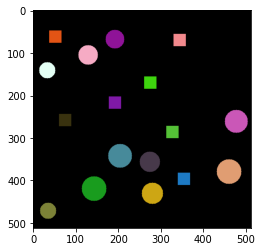

In [58]:
im = Image.open('dummy_2.png')
plt.imshow(im)

In [59]:
ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=train_transform_norm)
val_ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=validation_transform_norm)
BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)
val_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)


label_map: {0: 0, 1: 1}
label_map: {0: 0, 1: 1}


In [60]:
len(ds)

100

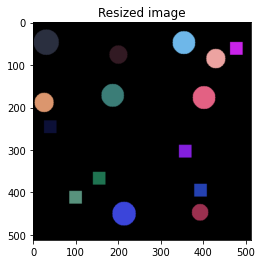

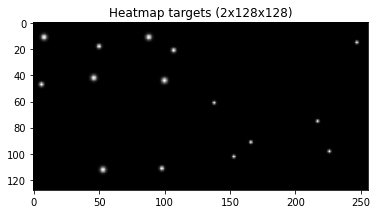

In [61]:
img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale, boxes_aug, target= ds[0]
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img_u = img.transpose(1,2,0)*std + mean# unnormalize
# img = img 
plt.imshow(img_u)
plt.title("Resized image")

plt.show()
c,h,w = hm.shape
nrows = 1
ncols = 2
hm_u = hm.reshape(nrows, ncols, h, w).swapaxes(1,2).reshape(h*nrows, w*ncols)
# hm_u = hm.transpose(1,2,0)
plt.imshow(hm_u,cmap='gray')
plt.title("Heatmap targets (2x128x128)")
plt.show()

# Background

## Single Stage vs Two Stage
<a id='single-vs-two-stage'></a>

## Centernet

# Preprocessing

## Encode Class Keypoints

```python
def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap
```

## Encoding bounding boxes

```python
centers = np.array([bboxes[:,0]+bboxes[:,2]//2,bboxes[:,1]+bboxes[:,3]//2,bboxes[:,2],bboxes[:,3]]).T
for ind,(c,l )in enumerate(zip(centers,classes)):
    h, w = c[3]/MODEL_SCALE, c[2]/MODEL_SCALE
    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
    radius = max(0, int(radius))
    # print("radius:", radius)
    draw_umich_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
                            radius)
    # draw_msra_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
    #                         radius)
    reg_mask[ind] = 1
    wh[ind] = c[2:]/input_size
    draw_dense_reg(reg,hm[l],c[:2]//MODEL_SCALE,wh[ind],radius)
    inds[ind] = (int(c[1])//MODEL_SCALE)*feature_scale + (int(c[0])//MODEL_SCALE)
```

## Encode Width and Height Regression

```python
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)

  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap
```

# Model Architecture


## Backbone

```python
if model_name == 'mv3':
            basemodel = torchvision.models.mobilenet_v3_small(pretrained=True)
            num_ch = 576
elif model_name == 'resnet18':
            basemodel = torchvision.models.resnet18(pretrained=True)
            num_ch = 512
basemodel = nn.Sequential(*list(basemodel.children())[:-2])
# set basemodel
self.base_model = basemodel
# Neck
self.up1 = up(num_ch, 512,bilinear=True)
self.up2 = up(512, 256,bilinear=True)
self.up3 = up(256, 256,bilinear=True)
```

## Class Head and Regression Head

```python

# output classification
self.outc = nn.Conv2d(256, n_classes, 1)

self.outr = nn.Conv2d(256, 2, 1)
```

## Initalization of conv layers in Neck for Focal Loss

```python
'''
Author of focal loss:  all new conv layers except the 
final layer, subnets are initalized  with bias b=0 and
a Gaussian weight filled with sigma=0.01

Weight init improves training stability for both the 
cross entropy and focal loss in the case of heavy class
imbalance
'''
for m in self.conv.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
```

## Initalization of Layers in Head for Focal Loss

```python
'''
Author: the final conv later set the bias
initalization to log((1-pi)/pi)
pi specifies that at the start of training,
every anchor should be labeled as foreground
with confidence of about pi. pi is a variable that is 0.01

This initalization prevents a large number of background 
anchors from generating a large destabalizing loss value in the
in the first iteration of training
'''
self.outc.bias.data.fill_(-2.19)
# output residue
self.outr.bias.data.fill_(-2.19)
def forward(self, x):
batch_size = x.shape[0]
x = self.base_model(x) 

x = self.up1(x)
x = self.up2(x)
x = self.up3(x)
outc = self.outc(x)
outr = self.outr(x)
return outc, outr
```

In [62]:
model = centernet(ds.num_classes,model_name='mv3')

# Loss Function

# Focal Loss
$$
L_k = \frac{-1}{N} \sum_{xyc}
\begin{cases}
(1 - \hat{Y}_{xyc})^{\alpha} 
        \log(\hat{Y}_{xyc})  & \text{ if } Y_{xyc}=1 \\
\begin{array}{c}
        (1-Y_{xyc})^{\beta} 
        (\hat{Y}_{xyc})^{\alpha}\\
        \log(1-\hat{Y}_{xyc})
        \end{array} & \text{ otherwise }
\end{cases}
$$

```python 
def focal_loss(pred, gt):
  ''' Modified focal loss.
    Arguments:
      pred (batch x h x w)
      gt (batch  x h x w)
  '''
  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0
  prob_pred = F.sigmoid(pred)
  pos_loss = F.logsigmoid(pred) * torch.pow(1 - prob_pred, 2) * pos_inds
  neg_loss = F.logsigmoid(1 - pred) * torch.pow(prob_pred, 2) * neg_inds *  neg_weights 

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss =  loss - (pos_loss + neg_loss) / (num_pos+1e-4)
  return loss
  ```

# Regression Loss
$$
L_{size} = \frac{1}{N}\sum_{k=1}^{N} \left|\hat S_{p_k} - s_k\right|.
$$

```python
def reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr).float()

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  ````

# Prepare and Train Training Model

In [63]:
LR = 1e-3
# LR = 2.5e-4*BATCH_SIZE
model_mv3, losses, mask_losses, regr_losses, min_confidences, median_confidences, max_confidences = train('mv3',
                                                                                                          ds.num_classes,
                                                                                                          learn_rate=LR,
                                                                                                          epochs=300,
                                                                                                          train_loader=train_loader,
                                                                                                          val_loader=val_loader)

  0%|          | 1/300 [00:06<32:59,  6.62s/it]

Epoch 0 - Min conf: 2.478529268046259e-06, Median conf: 0.06268730014562607, Max conf: 0.29747629165649414
Epoch 0 - Loss: 2.664215087890625, Mask Loss: 2.06744647026062, Reg Loss: 0.5967687368392944


  1%|          | 2/300 [00:13<32:58,  6.64s/it]

Epoch 1 - Min conf: 1.0251382263959385e-05, Median conf: 0.047491759061813354, Max conf: 0.2595374584197998
Epoch 1 - Loss: 1.9235022068023682, Mask Loss: 1.6876332759857178, Reg Loss: 0.2358688861131668


  1%|          | 3/300 [00:19<32:50,  6.64s/it]

Epoch 2 - Min conf: 1.3094025234750006e-05, Median conf: 0.04204953461885452, Max conf: 0.3077974319458008
Epoch 2 - Loss: 1.6383610963821411, Mask Loss: 1.4958128929138184, Reg Loss: 0.14254824817180634


  1%|▏         | 4/300 [00:26<32:53,  6.67s/it]

Epoch 3 - Min conf: 0.0007828832021914423, Median conf: 0.036152780055999756, Max conf: 0.2959749400615692
Epoch 3 - Loss: 1.6620328426361084, Mask Loss: 1.4073412418365479, Reg Loss: 0.25469157099723816


  2%|▏         | 5/300 [00:33<32:50,  6.68s/it]

Epoch 4 - Min conf: 0.0008580932626500726, Median conf: 0.03168276697397232, Max conf: 0.3464614152908325
Epoch 4 - Loss: 1.419435977935791, Mask Loss: 1.3214378356933594, Reg Loss: 0.09799811989068985


  2%|▏         | 6/300 [00:40<32:49,  6.70s/it]

Epoch 5 - Min conf: 0.0009695750777609646, Median conf: 0.02833128347992897, Max conf: 0.325482577085495
Epoch 5 - Loss: 1.4615123271942139, Mask Loss: 1.3011120557785034, Reg Loss: 0.16040031611919403


  2%|▏         | 7/300 [00:46<32:52,  6.73s/it]

Epoch 6 - Min conf: 0.000729162769857794, Median conf: 0.02629120834171772, Max conf: 0.3689476549625397
Epoch 6 - Loss: 1.2918424606323242, Mask Loss: 1.1810888051986694, Reg Loss: 0.11075367033481598


  3%|▎         | 8/300 [00:53<32:47,  6.74s/it]

Epoch 7 - Min conf: 0.0008447993895970285, Median conf: 0.024785179644823074, Max conf: 0.38343513011932373
Epoch 7 - Loss: 1.3004655838012695, Mask Loss: 1.1533758640289307, Reg Loss: 0.14708968997001648


  3%|▎         | 9/300 [01:00<32:44,  6.75s/it]

Epoch 8 - Min conf: 0.0006461642333306372, Median conf: 0.02322176843881607, Max conf: 0.36380183696746826
Epoch 8 - Loss: 1.2122175693511963, Mask Loss: 1.0836209058761597, Reg Loss: 0.1285967081785202


  3%|▎         | 10/300 [01:07<32:46,  6.78s/it]

Epoch 9 - Min conf: 0.0005701425834558904, Median conf: 0.02275996282696724, Max conf: 0.4391287565231323
Epoch 9 - Loss: 1.1550140380859375, Mask Loss: 1.0615633726119995, Reg Loss: 0.09345067292451859


  4%|▎         | 11/300 [01:14<32:38,  6.78s/it]

Epoch 10 - Min conf: 0.0003757014055736363, Median conf: 0.021854877471923828, Max conf: 0.500840961933136
Epoch 10 - Loss: 1.09602952003479, Mask Loss: 0.9607930779457092, Reg Loss: 0.13523641228675842


  4%|▍         | 12/300 [01:20<32:43,  6.82s/it]

Epoch 11 - Min conf: 0.0002719751209951937, Median conf: 0.021044861525297165, Max conf: 0.5248469114303589
Epoch 11 - Loss: 1.1393311023712158, Mask Loss: 1.0160200595855713, Reg Loss: 0.12331104278564453


  4%|▍         | 13/300 [01:27<32:48,  6.86s/it]

Epoch 12 - Min conf: 0.00048718840116634965, Median conf: 0.01857621781527996, Max conf: 0.5387778878211975
Epoch 12 - Loss: 0.9131292104721069, Mask Loss: 0.8480269312858582, Reg Loss: 0.06510226428508759


  5%|▍         | 14/300 [01:34<32:57,  6.91s/it]

Epoch 13 - Min conf: 0.0003418746928218752, Median conf: 0.017790142446756363, Max conf: 0.5446178913116455
Epoch 13 - Loss: 0.8010424971580505, Mask Loss: 0.7023674249649048, Reg Loss: 0.09867507964372635


  5%|▌         | 15/300 [01:41<32:47,  6.90s/it]

Epoch 14 - Min conf: 0.0004464876838028431, Median conf: 0.017726242542266846, Max conf: 0.5838668346405029
Epoch 14 - Loss: 0.9328752756118774, Mask Loss: 0.7523857355117798, Reg Loss: 0.18048952519893646


  5%|▌         | 16/300 [01:48<32:38,  6.90s/it]

Epoch 15 - Min conf: 0.000574446574319154, Median conf: 0.016722429543733597, Max conf: 0.59806227684021
Epoch 15 - Loss: 0.688688337802887, Mask Loss: 0.6053574681282043, Reg Loss: 0.08333089202642441


  6%|▌         | 17/300 [01:55<32:35,  6.91s/it]

Epoch 16 - Min conf: 0.0005242489860393107, Median conf: 0.016779977828264236, Max conf: 0.5074639916419983
Epoch 16 - Loss: 0.7686339020729065, Mask Loss: 0.7236082553863525, Reg Loss: 0.04502565786242485


  6%|▌         | 18/300 [02:02<32:33,  6.93s/it]

Epoch 17 - Min conf: 0.0003880783333443105, Median conf: 0.015483802184462547, Max conf: 0.6508665084838867
Epoch 17 - Loss: 0.8613088130950928, Mask Loss: 0.6398739218711853, Reg Loss: 0.22143486142158508


  6%|▋         | 19/300 [02:09<32:27,  6.93s/it]

Epoch 18 - Min conf: 0.00045944753219373524, Median conf: 0.015242114663124084, Max conf: 0.6055447459220886
Epoch 18 - Loss: 0.7231412529945374, Mask Loss: 0.6003793478012085, Reg Loss: 0.12276189029216766


  7%|▋         | 20/300 [02:16<32:23,  6.94s/it]

Epoch 19 - Min conf: 0.0005335056339390576, Median conf: 0.014780962839722633, Max conf: 0.6410939693450928
Epoch 19 - Loss: 0.7207545638084412, Mask Loss: 0.5535022616386414, Reg Loss: 0.1672522872686386


  7%|▋         | 21/300 [02:23<32:18,  6.95s/it]

Epoch 20 - Min conf: 0.00047096959315240383, Median conf: 0.014843414537608624, Max conf: 0.6740355491638184
Epoch 20 - Loss: 0.6341149806976318, Mask Loss: 0.5428540706634521, Reg Loss: 0.09126092493534088


  7%|▋         | 22/300 [02:30<32:14,  6.96s/it]

Epoch 21 - Min conf: 0.00026930091553367674, Median conf: 0.014002454467117786, Max conf: 0.6034202575683594
Epoch 21 - Loss: 0.5332573056221008, Mask Loss: 0.4193793535232544, Reg Loss: 0.11387793719768524


  8%|▊         | 23/300 [02:37<32:12,  6.98s/it]

Epoch 22 - Min conf: 0.00029689876828342676, Median conf: 0.013048162683844566, Max conf: 0.6676746010780334
Epoch 22 - Loss: 0.6451271772384644, Mask Loss: 0.5096592307090759, Reg Loss: 0.13546791672706604


  8%|▊         | 24/300 [02:44<32:07,  6.99s/it]

Epoch 23 - Min conf: 0.0002628305519465357, Median conf: 0.012894410640001297, Max conf: 0.6916100978851318
Epoch 23 - Loss: 0.5938652157783508, Mask Loss: 0.48599186539649963, Reg Loss: 0.1078733578324318


  8%|▊         | 25/300 [02:51<32:02,  6.99s/it]

Epoch 24 - Min conf: 0.00027811952168121934, Median conf: 0.012593920342624187, Max conf: 0.6985025405883789
Epoch 24 - Loss: 0.9051350355148315, Mask Loss: 0.6846813559532166, Reg Loss: 0.22045369446277618


  9%|▊         | 26/300 [02:58<31:57,  7.00s/it]

Epoch 25 - Min conf: 0.00020912241598125547, Median conf: 0.012046257965266705, Max conf: 0.6436808109283447
Epoch 25 - Loss: 0.5896737575531006, Mask Loss: 0.45004788041114807, Reg Loss: 0.1396258920431137


  9%|▉         | 27/300 [03:05<32:00,  7.04s/it]

Epoch 26 - Min conf: 0.00026129867183044553, Median conf: 0.012464752420783043, Max conf: 0.7084777355194092
Epoch 26 - Loss: 0.39869821071624756, Mask Loss: 0.3126450181007385, Reg Loss: 0.08605317771434784


  9%|▉         | 28/300 [03:12<32:05,  7.08s/it]

Epoch 27 - Min conf: 0.00024367921287193894, Median conf: 0.012281653471291065, Max conf: 0.7866609692573547
Epoch 27 - Loss: 0.44398289918899536, Mask Loss: 0.3199106752872467, Reg Loss: 0.12407220900058746


 10%|▉         | 29/300 [03:19<32:08,  7.12s/it]

Epoch 28 - Min conf: 0.00015676724433433264, Median conf: 0.011671395041048527, Max conf: 0.7840197086334229
Epoch 28 - Loss: 0.5105513334274292, Mask Loss: 0.45452848076820374, Reg Loss: 0.056022848933935165


 10%|█         | 30/300 [03:27<32:13,  7.16s/it]

Epoch 29 - Min conf: 0.0001912959269247949, Median conf: 0.011021247133612633, Max conf: 0.7033677101135254
Epoch 29 - Loss: 0.43684762716293335, Mask Loss: 0.316726952791214, Reg Loss: 0.12012067437171936


 10%|█         | 31/300 [03:34<32:14,  7.19s/it]

Epoch 30 - Min conf: 0.00015077875286806375, Median conf: 0.010933521203696728, Max conf: 0.6842591166496277
Epoch 30 - Loss: 0.38863345980644226, Mask Loss: 0.3210866153240204, Reg Loss: 0.06754685193300247


 11%|█         | 32/300 [03:41<32:10,  7.21s/it]

Epoch 31 - Min conf: 0.00018618688045535237, Median conf: 0.011205896735191345, Max conf: 0.7849808931350708
Epoch 31 - Loss: 0.3378235697746277, Mask Loss: 0.21808114647865295, Reg Loss: 0.11974242329597473


 11%|█         | 33/300 [03:48<32:04,  7.21s/it]

Epoch 32 - Min conf: 0.00015667294792365283, Median conf: 0.01067928597331047, Max conf: 0.7721567153930664
Epoch 32 - Loss: 0.3724537789821625, Mask Loss: 0.3305862843990326, Reg Loss: 0.04186750575900078


 11%|█▏        | 34/300 [03:56<31:52,  7.19s/it]

Epoch 33 - Min conf: 8.166645420715213e-05, Median conf: 0.010932616889476776, Max conf: 0.7375021576881409
Epoch 33 - Loss: 0.41660356521606445, Mask Loss: 0.3105180561542511, Reg Loss: 0.10608552396297455


 12%|█▏        | 35/300 [04:03<31:42,  7.18s/it]

Epoch 34 - Min conf: 0.00018668104894459248, Median conf: 0.0105286268517375, Max conf: 0.7576010227203369
Epoch 34 - Loss: 0.2800257205963135, Mask Loss: 0.2101786583662033, Reg Loss: 0.06984707713127136


 12%|█▏        | 36/300 [04:10<31:36,  7.18s/it]

Epoch 35 - Min conf: 0.00014163131709210575, Median conf: 0.010694252327084541, Max conf: 0.7129400372505188
Epoch 35 - Loss: 0.4492347836494446, Mask Loss: 0.30611541867256165, Reg Loss: 0.14311936497688293


 12%|█▏        | 37/300 [04:17<31:20,  7.15s/it]

Epoch 36 - Min conf: 0.00018339944654144347, Median conf: 0.010136551223695278, Max conf: 0.7698144316673279
Epoch 36 - Loss: 0.3428780436515808, Mask Loss: 0.2621968984603882, Reg Loss: 0.08068113774061203


 13%|█▎        | 38/300 [04:24<31:13,  7.15s/it]

Epoch 37 - Min conf: 0.00011183507740497589, Median conf: 0.009988874197006226, Max conf: 0.7717025279998779
Epoch 37 - Loss: 0.3300192356109619, Mask Loss: 0.23825010657310486, Reg Loss: 0.09176914393901825


 13%|█▎        | 39/300 [04:31<31:02,  7.13s/it]

Epoch 38 - Min conf: 6.24513195361942e-05, Median conf: 0.010127425193786621, Max conf: 0.6844065189361572
Epoch 38 - Loss: 0.4361111521720886, Mask Loss: 0.3647283613681793, Reg Loss: 0.0713828057050705


 13%|█▎        | 40/300 [04:38<30:57,  7.14s/it]

Epoch 39 - Min conf: 0.0001273099478567019, Median conf: 0.010094612836837769, Max conf: 0.7685591578483582
Epoch 39 - Loss: 0.3131669759750366, Mask Loss: 0.19955961406230927, Reg Loss: 0.11360736936330795


 14%|█▎        | 41/300 [04:46<30:51,  7.15s/it]

Epoch 40 - Min conf: 9.797964594326913e-05, Median conf: 0.010458041913807392, Max conf: 0.787436306476593
Epoch 40 - Loss: 0.3004991412162781, Mask Loss: 0.19415706396102905, Reg Loss: 0.10634206980466843


 14%|█▍        | 42/300 [04:53<30:47,  7.16s/it]

Epoch 41 - Min conf: 7.978370558703318e-05, Median conf: 0.009880980476737022, Max conf: 0.8297611474990845
Epoch 41 - Loss: 0.31909358501434326, Mask Loss: 0.20162290334701538, Reg Loss: 0.11747069656848907


 14%|█▍        | 43/300 [05:00<30:38,  7.15s/it]

Epoch 42 - Min conf: 5.936430170550011e-05, Median conf: 0.009693666361272335, Max conf: 0.8173600435256958
Epoch 42 - Loss: 0.30902236700057983, Mask Loss: 0.22381392121315002, Reg Loss: 0.085208460688591


 15%|█▍        | 44/300 [05:07<30:35,  7.17s/it]

Epoch 43 - Min conf: 6.517089059343562e-05, Median conf: 0.009508781135082245, Max conf: 0.8173322677612305
Epoch 43 - Loss: 0.29084107279777527, Mask Loss: 0.23683960735797882, Reg Loss: 0.05400147661566734


 15%|█▌        | 45/300 [05:14<30:29,  7.17s/it]

Epoch 44 - Min conf: 5.6000048061832786e-05, Median conf: 0.009105363860726357, Max conf: 0.7494438886642456
Epoch 44 - Loss: 0.4166993498802185, Mask Loss: 0.3253129720687866, Reg Loss: 0.09138637781143188


 15%|█▌        | 46/300 [05:21<30:19,  7.16s/it]

Epoch 45 - Min conf: 0.00011308223474770784, Median conf: 0.009073695167899132, Max conf: 0.7923145294189453
Epoch 45 - Loss: 0.34349995851516724, Mask Loss: 0.27583959698677063, Reg Loss: 0.06766034662723541


 16%|█▌        | 47/300 [05:29<30:12,  7.16s/it]

Epoch 46 - Min conf: 7.941442891024053e-05, Median conf: 0.009413374587893486, Max conf: 0.7712735533714294
Epoch 46 - Loss: 0.3630285859107971, Mask Loss: 0.3025234341621399, Reg Loss: 0.06050516292452812


 16%|█▌        | 48/300 [05:36<30:00,  7.15s/it]

Epoch 47 - Min conf: 7.60915208957158e-05, Median conf: 0.009422888979315758, Max conf: 0.7668061852455139
Epoch 47 - Loss: 0.33330264687538147, Mask Loss: 0.1919422596693039, Reg Loss: 0.14136038720607758


 16%|█▋        | 49/300 [05:43<29:52,  7.14s/it]

Epoch 48 - Min conf: 9.534187847748399e-05, Median conf: 0.008907286450266838, Max conf: 0.7873475551605225
Epoch 48 - Loss: 0.5585469603538513, Mask Loss: 0.3718191981315613, Reg Loss: 0.18672777712345123


 17%|█▋        | 50/300 [05:50<29:48,  7.15s/it]

Epoch 49 - Min conf: 7.193561759777367e-05, Median conf: 0.009258706122636795, Max conf: 0.8195564150810242
Epoch 49 - Loss: 0.25644755363464355, Mask Loss: 0.19709694385528564, Reg Loss: 0.05935061350464821


 17%|█▋        | 51/300 [05:57<29:40,  7.15s/it]

Epoch 50 - Min conf: 5.468707240652293e-05, Median conf: 0.00925862230360508, Max conf: 0.8041715025901794
Epoch 50 - Loss: 0.2848067283630371, Mask Loss: 0.2077246457338333, Reg Loss: 0.07708209753036499


 17%|█▋        | 52/300 [06:04<29:34,  7.16s/it]

Epoch 51 - Min conf: 3.9004320569802076e-05, Median conf: 0.008752252906560898, Max conf: 0.815505862236023
Epoch 51 - Loss: 0.18099269270896912, Mask Loss: 0.13507837057113647, Reg Loss: 0.04591432958841324


 18%|█▊        | 53/300 [06:11<29:25,  7.15s/it]

Epoch 52 - Min conf: 5.500674888025969e-05, Median conf: 0.00888286717236042, Max conf: 0.8234819173812866
Epoch 52 - Loss: 0.2237744927406311, Mask Loss: 0.1668846607208252, Reg Loss: 0.056889839470386505


 18%|█▊        | 54/300 [06:19<29:17,  7.14s/it]

Epoch 53 - Min conf: 6.125357322162017e-05, Median conf: 0.00882356520742178, Max conf: 0.8606854677200317
Epoch 53 - Loss: 0.30683013796806335, Mask Loss: 0.2582443356513977, Reg Loss: 0.048585813492536545


 18%|█▊        | 55/300 [06:26<29:10,  7.14s/it]

Epoch 54 - Min conf: 6.197545008035377e-05, Median conf: 0.008354291319847107, Max conf: 0.7907231450080872
Epoch 54 - Loss: 0.3187890350818634, Mask Loss: 0.23495721817016602, Reg Loss: 0.08383180946111679


 19%|█▊        | 56/300 [06:33<29:03,  7.14s/it]

Epoch 55 - Min conf: 7.38296948838979e-05, Median conf: 0.007411235012114048, Max conf: 0.8366594910621643
Epoch 55 - Loss: 0.21081262826919556, Mask Loss: 0.1675136387348175, Reg Loss: 0.04329899325966835


 19%|█▉        | 57/300 [06:40<28:54,  7.14s/it]

Epoch 56 - Min conf: 3.912573083653115e-05, Median conf: 0.008103979751467705, Max conf: 0.783240556716919
Epoch 56 - Loss: 0.2614143490791321, Mask Loss: 0.2135067880153656, Reg Loss: 0.04790756478905678


 19%|█▉        | 58/300 [06:47<28:46,  7.13s/it]

Epoch 57 - Min conf: 6.711893365718424e-05, Median conf: 0.00786726176738739, Max conf: 0.8215196132659912
Epoch 57 - Loss: 0.21431228518486023, Mask Loss: 0.14720050990581512, Reg Loss: 0.06711176782846451


 20%|█▉        | 59/300 [06:54<28:41,  7.14s/it]

Epoch 58 - Min conf: 2.7518839488038793e-05, Median conf: 0.008406681008636951, Max conf: 0.8007376790046692
Epoch 58 - Loss: 0.20892740786075592, Mask Loss: 0.11650402843952179, Reg Loss: 0.09242337942123413


 20%|██        | 60/300 [07:01<28:36,  7.15s/it]

Epoch 59 - Min conf: 5.1568538765423e-05, Median conf: 0.008049916476011276, Max conf: 0.8589356541633606
Epoch 59 - Loss: 0.31304028630256653, Mask Loss: 0.25565385818481445, Reg Loss: 0.05738643929362297


 20%|██        | 61/300 [07:09<28:29,  7.15s/it]

Epoch 60 - Min conf: 3.243191531510092e-05, Median conf: 0.00803720485419035, Max conf: 0.8046736717224121
Epoch 60 - Loss: 0.2584135830402374, Mask Loss: 0.20982393622398376, Reg Loss: 0.04858965426683426


 21%|██        | 62/300 [07:16<28:19,  7.14s/it]

Epoch 61 - Min conf: 4.835818617721088e-05, Median conf: 0.007568478584289551, Max conf: 0.828859806060791
Epoch 61 - Loss: 0.17670327425003052, Mask Loss: 0.12505626678466797, Reg Loss: 0.05164700746536255


 21%|██        | 63/300 [07:23<28:13,  7.14s/it]

Epoch 62 - Min conf: 5.453703488456085e-05, Median conf: 0.007648048922419548, Max conf: 0.8534497618675232
Epoch 62 - Loss: 0.25128108263015747, Mask Loss: 0.14216269552707672, Reg Loss: 0.10911839455366135


 21%|██▏       | 64/300 [07:30<28:04,  7.14s/it]

Epoch 63 - Min conf: 2.5987348635680974e-05, Median conf: 0.00813231524080038, Max conf: 0.8164273500442505
Epoch 63 - Loss: 0.2842238247394562, Mask Loss: 0.13018031418323517, Reg Loss: 0.154043510556221


 22%|██▏       | 65/300 [07:37<27:58,  7.14s/it]

Epoch 64 - Min conf: 2.3015858459984884e-05, Median conf: 0.00771903432905674, Max conf: 0.8547120094299316
Epoch 64 - Loss: 0.24801579117774963, Mask Loss: 0.19350601732730865, Reg Loss: 0.054509781301021576


 22%|██▏       | 66/300 [07:44<27:49,  7.14s/it]

Epoch 65 - Min conf: 3.211686998838559e-05, Median conf: 0.0077863214537501335, Max conf: 0.8596347570419312
Epoch 65 - Loss: 0.2820558249950409, Mask Loss: 0.18349705636501312, Reg Loss: 0.09855876863002777


 22%|██▏       | 67/300 [07:51<27:44,  7.14s/it]

Epoch 66 - Min conf: 5.029885141993873e-05, Median conf: 0.007418036460876465, Max conf: 0.8414005041122437
Epoch 66 - Loss: 0.3078020215034485, Mask Loss: 0.24577392637729645, Reg Loss: 0.06202809140086174


 23%|██▎       | 68/300 [07:59<27:33,  7.13s/it]

Epoch 67 - Min conf: 3.857305273413658e-05, Median conf: 0.0074913762509822845, Max conf: 0.8196205496788025
Epoch 67 - Loss: 0.1874726563692093, Mask Loss: 0.1407814472913742, Reg Loss: 0.04669121280312538


 23%|██▎       | 69/300 [08:06<27:23,  7.12s/it]

Epoch 68 - Min conf: 4.271307625458576e-05, Median conf: 0.007512860931456089, Max conf: 0.8556228876113892
Epoch 68 - Loss: 0.1347435712814331, Mask Loss: 0.10439459979534149, Reg Loss: 0.030348969623446465


 23%|██▎       | 70/300 [08:13<27:21,  7.13s/it]

Epoch 69 - Min conf: 3.599049523472786e-05, Median conf: 0.007513419725000858, Max conf: 0.8781223297119141
Epoch 69 - Loss: 0.29736074805259705, Mask Loss: 0.22412516176700592, Reg Loss: 0.07323558628559113


 24%|██▎       | 71/300 [08:20<27:09,  7.12s/it]

Epoch 70 - Min conf: 4.952181552653201e-05, Median conf: 0.007135952822864056, Max conf: 0.8490488529205322
Epoch 70 - Loss: 0.13478633761405945, Mask Loss: 0.11433643102645874, Reg Loss: 0.02044990286231041


 24%|██▍       | 72/300 [08:27<27:04,  7.13s/it]

Epoch 71 - Min conf: 7.138939690776169e-05, Median conf: 0.00725303590297699, Max conf: 0.8584428429603577
Epoch 71 - Loss: 0.35129863023757935, Mask Loss: 0.216202050447464, Reg Loss: 0.13509657979011536


 24%|██▍       | 73/300 [08:34<26:57,  7.12s/it]

Epoch 72 - Min conf: 3.0069328204263e-05, Median conf: 0.007332406938076019, Max conf: 0.8270497918128967
Epoch 72 - Loss: 0.1762220412492752, Mask Loss: 0.14411574602127075, Reg Loss: 0.03210629150271416


 25%|██▍       | 74/300 [08:41<26:50,  7.13s/it]

Epoch 73 - Min conf: 2.370462789258454e-05, Median conf: 0.0075321802869439125, Max conf: 0.8491825461387634
Epoch 73 - Loss: 0.2442559152841568, Mask Loss: 0.18874004483222961, Reg Loss: 0.05551586672663689


 25%|██▌       | 75/300 [08:48<26:41,  7.12s/it]

Epoch 74 - Min conf: 3.107087832177058e-05, Median conf: 0.007747504860162735, Max conf: 0.8513909578323364
Epoch 74 - Loss: 0.22900106012821198, Mask Loss: 0.18329410254955292, Reg Loss: 0.04570695385336876


 25%|██▌       | 76/300 [08:56<26:34,  7.12s/it]

Epoch 75 - Min conf: 3.380614725756459e-05, Median conf: 0.007687967736274004, Max conf: 0.8374558687210083
Epoch 75 - Loss: 0.23419120907783508, Mask Loss: 0.16700425744056702, Reg Loss: 0.06718695163726807


 26%|██▌       | 77/300 [09:03<26:25,  7.11s/it]

Epoch 76 - Min conf: 4.354078555479646e-05, Median conf: 0.006933082826435566, Max conf: 0.8803673982620239
Epoch 76 - Loss: 0.17436370253562927, Mask Loss: 0.13660874962806702, Reg Loss: 0.03775494918227196


 26%|██▌       | 78/300 [09:10<26:18,  7.11s/it]

Epoch 77 - Min conf: 4.140301462030038e-05, Median conf: 0.006879918742924929, Max conf: 0.8697177171707153
Epoch 77 - Loss: 0.16561774909496307, Mask Loss: 0.11273839324712753, Reg Loss: 0.05287935212254524


 26%|██▋       | 79/300 [09:17<26:08,  7.10s/it]

Epoch 78 - Min conf: 4.8965859605232254e-05, Median conf: 0.006943198386579752, Max conf: 0.818175733089447
Epoch 78 - Loss: 0.2439664602279663, Mask Loss: 0.17454110085964203, Reg Loss: 0.06942535191774368


 27%|██▋       | 80/300 [09:24<26:03,  7.11s/it]

Epoch 79 - Min conf: 4.373386764200404e-05, Median conf: 0.0068190935999155045, Max conf: 0.8360053300857544
Epoch 79 - Loss: 0.242677703499794, Mask Loss: 0.1382196545600891, Reg Loss: 0.1044580489397049


 27%|██▋       | 81/300 [09:31<26:21,  7.22s/it]

Epoch 80 - Min conf: 3.3042426366591826e-05, Median conf: 0.007022364996373653, Max conf: 0.856590747833252
Epoch 80 - Loss: 0.2707466185092926, Mask Loss: 0.21568477153778076, Reg Loss: 0.05506185069680214


 27%|██▋       | 82/300 [09:39<26:09,  7.20s/it]

Epoch 81 - Min conf: 2.396004128968343e-05, Median conf: 0.007123010233044624, Max conf: 0.8445629477500916
Epoch 81 - Loss: 0.15070556104183197, Mask Loss: 0.12421238422393799, Reg Loss: 0.02649318054318428


 28%|██▊       | 83/300 [09:46<25:54,  7.17s/it]

Epoch 82 - Min conf: 3.0468272598227486e-05, Median conf: 0.007052411325275898, Max conf: 0.8666954040527344
Epoch 82 - Loss: 0.23705196380615234, Mask Loss: 0.14726302027702332, Reg Loss: 0.08978893607854843


 28%|██▊       | 84/300 [09:53<25:48,  7.17s/it]

Epoch 83 - Min conf: 2.318248152732849e-05, Median conf: 0.007259847596287727, Max conf: 0.8547389507293701
Epoch 83 - Loss: 0.18973636627197266, Mask Loss: 0.08558707684278488, Reg Loss: 0.10414928197860718


 28%|██▊       | 85/300 [10:00<25:36,  7.14s/it]

Epoch 84 - Min conf: 2.8859263693448156e-05, Median conf: 0.006846325471997261, Max conf: 0.8330299854278564
Epoch 84 - Loss: 0.1490972936153412, Mask Loss: 0.081031434237957, Reg Loss: 0.06806585192680359


 29%|██▊       | 86/300 [10:07<25:25,  7.13s/it]

Epoch 85 - Min conf: 2.9100727260811254e-05, Median conf: 0.006973341107368469, Max conf: 0.8769692182540894
Epoch 85 - Loss: 0.2499929666519165, Mask Loss: 0.18086953461170197, Reg Loss: 0.06912342458963394


 29%|██▉       | 87/300 [10:14<25:12,  7.10s/it]

Epoch 86 - Min conf: 1.6704701920389198e-05, Median conf: 0.007094831205904484, Max conf: 0.8752771615982056
Epoch 86 - Loss: 0.17377698421478271, Mask Loss: 0.12234863638877869, Reg Loss: 0.05142834410071373


 29%|██▉       | 88/300 [10:21<25:05,  7.10s/it]

Epoch 87 - Min conf: 1.633723877603188e-05, Median conf: 0.007151453755795956, Max conf: 0.8272182941436768
Epoch 87 - Loss: 0.20799681544303894, Mask Loss: 0.1076875776052475, Reg Loss: 0.10030923038721085


 30%|██▉       | 89/300 [10:28<24:56,  7.09s/it]

Epoch 88 - Min conf: 2.228195808129385e-05, Median conf: 0.007072752341628075, Max conf: 0.8400381207466125
Epoch 88 - Loss: 0.20080454647541046, Mask Loss: 0.15279315412044525, Reg Loss: 0.04801139608025551


 30%|███       | 90/300 [10:35<24:45,  7.07s/it]

Epoch 89 - Min conf: 2.3926293579279445e-05, Median conf: 0.007057583890855312, Max conf: 0.8255950808525085
Epoch 89 - Loss: 0.22901426255702972, Mask Loss: 0.1901746541261673, Reg Loss: 0.03883960470557213


 30%|███       | 91/300 [10:42<24:40,  7.09s/it]

Epoch 90 - Min conf: 1.3208128621045034e-05, Median conf: 0.007087997160851955, Max conf: 0.8569146990776062
Epoch 90 - Loss: 0.16069623827934265, Mask Loss: 0.09843689203262329, Reg Loss: 0.06225933879613876


 31%|███       | 92/300 [10:49<24:31,  7.07s/it]

Epoch 91 - Min conf: 1.2212331967020873e-05, Median conf: 0.007076880894601345, Max conf: 0.8630942702293396
Epoch 91 - Loss: 0.12347452342510223, Mask Loss: 0.08715707063674927, Reg Loss: 0.036317456513643265


 31%|███       | 93/300 [10:56<24:23,  7.07s/it]

Epoch 92 - Min conf: 1.1041144716728013e-05, Median conf: 0.007221945561468601, Max conf: 0.8580645322799683
Epoch 92 - Loss: 0.20372024178504944, Mask Loss: 0.10996381938457489, Reg Loss: 0.09375642985105515


 31%|███▏      | 94/300 [11:04<24:20,  7.09s/it]

Epoch 93 - Min conf: 1.1215293852728792e-05, Median conf: 0.00703931599855423, Max conf: 0.878002941608429
Epoch 93 - Loss: 0.22433052957057953, Mask Loss: 0.15113791823387146, Reg Loss: 0.07319261133670807


 32%|███▏      | 95/300 [11:11<24:13,  7.09s/it]

Epoch 94 - Min conf: 1.4891130376781803e-05, Median conf: 0.007099695038050413, Max conf: 0.8666048049926758
Epoch 94 - Loss: 0.21161657571792603, Mask Loss: 0.1828470081090927, Reg Loss: 0.028769569471478462


 32%|███▏      | 96/300 [11:18<24:07,  7.09s/it]

Epoch 95 - Min conf: 1.3002068953937851e-05, Median conf: 0.007062012795358896, Max conf: 0.8514679670333862
Epoch 95 - Loss: 0.12377370893955231, Mask Loss: 0.08456962555646896, Reg Loss: 0.039204079657793045


 32%|███▏      | 97/300 [11:25<24:02,  7.10s/it]

Epoch 96 - Min conf: 2.204453994636424e-05, Median conf: 0.006786823272705078, Max conf: 0.8661236763000488
Epoch 96 - Loss: 0.15441259741783142, Mask Loss: 0.11222201585769653, Reg Loss: 0.04219057410955429


 33%|███▎      | 98/300 [11:32<23:56,  7.11s/it]

Epoch 97 - Min conf: 1.8398410247755237e-05, Median conf: 0.00658970745280385, Max conf: 0.8862716555595398
Epoch 97 - Loss: 0.22656850516796112, Mask Loss: 0.13120892643928528, Reg Loss: 0.09535957872867584


 33%|███▎      | 99/300 [11:39<23:47,  7.10s/it]

Epoch 98 - Min conf: 1.4399426618183497e-05, Median conf: 0.007174613885581493, Max conf: 0.8712168335914612
Epoch 98 - Loss: 0.15395909547805786, Mask Loss: 0.08053888380527496, Reg Loss: 0.0734202042222023


 33%|███▎      | 100/300 [11:46<23:39,  7.10s/it]

Epoch 99 - Min conf: 8.641827662358992e-06, Median conf: 0.0073371147736907005, Max conf: 0.876314640045166
Epoch 99 - Loss: 0.2101196050643921, Mask Loss: 0.1532605141401291, Reg Loss: 0.0568590946495533


 34%|███▎      | 101/300 [11:53<23:32,  7.10s/it]

Epoch 100 - Min conf: 8.310846169479191e-06, Median conf: 0.007341526448726654, Max conf: 0.8498489260673523
Epoch 100 - Loss: 0.11787090450525284, Mask Loss: 0.07623611390590668, Reg Loss: 0.04163479059934616


 34%|███▍      | 102/300 [12:00<23:30,  7.12s/it]

Epoch 101 - Min conf: 6.3598708948120475e-06, Median conf: 0.007221083622425795, Max conf: 0.8680604696273804
Epoch 101 - Loss: 0.15247908234596252, Mask Loss: 0.09147169440984726, Reg Loss: 0.06100738048553467


 34%|███▍      | 103/300 [12:08<23:31,  7.16s/it]

Epoch 102 - Min conf: 7.228298727568472e-06, Median conf: 0.006615225225687027, Max conf: 0.8955246806144714
Epoch 102 - Loss: 0.17044974863529205, Mask Loss: 0.1317036896944046, Reg Loss: 0.03874606266617775


 35%|███▍      | 104/300 [12:15<23:18,  7.13s/it]

Epoch 103 - Min conf: 4.515517503023148e-06, Median conf: 0.00657745823264122, Max conf: 0.8452900052070618
Epoch 103 - Loss: 0.23276755213737488, Mask Loss: 0.17514827847480774, Reg Loss: 0.05761926621198654


 35%|███▌      | 105/300 [12:22<23:06,  7.11s/it]

Epoch 104 - Min conf: 9.716256499814335e-06, Median conf: 0.006382412742823362, Max conf: 0.8620462417602539
Epoch 104 - Loss: 0.1599961221218109, Mask Loss: 0.09842758625745773, Reg Loss: 0.06156852841377258


 35%|███▌      | 106/300 [12:29<22:59,  7.11s/it]

Epoch 105 - Min conf: 3.583925490602269e-06, Median conf: 0.006953011266887188, Max conf: 0.8738143444061279
Epoch 105 - Loss: 0.1443234384059906, Mask Loss: 0.0973859503865242, Reg Loss: 0.0469374842941761


 36%|███▌      | 107/300 [12:36<22:54,  7.12s/it]

Epoch 106 - Min conf: 1.0712444236560259e-05, Median conf: 0.0066600702702999115, Max conf: 0.8775584697723389
Epoch 106 - Loss: 0.09210860729217529, Mask Loss: 0.05385034903883934, Reg Loss: 0.03825825825333595


 36%|███▌      | 108/300 [12:43<22:43,  7.10s/it]

Epoch 107 - Min conf: 5.364657681639073e-06, Median conf: 0.006810403428971767, Max conf: 0.8735036253929138
Epoch 107 - Loss: 0.11757934093475342, Mask Loss: 0.08246646821498871, Reg Loss: 0.03511287644505501


 36%|███▋      | 109/300 [12:50<22:34,  7.09s/it]

Epoch 108 - Min conf: 2.6709881240094546e-06, Median conf: 0.006400490645319223, Max conf: 0.8808882236480713
Epoch 108 - Loss: 0.1109628975391388, Mask Loss: 0.08285069465637207, Reg Loss: 0.028112202882766724


 37%|███▋      | 110/300 [12:57<22:25,  7.08s/it]

Epoch 109 - Min conf: 5.089941623737104e-06, Median conf: 0.0067550912499427795, Max conf: 0.8755047917366028
Epoch 109 - Loss: 0.08816191554069519, Mask Loss: 0.057761721312999725, Reg Loss: 0.030400196090340614


 37%|███▋      | 111/300 [13:04<22:19,  7.09s/it]

Epoch 110 - Min conf: 9.188966032525059e-06, Median conf: 0.0069572338834404945, Max conf: 0.8708226084709167
Epoch 110 - Loss: 0.24201279878616333, Mask Loss: 0.18270348012447357, Reg Loss: 0.05930931493639946


 37%|███▋      | 112/300 [13:11<22:10,  7.07s/it]

Epoch 111 - Min conf: 7.321136763493996e-06, Median conf: 0.006370767019689083, Max conf: 0.8754427433013916
Epoch 111 - Loss: 0.1571647971868515, Mask Loss: 0.12226486206054688, Reg Loss: 0.034899935126304626


 38%|███▊      | 113/300 [13:19<22:02,  7.07s/it]

Epoch 112 - Min conf: 1.0039156222774182e-05, Median conf: 0.006331610959023237, Max conf: 0.867155134677887
Epoch 112 - Loss: 0.13203217089176178, Mask Loss: 0.08139579743146896, Reg Loss: 0.050636373460292816


 38%|███▊      | 114/300 [13:26<21:52,  7.06s/it]

Epoch 113 - Min conf: 7.162171186791966e-06, Median conf: 0.006748008541762829, Max conf: 0.8708880543708801
Epoch 113 - Loss: 0.20356373488903046, Mask Loss: 0.13390731811523438, Reg Loss: 0.06965641677379608


 38%|███▊      | 115/300 [13:33<21:45,  7.05s/it]

Epoch 114 - Min conf: 1.2171704838692676e-05, Median conf: 0.006631460972130299, Max conf: 0.8119401931762695
Epoch 114 - Loss: 0.129670649766922, Mask Loss: 0.09480555355548859, Reg Loss: 0.03486509993672371


 39%|███▊      | 116/300 [13:40<21:38,  7.06s/it]

Epoch 115 - Min conf: 1.4063989510759711e-05, Median conf: 0.006684521678835154, Max conf: 0.8005250096321106
Epoch 115 - Loss: 0.13495007157325745, Mask Loss: 0.11337725818157196, Reg Loss: 0.021572807803750038


 39%|███▉      | 117/300 [13:47<21:32,  7.06s/it]

Epoch 116 - Min conf: 8.490917025483213e-06, Median conf: 0.006376822013407946, Max conf: 0.8463613390922546
Epoch 116 - Loss: 0.1829015016555786, Mask Loss: 0.09408921748399734, Reg Loss: 0.08881228417158127


 39%|███▉      | 118/300 [13:54<21:28,  7.08s/it]

Epoch 117 - Min conf: 1.0153627954423428e-05, Median conf: 0.006348561029881239, Max conf: 0.794196605682373
Epoch 117 - Loss: 0.16834411025047302, Mask Loss: 0.10642335563898087, Reg Loss: 0.061920762062072754


 40%|███▉      | 119/300 [14:01<21:22,  7.09s/it]

Epoch 118 - Min conf: 1.5561872714897618e-05, Median conf: 0.006302287802100182, Max conf: 0.8353943228721619
Epoch 118 - Loss: 0.1905914545059204, Mask Loss: 0.12303050607442856, Reg Loss: 0.06756094843149185


 40%|████      | 120/300 [14:08<21:15,  7.09s/it]

Epoch 119 - Min conf: 8.298547072627116e-06, Median conf: 0.006747887469828129, Max conf: 0.8617364764213562
Epoch 119 - Loss: 0.1578884869813919, Mask Loss: 0.08585251867771149, Reg Loss: 0.07203596830368042


 40%|████      | 121/300 [14:15<21:08,  7.09s/it]

Epoch 120 - Min conf: 9.308974767918698e-06, Median conf: 0.006344943773001432, Max conf: 0.8662846684455872
Epoch 120 - Loss: 0.1608772873878479, Mask Loss: 0.09729105234146118, Reg Loss: 0.06358623504638672


 41%|████      | 122/300 [14:22<21:04,  7.10s/it]

Epoch 121 - Min conf: 1.322771731793182e-05, Median conf: 0.006479911506175995, Max conf: 0.8824920058250427
Epoch 121 - Loss: 0.1576492190361023, Mask Loss: 0.10724084079265594, Reg Loss: 0.05040838196873665


 41%|████      | 123/300 [14:29<20:58,  7.11s/it]

Epoch 122 - Min conf: 8.105508641165216e-06, Median conf: 0.00629537645727396, Max conf: 0.8638644814491272
Epoch 122 - Loss: 0.22978830337524414, Mask Loss: 0.12406827509403229, Reg Loss: 0.10572003573179245


 41%|████▏     | 124/300 [14:36<20:48,  7.10s/it]

Epoch 123 - Min conf: 5.884923666599207e-06, Median conf: 0.006345442496240139, Max conf: 0.8864107728004456
Epoch 123 - Loss: 0.1469113975763321, Mask Loss: 0.11407549679279327, Reg Loss: 0.03283589705824852


 42%|████▏     | 125/300 [14:44<20:43,  7.10s/it]

Epoch 124 - Min conf: 2.6592178983264603e-06, Median conf: 0.006293868646025658, Max conf: 0.8595755100250244
Epoch 124 - Loss: 0.2095332145690918, Mask Loss: 0.08911369740962982, Reg Loss: 0.12041950970888138


 42%|████▏     | 126/300 [14:51<20:50,  7.19s/it]

Epoch 125 - Min conf: 1.2023319868603721e-05, Median conf: 0.006179315969347954, Max conf: 0.8400677442550659
Epoch 125 - Loss: 0.15500539541244507, Mask Loss: 0.1169542521238327, Reg Loss: 0.03805113583803177


 42%|████▏     | 127/300 [14:58<20:39,  7.17s/it]

Epoch 126 - Min conf: 1.3445711374515668e-05, Median conf: 0.0060637290589511395, Max conf: 0.86920166015625
Epoch 126 - Loss: 0.1061868816614151, Mask Loss: 0.06310942023992538, Reg Loss: 0.043077465146780014


 43%|████▎     | 128/300 [15:05<20:29,  7.15s/it]

Epoch 127 - Min conf: 5.357479494705331e-06, Median conf: 0.006205091252923012, Max conf: 0.8601114153862
Epoch 127 - Loss: 0.19818586111068726, Mask Loss: 0.1770772933959961, Reg Loss: 0.021108560264110565


 43%|████▎     | 129/300 [15:12<20:18,  7.13s/it]

Epoch 128 - Min conf: 5.4539477787329815e-06, Median conf: 0.005845062434673309, Max conf: 0.8773592114448547
Epoch 128 - Loss: 0.21724075078964233, Mask Loss: 0.06994326412677765, Reg Loss: 0.14729748666286469


 43%|████▎     | 130/300 [15:19<20:08,  7.11s/it]

Epoch 129 - Min conf: 1.9327377231093124e-05, Median conf: 0.006392329931259155, Max conf: 0.8364341259002686
Epoch 129 - Loss: 0.18981003761291504, Mask Loss: 0.13417375087738037, Reg Loss: 0.055636290460824966


 44%|████▎     | 131/300 [15:26<20:00,  7.10s/it]

Epoch 130 - Min conf: 1.3374173249758314e-05, Median conf: 0.006663885433226824, Max conf: 0.8911636471748352
Epoch 130 - Loss: 0.1351764053106308, Mask Loss: 0.06862405687570572, Reg Loss: 0.06655234843492508


 44%|████▍     | 132/300 [15:34<19:54,  7.11s/it]

Epoch 131 - Min conf: 9.732467333378736e-06, Median conf: 0.006831456441432238, Max conf: 0.8683234453201294
Epoch 131 - Loss: 0.16320684552192688, Mask Loss: 0.12190555036067963, Reg Loss: 0.04130130261182785


 44%|████▍     | 133/300 [15:41<19:48,  7.12s/it]

Epoch 132 - Min conf: 9.882733138510957e-06, Median conf: 0.007172024808824062, Max conf: 0.902613639831543
Epoch 132 - Loss: 0.1666402965784073, Mask Loss: 0.10853861272335052, Reg Loss: 0.058101680129766464


 45%|████▍     | 134/300 [15:48<19:44,  7.13s/it]

Epoch 133 - Min conf: 1.0475876479176804e-05, Median conf: 0.006456759758293629, Max conf: 0.8566382527351379
Epoch 133 - Loss: 0.13361792266368866, Mask Loss: 0.09414917975664139, Reg Loss: 0.03946874290704727


 45%|████▌     | 135/300 [15:55<19:34,  7.12s/it]

Epoch 134 - Min conf: 5.778793365607271e-06, Median conf: 0.006657293066382408, Max conf: 0.8642376065254211
Epoch 134 - Loss: 0.30449724197387695, Mask Loss: 0.20538197457790375, Reg Loss: 0.0991152673959732


 45%|████▌     | 136/300 [16:02<19:24,  7.10s/it]

Epoch 135 - Min conf: 5.757603958045365e-06, Median conf: 0.006660784594714642, Max conf: 0.8567187786102295
Epoch 135 - Loss: 0.24276144802570343, Mask Loss: 0.1827230006456375, Reg Loss: 0.06003844365477562


 46%|████▌     | 137/300 [16:09<19:17,  7.10s/it]

Epoch 136 - Min conf: 5.576041530730436e-06, Median conf: 0.006550812628120184, Max conf: 0.8789385557174683
Epoch 136 - Loss: 0.14020216464996338, Mask Loss: 0.1171388104557991, Reg Loss: 0.023063356056809425


 46%|████▌     | 138/300 [16:16<19:09,  7.10s/it]

Epoch 137 - Min conf: 8.35499849927146e-06, Median conf: 0.006845074240118265, Max conf: 0.8621668815612793
Epoch 137 - Loss: 0.1419559121131897, Mask Loss: 0.07479236274957657, Reg Loss: 0.06716354936361313


 46%|████▋     | 139/300 [16:23<19:02,  7.09s/it]

Epoch 138 - Min conf: 4.575612365442794e-06, Median conf: 0.006103606894612312, Max conf: 0.8822439908981323
Epoch 138 - Loss: 0.25716283917427063, Mask Loss: 0.18888919055461884, Reg Loss: 0.0682736486196518


 47%|████▋     | 140/300 [16:30<18:54,  7.09s/it]

Epoch 139 - Min conf: 3.075507265748456e-06, Median conf: 0.0061417073011398315, Max conf: 0.839013934135437
Epoch 139 - Loss: 0.1973901242017746, Mask Loss: 0.17081351578235626, Reg Loss: 0.026576604694128036


 47%|████▋     | 141/300 [16:37<18:49,  7.10s/it]

Epoch 140 - Min conf: 3.8987627704045735e-06, Median conf: 0.006078160367906094, Max conf: 0.8143754601478577
Epoch 140 - Loss: 0.1737380176782608, Mask Loss: 0.15110285580158234, Reg Loss: 0.02263515815138817


 47%|████▋     | 142/300 [16:45<18:43,  7.11s/it]

Epoch 141 - Min conf: 3.985373041359708e-06, Median conf: 0.005839667282998562, Max conf: 0.8584259748458862
Epoch 141 - Loss: 0.14744174480438232, Mask Loss: 0.115804024040699, Reg Loss: 0.03163772076368332


 48%|████▊     | 143/300 [16:52<18:36,  7.11s/it]

Epoch 142 - Min conf: 3.840478711936157e-06, Median conf: 0.006374386139214039, Max conf: 0.8813537955284119
Epoch 142 - Loss: 0.11925263702869415, Mask Loss: 0.08441425114870071, Reg Loss: 0.03483838960528374


 48%|████▊     | 144/300 [16:59<18:28,  7.11s/it]

Epoch 143 - Min conf: 4.765589437738527e-06, Median conf: 0.006101065315306187, Max conf: 0.9017468094825745
Epoch 143 - Loss: 0.17683587968349457, Mask Loss: 0.11143755912780762, Reg Loss: 0.06539832055568695


 48%|████▊     | 145/300 [17:06<18:20,  7.10s/it]

Epoch 144 - Min conf: 6.518009286082815e-06, Median conf: 0.005963927134871483, Max conf: 0.8948837518692017
Epoch 144 - Loss: 0.15517523884773254, Mask Loss: 0.12282174080610275, Reg Loss: 0.03235349804162979


 49%|████▊     | 146/300 [17:13<18:11,  7.09s/it]

Epoch 145 - Min conf: 4.390837602841202e-06, Median conf: 0.005904040299355984, Max conf: 0.8989953994750977
Epoch 145 - Loss: 0.20234714448451996, Mask Loss: 0.14165641367435455, Reg Loss: 0.06069072708487511


 49%|████▉     | 147/300 [17:20<18:06,  7.10s/it]

Epoch 146 - Min conf: 6.302655947365565e-06, Median conf: 0.00582085782662034, Max conf: 0.8562771081924438
Epoch 146 - Loss: 0.12270551919937134, Mask Loss: 0.07999462634325027, Reg Loss: 0.042710889130830765


 49%|████▉     | 148/300 [17:27<18:10,  7.17s/it]

Epoch 147 - Min conf: 5.540938218473457e-06, Median conf: 0.00560418888926506, Max conf: 0.8770028948783875
Epoch 147 - Loss: 0.09813067317008972, Mask Loss: 0.07585775852203369, Reg Loss: 0.02227291464805603


 50%|████▉     | 149/300 [17:35<17:58,  7.14s/it]

Epoch 148 - Min conf: 6.680192655039718e-06, Median conf: 0.005823690909892321, Max conf: 0.9036684632301331
Epoch 148 - Loss: 0.17304375767707825, Mask Loss: 0.15638451278209686, Reg Loss: 0.01665925234556198


 50%|█████     | 150/300 [17:42<17:48,  7.12s/it]

Epoch 149 - Min conf: 5.681784841726767e-06, Median conf: 0.005446135997772217, Max conf: 0.8665497303009033
Epoch 149 - Loss: 0.17297275364398956, Mask Loss: 0.13671359419822693, Reg Loss: 0.03625916317105293


 50%|█████     | 151/300 [17:49<17:38,  7.11s/it]

Epoch 150 - Min conf: 6.353893695631996e-06, Median conf: 0.0056448401883244514, Max conf: 0.8732377886772156
Epoch 150 - Loss: 0.17910951375961304, Mask Loss: 0.12698791921138763, Reg Loss: 0.0521215982735157


 51%|█████     | 152/300 [17:56<17:30,  7.10s/it]

Epoch 151 - Min conf: 3.867599843943026e-06, Median conf: 0.005636115558445454, Max conf: 0.8846469521522522
Epoch 151 - Loss: 0.18542852997779846, Mask Loss: 0.10158460587263107, Reg Loss: 0.08384391665458679


 51%|█████     | 153/300 [18:03<17:22,  7.09s/it]

Epoch 152 - Min conf: 3.1843019314692356e-06, Median conf: 0.005495439283549786, Max conf: 0.8517106175422668
Epoch 152 - Loss: 0.2336491495370865, Mask Loss: 0.17223957180976868, Reg Loss: 0.06140957400202751


 51%|█████▏    | 154/300 [18:10<17:14,  7.09s/it]

Epoch 153 - Min conf: 7.80310801928863e-06, Median conf: 0.005603477358818054, Max conf: 0.8630172610282898
Epoch 153 - Loss: 0.11864883452653885, Mask Loss: 0.0834667906165123, Reg Loss: 0.03518204391002655


 52%|█████▏    | 155/300 [18:17<17:04,  7.07s/it]

Epoch 154 - Min conf: 8.086137313512154e-06, Median conf: 0.005015978589653969, Max conf: 0.8766764402389526
Epoch 154 - Loss: 0.3141361474990845, Mask Loss: 0.23547236621379852, Reg Loss: 0.07866378128528595


 52%|█████▏    | 156/300 [18:24<16:59,  7.08s/it]

Epoch 155 - Min conf: 7.937554073578212e-06, Median conf: 0.005284713581204414, Max conf: 0.8683050274848938
Epoch 155 - Loss: 0.12263888120651245, Mask Loss: 0.07077810168266296, Reg Loss: 0.051860783249139786


 52%|█████▏    | 157/300 [18:31<16:53,  7.09s/it]

Epoch 156 - Min conf: 7.614779860887211e-06, Median conf: 0.005131489597260952, Max conf: 0.8833427429199219
Epoch 156 - Loss: 0.1184401735663414, Mask Loss: 0.08922719210386276, Reg Loss: 0.02921297959983349


 53%|█████▎    | 158/300 [18:38<16:47,  7.10s/it]

Epoch 157 - Min conf: 4.9672134991851635e-06, Median conf: 0.0050397105515003204, Max conf: 0.8758497834205627
Epoch 157 - Loss: 0.15101997554302216, Mask Loss: 0.10002197325229645, Reg Loss: 0.05099800229072571


 53%|█████▎    | 159/300 [18:45<16:38,  7.08s/it]

Epoch 158 - Min conf: 5.935612080065766e-06, Median conf: 0.004920139908790588, Max conf: 0.8745128512382507
Epoch 158 - Loss: 0.17814745008945465, Mask Loss: 0.13691003620624542, Reg Loss: 0.04123741760849953


 53%|█████▎    | 160/300 [18:52<16:31,  7.08s/it]

Epoch 159 - Min conf: 4.8862052608456e-06, Median conf: 0.005097942426800728, Max conf: 0.8860719799995422
Epoch 159 - Loss: 0.126261904835701, Mask Loss: 0.07849898189306259, Reg Loss: 0.0477629229426384


 54%|█████▎    | 161/300 [18:59<16:20,  7.06s/it]

Epoch 160 - Min conf: 4.28517068939982e-06, Median conf: 0.0052563161589205265, Max conf: 0.8825519680976868
Epoch 160 - Loss: 0.10511627793312073, Mask Loss: 0.06580787897109985, Reg Loss: 0.039308398962020874


 54%|█████▍    | 162/300 [19:06<16:15,  7.07s/it]

Epoch 161 - Min conf: 2.9271234325278783e-06, Median conf: 0.005268793553113937, Max conf: 0.917672336101532
Epoch 161 - Loss: 0.13067905604839325, Mask Loss: 0.07776814699172974, Reg Loss: 0.05291090905666351


 54%|█████▍    | 163/300 [19:14<16:08,  7.07s/it]

Epoch 162 - Min conf: 3.0732994673599023e-06, Median conf: 0.005013606045395136, Max conf: 0.8871872425079346
Epoch 162 - Loss: 0.09189848601818085, Mask Loss: 0.06113472953438759, Reg Loss: 0.030763760209083557


 55%|█████▍    | 164/300 [19:21<16:02,  7.08s/it]

Epoch 163 - Min conf: 2.244463075840031e-06, Median conf: 0.004749990999698639, Max conf: 0.8547372221946716
Epoch 163 - Loss: 0.08114662766456604, Mask Loss: 0.05919316038489342, Reg Loss: 0.021953465417027473


 55%|█████▌    | 165/300 [19:28<15:56,  7.08s/it]

Epoch 164 - Min conf: 1.16940339012217e-06, Median conf: 0.005025824997574091, Max conf: 0.8604297041893005
Epoch 164 - Loss: 0.15317797660827637, Mask Loss: 0.10439366847276688, Reg Loss: 0.048784300684928894


 55%|█████▌    | 166/300 [19:35<15:48,  7.08s/it]

Epoch 165 - Min conf: 2.3594316189701203e-06, Median conf: 0.0048008933663368225, Max conf: 0.8718004822731018
Epoch 165 - Loss: 0.15632480382919312, Mask Loss: 0.10579823702573776, Reg Loss: 0.05052657425403595


 56%|█████▌    | 167/300 [19:42<15:42,  7.08s/it]

Epoch 166 - Min conf: 6.025738912285306e-07, Median conf: 0.004655045457184315, Max conf: 0.9105329513549805
Epoch 166 - Loss: 0.14039261639118195, Mask Loss: 0.08859920501708984, Reg Loss: 0.051793407648801804


 56%|█████▌    | 168/300 [19:49<15:34,  7.08s/it]

Epoch 167 - Min conf: 1.5596389175698278e-06, Median conf: 0.004461292177438736, Max conf: 0.8938867449760437
Epoch 167 - Loss: 0.17937113344669342, Mask Loss: 0.15705709159374237, Reg Loss: 0.022314047440886497


 56%|█████▋    | 169/300 [19:56<15:30,  7.10s/it]

Epoch 168 - Min conf: 4.811791768588591e-06, Median conf: 0.004237827844917774, Max conf: 0.8362810611724854
Epoch 168 - Loss: 0.2708413004875183, Mask Loss: 0.12130484730005264, Reg Loss: 0.14953646063804626


 57%|█████▋    | 170/300 [20:03<15:21,  7.09s/it]

Epoch 169 - Min conf: 1.0442913662700448e-06, Median conf: 0.004343886859714985, Max conf: 0.8884691596031189
Epoch 169 - Loss: 0.13594210147857666, Mask Loss: 0.08600493520498276, Reg Loss: 0.0499371699988842


 57%|█████▋    | 171/300 [20:10<15:12,  7.08s/it]

Epoch 170 - Min conf: 9.919386911860784e-07, Median conf: 0.004595793783664703, Max conf: 0.8742925524711609
Epoch 170 - Loss: 0.0864616110920906, Mask Loss: 0.074380062520504, Reg Loss: 0.012081550434231758


 57%|█████▋    | 172/300 [20:17<15:05,  7.07s/it]

Epoch 171 - Min conf: 4.503510353970341e-06, Median conf: 0.004819517955183983, Max conf: 0.9062109589576721
Epoch 171 - Loss: 0.1541825830936432, Mask Loss: 0.10743024945259094, Reg Loss: 0.04675234109163284


 58%|█████▊    | 173/300 [20:24<14:58,  7.08s/it]

Epoch 172 - Min conf: 3.4818160656868713e-06, Median conf: 0.004346512258052826, Max conf: 0.8824990391731262
Epoch 172 - Loss: 0.146928071975708, Mask Loss: 0.11181259900331497, Reg Loss: 0.03511546552181244


 58%|█████▊    | 174/300 [20:31<14:52,  7.08s/it]

Epoch 173 - Min conf: 1.547984425087634e-06, Median conf: 0.004822310991585255, Max conf: 0.8861770033836365
Epoch 173 - Loss: 0.21209804713726044, Mask Loss: 0.10222640633583069, Reg Loss: 0.10987164080142975


 58%|█████▊    | 175/300 [20:39<14:45,  7.08s/it]

Epoch 174 - Min conf: 1.024622406475828e-06, Median conf: 0.0052774520590901375, Max conf: 0.871325671672821
Epoch 174 - Loss: 0.12029960751533508, Mask Loss: 0.08798888325691223, Reg Loss: 0.03231072425842285


 59%|█████▊    | 176/300 [20:46<14:40,  7.10s/it]

Epoch 175 - Min conf: 1.7244523178305826e-06, Median conf: 0.005344472359865904, Max conf: 0.8833526372909546
Epoch 175 - Loss: 0.14967329800128937, Mask Loss: 0.10712365806102753, Reg Loss: 0.04254963994026184


 59%|█████▉    | 177/300 [20:53<14:33,  7.10s/it]

Epoch 176 - Min conf: 3.0099936338956468e-06, Median conf: 0.00535549595952034, Max conf: 0.8900212049484253
Epoch 176 - Loss: 0.11220890283584595, Mask Loss: 0.09695814549922943, Reg Loss: 0.01525076013058424


 59%|█████▉    | 178/300 [21:00<14:27,  7.11s/it]

Epoch 177 - Min conf: 2.7711600978364004e-06, Median conf: 0.005048066843301058, Max conf: 0.8775891661643982
Epoch 177 - Loss: 0.2183765023946762, Mask Loss: 0.14329901337623596, Reg Loss: 0.07507748901844025


 60%|█████▉    | 179/300 [21:07<14:18,  7.10s/it]

Epoch 178 - Min conf: 2.24734822040773e-06, Median conf: 0.0051467339508235455, Max conf: 0.8664216995239258
Epoch 178 - Loss: 0.1597220003604889, Mask Loss: 0.08454374223947525, Reg Loss: 0.07517826557159424


 60%|██████    | 180/300 [21:14<14:09,  7.08s/it]

Epoch 179 - Min conf: 3.7292629713192582e-06, Median conf: 0.004818995948880911, Max conf: 0.8990669250488281
Epoch 179 - Loss: 0.1048358827829361, Mask Loss: 0.07252649962902069, Reg Loss: 0.032309383153915405


 60%|██████    | 181/300 [21:21<14:00,  7.06s/it]

Epoch 180 - Min conf: 2.9277318844833644e-06, Median conf: 0.004678127355873585, Max conf: 0.8938180208206177
Epoch 180 - Loss: 0.1483319252729416, Mask Loss: 0.09872254729270935, Reg Loss: 0.04960937425494194


 61%|██████    | 182/300 [21:28<13:52,  7.05s/it]

Epoch 181 - Min conf: 4.41457268607337e-06, Median conf: 0.004836376756429672, Max conf: 0.8895958662033081
Epoch 181 - Loss: 0.2050078809261322, Mask Loss: 0.14315475523471832, Reg Loss: 0.06185312569141388


 61%|██████    | 183/300 [21:35<13:46,  7.06s/it]

Epoch 182 - Min conf: 2.4542744085920276e-06, Median conf: 0.00529217766597867, Max conf: 0.8618204593658447
Epoch 182 - Loss: 0.15763571858406067, Mask Loss: 0.11417648196220398, Reg Loss: 0.04345922917127609


 61%|██████▏   | 184/300 [21:42<13:39,  7.06s/it]

Epoch 183 - Min conf: 1.6747025028962526e-06, Median conf: 0.0047767250798642635, Max conf: 0.8785015940666199
Epoch 183 - Loss: 0.11772555112838745, Mask Loss: 0.075235515832901, Reg Loss: 0.04249003902077675


 62%|██████▏   | 185/300 [21:49<13:31,  7.06s/it]

Epoch 184 - Min conf: 3.600887566790334e-06, Median conf: 0.004586935043334961, Max conf: 0.8516889214515686
Epoch 184 - Loss: 0.13554219901561737, Mask Loss: 0.10489842295646667, Reg Loss: 0.030643776059150696


 62%|██████▏   | 186/300 [21:56<13:25,  7.07s/it]

Epoch 185 - Min conf: 1.442636744286574e-06, Median conf: 0.004630733281373978, Max conf: 0.8519182205200195
Epoch 185 - Loss: 0.5168358683586121, Mask Loss: 0.4665294885635376, Reg Loss: 0.050306376069784164


 62%|██████▏   | 187/300 [22:03<13:16,  7.05s/it]

Epoch 186 - Min conf: 1.4385576605491224e-06, Median conf: 0.004066650290042162, Max conf: 0.8367246389389038
Epoch 186 - Loss: 0.11652889847755432, Mask Loss: 0.08369361609220505, Reg Loss: 0.03283528611063957


 63%|██████▎   | 188/300 [22:10<13:09,  7.05s/it]

Epoch 187 - Min conf: 4.147691470279824e-07, Median conf: 0.004046274349093437, Max conf: 0.8661658763885498
Epoch 187 - Loss: 0.09893731027841568, Mask Loss: 0.07764431089162827, Reg Loss: 0.021292997524142265


 63%|██████▎   | 189/300 [22:18<13:04,  7.06s/it]

Epoch 188 - Min conf: 4.628214810509235e-06, Median conf: 0.004086400382220745, Max conf: 0.8716272115707397
Epoch 188 - Loss: 0.1130317747592926, Mask Loss: 0.07585961371660233, Reg Loss: 0.03717215731739998


 63%|██████▎   | 190/300 [22:25<12:57,  7.07s/it]

Epoch 189 - Min conf: 2.356755203436478e-06, Median conf: 0.0045434702187776566, Max conf: 0.855073094367981
Epoch 189 - Loss: 0.12797437608242035, Mask Loss: 0.08446741104125977, Reg Loss: 0.043506961315870285


 64%|██████▎   | 191/300 [22:32<12:51,  7.08s/it]

Epoch 190 - Min conf: 2.638599198689917e-06, Median conf: 0.004800464026629925, Max conf: 0.8783383965492249
Epoch 190 - Loss: 0.19396650791168213, Mask Loss: 0.09650103002786636, Reg Loss: 0.09746547788381577


 64%|██████▍   | 192/300 [22:39<12:44,  7.08s/it]

Epoch 191 - Min conf: 3.5008408758585574e-06, Median conf: 0.005100793205201626, Max conf: 0.8621746897697449
Epoch 191 - Loss: 0.17928873002529144, Mask Loss: 0.11699112504720688, Reg Loss: 0.062297604978084564


 64%|██████▍   | 193/300 [22:46<12:37,  7.08s/it]

Epoch 192 - Min conf: 4.661272214434575e-06, Median conf: 0.005359702743589878, Max conf: 0.8900453448295593
Epoch 192 - Loss: 0.12624478340148926, Mask Loss: 0.06519018113613129, Reg Loss: 0.061054594814777374


 65%|██████▍   | 194/300 [22:53<12:30,  7.08s/it]

Epoch 193 - Min conf: 1.8005165429713088e-06, Median conf: 0.005778695456683636, Max conf: 0.8696386814117432
Epoch 193 - Loss: 0.1313636600971222, Mask Loss: 0.07586731761693954, Reg Loss: 0.055496349930763245


 65%|██████▌   | 195/300 [23:00<12:22,  7.07s/it]

Epoch 194 - Min conf: 7.504633572352759e-07, Median conf: 0.005907964892685413, Max conf: 0.8940763473510742
Epoch 194 - Loss: 0.17280179262161255, Mask Loss: 0.148878276348114, Reg Loss: 0.023923508822917938


 65%|██████▌   | 196/300 [23:07<12:17,  7.09s/it]

Epoch 195 - Min conf: 6.96804875133239e-07, Median conf: 0.005800965707749128, Max conf: 0.9014590978622437
Epoch 195 - Loss: 0.10590913891792297, Mask Loss: 0.07257791608572006, Reg Loss: 0.03333122283220291


 66%|██████▌   | 197/300 [23:14<12:10,  7.10s/it]

Epoch 196 - Min conf: 5.528258384401852e-07, Median conf: 0.006308500189334154, Max conf: 0.8852089047431946
Epoch 196 - Loss: 0.19456034898757935, Mask Loss: 0.10712692141532898, Reg Loss: 0.08743342757225037


 66%|██████▌   | 198/300 [23:21<12:03,  7.09s/it]

Epoch 197 - Min conf: 6.856591880932683e-07, Median conf: 0.0064914412796497345, Max conf: 0.9051405191421509
Epoch 197 - Loss: 0.1873508244752884, Mask Loss: 0.12496118992567062, Reg Loss: 0.06238963082432747


 66%|██████▋   | 199/300 [23:28<11:57,  7.11s/it]

Epoch 198 - Min conf: 1.2097202670702245e-06, Median conf: 0.005958619527518749, Max conf: 0.8911815285682678
Epoch 198 - Loss: 0.061494167894124985, Mask Loss: 0.049038875848054886, Reg Loss: 0.012455292977392673


 67%|██████▋   | 200/300 [23:36<11:49,  7.10s/it]

Epoch 199 - Min conf: 3.327104991512897e-07, Median conf: 0.0056254686787724495, Max conf: 0.9109916687011719
Epoch 199 - Loss: 0.19782276451587677, Mask Loss: 0.09290464967489243, Reg Loss: 0.10491811484098434


 67%|██████▋   | 201/300 [23:43<11:43,  7.10s/it]

Epoch 200 - Min conf: 4.346324828929937e-07, Median conf: 0.006099614314734936, Max conf: 0.8921011090278625
Epoch 200 - Loss: 0.23626497387886047, Mask Loss: 0.11577165871858597, Reg Loss: 0.12049330770969391


 67%|██████▋   | 202/300 [23:50<11:34,  7.09s/it]

Epoch 201 - Min conf: 7.986376999724598e-07, Median conf: 0.006284171715378761, Max conf: 0.8793465495109558
Epoch 201 - Loss: 0.12291154265403748, Mask Loss: 0.05479350686073303, Reg Loss: 0.06811803579330444


 68%|██████▊   | 203/300 [23:57<11:27,  7.09s/it]

Epoch 202 - Min conf: 1.0314086011931067e-06, Median conf: 0.006192475091665983, Max conf: 0.8466528058052063
Epoch 202 - Loss: 0.13616178929805756, Mask Loss: 0.08493281155824661, Reg Loss: 0.051228977739810944


 68%|██████▊   | 204/300 [24:04<11:20,  7.09s/it]

Epoch 203 - Min conf: 1.275126464861387e-06, Median conf: 0.006422406993806362, Max conf: 0.874207615852356
Epoch 203 - Loss: 0.16832903027534485, Mask Loss: 0.08801230043172836, Reg Loss: 0.08031672984361649


 68%|██████▊   | 205/300 [24:11<11:13,  7.09s/it]

Epoch 204 - Min conf: 6.68586949359451e-07, Median conf: 0.006117389537394047, Max conf: 0.9152796864509583
Epoch 204 - Loss: 0.14194384217262268, Mask Loss: 0.06827186793088913, Reg Loss: 0.07367197424173355


 69%|██████▊   | 206/300 [24:18<11:07,  7.10s/it]

Epoch 205 - Min conf: 1.0013282008003443e-06, Median conf: 0.0059465826489031315, Max conf: 0.8984304070472717
Epoch 205 - Loss: 0.07685330510139465, Mask Loss: 0.05091949552297592, Reg Loss: 0.02593380957841873


 69%|██████▉   | 207/300 [24:25<10:59,  7.09s/it]

Epoch 206 - Min conf: 5.082022198621416e-07, Median conf: 0.006546209566295147, Max conf: 0.8887724876403809
Epoch 206 - Loss: 0.10426575690507889, Mask Loss: 0.06804611533880234, Reg Loss: 0.03621964156627655


 69%|██████▉   | 208/300 [24:32<10:55,  7.12s/it]

Epoch 207 - Min conf: 3.5885423699255625e-07, Median conf: 0.006196943111717701, Max conf: 0.8919272422790527
Epoch 207 - Loss: 0.08382673561573029, Mask Loss: 0.06345653533935547, Reg Loss: 0.020370200276374817


 70%|██████▉   | 209/300 [24:39<10:47,  7.12s/it]

Epoch 208 - Min conf: 2.3830099848964892e-07, Median conf: 0.005892529617995024, Max conf: 0.8808766007423401
Epoch 208 - Loss: 0.0882183313369751, Mask Loss: 0.06041523069143295, Reg Loss: 0.027803096920251846


 70%|███████   | 210/300 [24:47<10:40,  7.11s/it]

Epoch 209 - Min conf: 1.3776489993233554e-07, Median conf: 0.006751325447112322, Max conf: 0.9077631235122681
Epoch 209 - Loss: 0.12247428297996521, Mask Loss: 0.06778254359960556, Reg Loss: 0.05469173565506935


 70%|███████   | 211/300 [24:54<10:32,  7.11s/it]

Epoch 210 - Min conf: 4.334779930559307e-07, Median conf: 0.0066991569474339485, Max conf: 0.8958321213722229
Epoch 210 - Loss: 0.15265458822250366, Mask Loss: 0.12106013298034668, Reg Loss: 0.031594447791576385


 71%|███████   | 212/300 [25:01<10:25,  7.11s/it]

Epoch 211 - Min conf: 9.695621656646836e-07, Median conf: 0.00585986627265811, Max conf: 0.8999690413475037
Epoch 211 - Loss: 0.13561610877513885, Mask Loss: 0.050839684903621674, Reg Loss: 0.08477642387151718


 71%|███████   | 213/300 [25:08<10:20,  7.13s/it]

Epoch 212 - Min conf: 8.018157160449846e-08, Median conf: 0.006550168618559837, Max conf: 0.9063612222671509
Epoch 212 - Loss: 0.08383852243423462, Mask Loss: 0.046194642782211304, Reg Loss: 0.03764387592673302


 71%|███████▏  | 214/300 [25:15<10:11,  7.11s/it]

Epoch 213 - Min conf: 1.5088554619069328e-06, Median conf: 0.00580214848741889, Max conf: 0.8945915102958679
Epoch 213 - Loss: 0.19593629240989685, Mask Loss: 0.10083700716495514, Reg Loss: 0.09509929269552231


 72%|███████▏  | 215/300 [25:22<10:03,  7.10s/it]

Epoch 214 - Min conf: 1.2173424011052703e-06, Median conf: 0.005736850202083588, Max conf: 0.8992862701416016
Epoch 214 - Loss: 0.08406798541545868, Mask Loss: 0.05444924160838127, Reg Loss: 0.02961874008178711


 72%|███████▏  | 216/300 [25:29<09:54,  7.08s/it]

Epoch 215 - Min conf: 6.080574053157761e-07, Median conf: 0.0062033794820308685, Max conf: 0.8884919881820679
Epoch 215 - Loss: 0.10857081413269043, Mask Loss: 0.07615567743778229, Reg Loss: 0.03241514042019844


 72%|███████▏  | 217/300 [25:36<09:47,  7.08s/it]

Epoch 216 - Min conf: 4.37949040588137e-07, Median conf: 0.005865106359124184, Max conf: 0.9086470603942871
Epoch 216 - Loss: 0.15989261865615845, Mask Loss: 0.11233125627040863, Reg Loss: 0.04756135866045952


 73%|███████▎  | 218/300 [25:43<09:40,  7.08s/it]

Epoch 217 - Min conf: 1.854533024925331e-07, Median conf: 0.00595758156850934, Max conf: 0.8908061981201172
Epoch 217 - Loss: 0.1206502839922905, Mask Loss: 0.09152785688638687, Reg Loss: 0.029122425243258476


 73%|███████▎  | 219/300 [25:50<09:35,  7.10s/it]

Epoch 218 - Min conf: 1.5899010463726881e-07, Median conf: 0.005355474539101124, Max conf: 0.8688061237335205
Epoch 218 - Loss: 0.12682828307151794, Mask Loss: 0.05599347874522209, Reg Loss: 0.07083480805158615


 73%|███████▎  | 220/300 [25:58<09:27,  7.09s/it]

Epoch 219 - Min conf: 4.797005885848193e-07, Median conf: 0.006109500303864479, Max conf: 0.8922445774078369
Epoch 219 - Loss: 0.17362236976623535, Mask Loss: 0.08539345115423203, Reg Loss: 0.08822891116142273


 74%|███████▎  | 221/300 [26:05<09:21,  7.10s/it]

Epoch 220 - Min conf: 5.353003302843717e-07, Median conf: 0.005755276884883642, Max conf: 0.8986228108406067
Epoch 220 - Loss: 0.1250874102115631, Mask Loss: 0.10044883191585541, Reg Loss: 0.024638574570417404


 74%|███████▍  | 222/300 [26:12<09:14,  7.11s/it]

Epoch 221 - Min conf: 2.832575205502508e-07, Median conf: 0.005745282396674156, Max conf: 0.8823909163475037
Epoch 221 - Loss: 0.13466528058052063, Mask Loss: 0.07350141555070877, Reg Loss: 0.061163872480392456


 74%|███████▍  | 223/300 [26:19<09:06,  7.10s/it]

Epoch 222 - Min conf: 1.0595899766485672e-06, Median conf: 0.005366558209061623, Max conf: 0.9047011733055115
Epoch 222 - Loss: 0.09203769266605377, Mask Loss: 0.05574670806527138, Reg Loss: 0.036290980875492096


 75%|███████▍  | 224/300 [26:26<08:58,  7.08s/it]

Epoch 223 - Min conf: 2.57903280953542e-07, Median conf: 0.005480818450450897, Max conf: 0.8883504271507263
Epoch 223 - Loss: 0.22287294268608093, Mask Loss: 0.13197550177574158, Reg Loss: 0.09089743345975876


 75%|███████▌  | 225/300 [26:33<08:51,  7.08s/it]

Epoch 224 - Min conf: 8.78455352903984e-07, Median conf: 0.005411915481090546, Max conf: 0.8755522966384888
Epoch 224 - Loss: 0.13212600350379944, Mask Loss: 0.07081665843725204, Reg Loss: 0.06130934879183769


 75%|███████▌  | 226/300 [26:40<08:44,  7.09s/it]

Epoch 225 - Min conf: 2.7497208066051826e-07, Median conf: 0.005676421336829662, Max conf: 0.8931067585945129
Epoch 225 - Loss: 0.11610564589500427, Mask Loss: 0.07859628647565842, Reg Loss: 0.037509363144636154


 76%|███████▌  | 227/300 [26:47<08:37,  7.09s/it]

Epoch 226 - Min conf: 1.054349354490114e-06, Median conf: 0.006016135215759277, Max conf: 0.9078277349472046
Epoch 226 - Loss: 0.1451321840286255, Mask Loss: 0.09511169791221619, Reg Loss: 0.0500204861164093


 76%|███████▌  | 228/300 [26:54<08:29,  7.08s/it]

Epoch 227 - Min conf: 2.89974479983357e-07, Median conf: 0.006668502930551767, Max conf: 0.9084557890892029
Epoch 227 - Loss: 0.1251535415649414, Mask Loss: 0.07292182743549347, Reg Loss: 0.05223170667886734


 76%|███████▋  | 229/300 [27:01<08:22,  7.07s/it]

Epoch 228 - Min conf: 3.077700228004687e-07, Median conf: 0.006232559680938721, Max conf: 0.8843820691108704
Epoch 228 - Loss: 0.12729303538799286, Mask Loss: 0.08268027007579803, Reg Loss: 0.044612761586904526


 77%|███████▋  | 230/300 [27:08<08:15,  7.08s/it]

Epoch 229 - Min conf: 1.250962498033914e-07, Median conf: 0.006013677455484867, Max conf: 0.8849515318870544
Epoch 229 - Loss: 0.19171850383281708, Mask Loss: 0.15773744881153107, Reg Loss: 0.03398105129599571


 77%|███████▋  | 231/300 [27:15<08:08,  7.08s/it]

Epoch 230 - Min conf: 6.059572115191258e-07, Median conf: 0.006414045114070177, Max conf: 0.8818431496620178
Epoch 230 - Loss: 0.0865815281867981, Mask Loss: 0.06034272536635399, Reg Loss: 0.02623879909515381


 77%|███████▋  | 232/300 [27:23<08:01,  7.08s/it]

Epoch 231 - Min conf: 3.7018935472588055e-07, Median conf: 0.006704721599817276, Max conf: 0.8857987523078918
Epoch 231 - Loss: 0.12390272319316864, Mask Loss: 0.07361237704753876, Reg Loss: 0.05029034614562988


 78%|███████▊  | 233/300 [27:30<07:54,  7.08s/it]

Epoch 232 - Min conf: 5.137559924150992e-07, Median conf: 0.007010776083916426, Max conf: 0.8907129168510437
Epoch 232 - Loss: 0.06114080548286438, Mask Loss: 0.050609905272722244, Reg Loss: 0.010530899278819561


 78%|███████▊  | 234/300 [27:37<07:48,  7.10s/it]

Epoch 233 - Min conf: 1.8279223468198325e-07, Median conf: 0.007054687477648258, Max conf: 0.8695070743560791
Epoch 233 - Loss: 0.1842215657234192, Mask Loss: 0.15331366658210754, Reg Loss: 0.030907902866601944


 78%|███████▊  | 235/300 [27:44<07:44,  7.15s/it]

Epoch 234 - Min conf: 1.0745740297579687e-07, Median conf: 0.00601266510784626, Max conf: 0.8366753458976746
Epoch 234 - Loss: 0.2018710821866989, Mask Loss: 0.1768680363893509, Reg Loss: 0.025003045797348022


 79%|███████▊  | 236/300 [27:51<07:36,  7.13s/it]

Epoch 235 - Min conf: 3.5606535675469786e-07, Median conf: 0.005741912871599197, Max conf: 0.8602091073989868
Epoch 235 - Loss: 0.11456729471683502, Mask Loss: 0.07550264149904251, Reg Loss: 0.03906465321779251


 79%|███████▉  | 237/300 [27:58<07:28,  7.12s/it]

Epoch 236 - Min conf: 1.04404087153398e-07, Median conf: 0.005612769164144993, Max conf: 0.8926674723625183
Epoch 236 - Loss: 0.15523016452789307, Mask Loss: 0.12929223477840424, Reg Loss: 0.025937922298908234


 79%|███████▉  | 238/300 [28:05<07:20,  7.11s/it]

Epoch 237 - Min conf: 3.077755934555171e-07, Median conf: 0.00594401266425848, Max conf: 0.9087628126144409
Epoch 237 - Loss: 0.14915819466114044, Mask Loss: 0.09985941648483276, Reg Loss: 0.04929878190159798


 80%|███████▉  | 239/300 [28:12<07:13,  7.11s/it]

Epoch 238 - Min conf: 2.6439823841428733e-07, Median conf: 0.0054009053856134415, Max conf: 0.8749851584434509
Epoch 238 - Loss: 0.13543003797531128, Mask Loss: 0.11027877032756805, Reg Loss: 0.025151265785098076


 80%|████████  | 240/300 [28:19<07:05,  7.09s/it]

Epoch 239 - Min conf: 8.148339958324868e-08, Median conf: 0.005231544375419617, Max conf: 0.8860809206962585
Epoch 239 - Loss: 0.20611418783664703, Mask Loss: 0.1492234170436859, Reg Loss: 0.05689077451825142


 80%|████████  | 241/300 [28:26<06:57,  7.08s/it]

Epoch 240 - Min conf: 1.5870453751176683e-07, Median conf: 0.0056308843195438385, Max conf: 0.8876779675483704
Epoch 240 - Loss: 0.3026323616504669, Mask Loss: 0.26771223545074463, Reg Loss: 0.03492012247443199


 81%|████████  | 242/300 [28:34<06:50,  7.08s/it]

Epoch 241 - Min conf: 1.2945493210736458e-07, Median conf: 0.0053734928369522095, Max conf: 0.8879345655441284
Epoch 241 - Loss: 0.15690414607524872, Mask Loss: 0.13620337843894958, Reg Loss: 0.020700763911008835


 81%|████████  | 243/300 [28:41<06:44,  7.09s/it]

Epoch 242 - Min conf: 4.813553644567037e-08, Median conf: 0.006355868652462959, Max conf: 0.8457708358764648
Epoch 242 - Loss: 0.11742241680622101, Mask Loss: 0.09677388519048691, Reg Loss: 0.02064852975308895


 81%|████████▏ | 244/300 [28:48<06:37,  7.10s/it]

Epoch 243 - Min conf: 4.149518773033378e-08, Median conf: 0.0072783371433615685, Max conf: 0.8688048720359802
Epoch 243 - Loss: 0.17940858006477356, Mask Loss: 0.09000444412231445, Reg Loss: 0.0894041359424591


 82%|████████▏ | 245/300 [28:55<06:29,  7.09s/it]

Epoch 244 - Min conf: 4.3911245484196115e-07, Median conf: 0.006833776831626892, Max conf: 0.886974573135376
Epoch 244 - Loss: 0.1989649534225464, Mask Loss: 0.17906318604946136, Reg Loss: 0.019901765510439873


 82%|████████▏ | 246/300 [29:02<06:22,  7.09s/it]

Epoch 245 - Min conf: 9.771947873105091e-08, Median conf: 0.006609260104596615, Max conf: 0.8890607357025146
Epoch 245 - Loss: 0.09554259479045868, Mask Loss: 0.060567762702703476, Reg Loss: 0.0349748320877552


 82%|████████▏ | 247/300 [29:09<06:15,  7.08s/it]

Epoch 246 - Min conf: 5.57928494515636e-08, Median conf: 0.006340211722999811, Max conf: 0.8901801109313965
Epoch 246 - Loss: 0.11374658346176147, Mask Loss: 0.07859127968549728, Reg Loss: 0.03515530377626419


 83%|████████▎ | 248/300 [29:16<06:08,  7.09s/it]

Epoch 247 - Min conf: 2.7320481876813574e-07, Median conf: 0.005693662445992231, Max conf: 0.8863915205001831
Epoch 247 - Loss: 0.16916359961032867, Mask Loss: 0.12112119048833847, Reg Loss: 0.048042405396699905


 83%|████████▎ | 249/300 [29:23<06:00,  7.07s/it]

Epoch 248 - Min conf: 4.149392793806328e-07, Median conf: 0.005130925215780735, Max conf: 0.9028727412223816
Epoch 248 - Loss: 0.11619861423969269, Mask Loss: 0.06473178416490555, Reg Loss: 0.05146683380007744


 83%|████████▎ | 250/300 [29:30<05:54,  7.08s/it]

Epoch 249 - Min conf: 6.790483553231752e-07, Median conf: 0.005162085872143507, Max conf: 0.8494054079055786
Epoch 249 - Loss: 0.12943027913570404, Mask Loss: 0.10448525100946426, Reg Loss: 0.024945033714175224


 84%|████████▎ | 251/300 [29:37<05:46,  7.07s/it]

Epoch 250 - Min conf: 2.1196241561938223e-07, Median conf: 0.004996029660105705, Max conf: 0.8576789498329163
Epoch 250 - Loss: 0.15177521109580994, Mask Loss: 0.09877818822860718, Reg Loss: 0.05299701541662216


 84%|████████▍ | 252/300 [29:44<05:40,  7.08s/it]

Epoch 251 - Min conf: 3.2300656016559515e-07, Median conf: 0.004808968864381313, Max conf: 0.8874678611755371
Epoch 251 - Loss: 0.1189722865819931, Mask Loss: 0.07284460961818695, Reg Loss: 0.046127673238515854


 84%|████████▍ | 253/300 [29:52<05:33,  7.09s/it]

Epoch 252 - Min conf: 1.7962771892143792e-07, Median conf: 0.004820195958018303, Max conf: 0.8863426446914673
Epoch 252 - Loss: 0.12557992339134216, Mask Loss: 0.08563842624425888, Reg Loss: 0.039941493421792984


 85%|████████▍ | 254/300 [29:59<05:25,  7.08s/it]

Epoch 253 - Min conf: 2.139733368267116e-07, Median conf: 0.004833796061575413, Max conf: 0.8875772356987
Epoch 253 - Loss: 0.2050071358680725, Mask Loss: 0.16265034675598145, Reg Loss: 0.04235679656267166


 85%|████████▌ | 255/300 [30:06<05:18,  7.07s/it]

Epoch 254 - Min conf: 3.044029313059582e-07, Median conf: 0.004649386741220951, Max conf: 0.8697967529296875
Epoch 254 - Loss: 0.3276664912700653, Mask Loss: 0.29939156770706177, Reg Loss: 0.028274929150938988


 85%|████████▌ | 256/300 [30:13<05:11,  7.08s/it]

Epoch 255 - Min conf: 2.3797237247435987e-07, Median conf: 0.005273120943456888, Max conf: 0.8527241349220276
Epoch 255 - Loss: 0.1156044527888298, Mask Loss: 0.09494922310113907, Reg Loss: 0.020655227825045586


 86%|████████▌ | 257/300 [30:20<05:06,  7.13s/it]

Epoch 256 - Min conf: 5.553532673729933e-07, Median conf: 0.005592687521129847, Max conf: 0.8955033421516418
Epoch 256 - Loss: 0.1392817348241806, Mask Loss: 0.10753794014453888, Reg Loss: 0.031743794679641724


 86%|████████▌ | 258/300 [30:27<04:59,  7.12s/it]

Epoch 257 - Min conf: 2.7626714427242405e-07, Median conf: 0.0063561322167515755, Max conf: 0.9085522890090942
Epoch 257 - Loss: 0.13149473071098328, Mask Loss: 0.06813815981149673, Reg Loss: 0.06335657835006714


 86%|████████▋ | 259/300 [30:34<04:52,  7.13s/it]

Epoch 258 - Min conf: 3.215515675947245e-07, Median conf: 0.005519436672329903, Max conf: 0.8891541957855225
Epoch 258 - Loss: 0.1083848848938942, Mask Loss: 0.07386162877082825, Reg Loss: 0.03452325612306595


 87%|████████▋ | 260/300 [30:41<04:44,  7.12s/it]

Epoch 259 - Min conf: 1.9311569587898703e-07, Median conf: 0.005303238984197378, Max conf: 0.8899683952331543
Epoch 259 - Loss: 0.15477299690246582, Mask Loss: 0.13334007561206818, Reg Loss: 0.021432913839817047


 87%|████████▋ | 261/300 [30:48<04:38,  7.13s/it]

Epoch 260 - Min conf: 8.349579161404108e-08, Median conf: 0.005741741508245468, Max conf: 0.9074679017066956
Epoch 260 - Loss: 0.08739974349737167, Mask Loss: 0.05491071566939354, Reg Loss: 0.032489027827978134


 87%|████████▋ | 262/300 [30:56<04:32,  7.17s/it]

Epoch 261 - Min conf: 8.361914183296904e-08, Median conf: 0.005328486207872629, Max conf: 0.9090279340744019
Epoch 261 - Loss: 0.06996133923530579, Mask Loss: 0.06118142604827881, Reg Loss: 0.008779911324381828


 88%|████████▊ | 263/300 [31:03<04:25,  7.18s/it]

Epoch 262 - Min conf: 3.174879168454936e-07, Median conf: 0.004993250127881765, Max conf: 0.9052093625068665
Epoch 262 - Loss: 0.20119355618953705, Mask Loss: 0.16494153439998627, Reg Loss: 0.03625201806426048


 88%|████████▊ | 264/300 [31:10<04:19,  7.20s/it]

Epoch 263 - Min conf: 5.095163828627847e-07, Median conf: 0.004684319719672203, Max conf: 0.8780047297477722
Epoch 263 - Loss: 0.1440601944923401, Mask Loss: 0.05725615471601486, Reg Loss: 0.08680403977632523


 88%|████████▊ | 265/300 [31:17<04:11,  7.19s/it]

Epoch 264 - Min conf: 4.2904764541162876e-07, Median conf: 0.004786348901689053, Max conf: 0.8649101853370667
Epoch 264 - Loss: 0.07083600759506226, Mask Loss: 0.04986879229545593, Reg Loss: 0.020967217162251472


 89%|████████▊ | 266/300 [31:25<04:04,  7.18s/it]

Epoch 265 - Min conf: 4.0642458998263464e-07, Median conf: 0.0048298463225364685, Max conf: 0.9186343550682068
Epoch 265 - Loss: 0.11718074232339859, Mask Loss: 0.07940379530191422, Reg Loss: 0.037776947021484375


 89%|████████▉ | 267/300 [31:32<03:57,  7.19s/it]

Epoch 266 - Min conf: 2.1827058560575097e-07, Median conf: 0.004742427729070187, Max conf: 0.9052576422691345
Epoch 266 - Loss: 0.15425734221935272, Mask Loss: 0.12827381491661072, Reg Loss: 0.025983525440096855


 89%|████████▉ | 268/300 [31:39<03:49,  7.18s/it]

Epoch 267 - Min conf: 3.417559071294818e-07, Median conf: 0.004561771638691425, Max conf: 0.8876470327377319
Epoch 267 - Loss: 0.14994210004806519, Mask Loss: 0.09573188424110413, Reg Loss: 0.05421021208167076


 90%|████████▉ | 269/300 [31:46<03:42,  7.17s/it]

Epoch 268 - Min conf: 1.0701683805791617e-07, Median conf: 0.004494008608162403, Max conf: 0.8881876468658447
Epoch 268 - Loss: 0.17568857967853546, Mask Loss: 0.14145435392856598, Reg Loss: 0.034234222024679184


 90%|█████████ | 270/300 [31:53<03:35,  7.18s/it]

Epoch 269 - Min conf: 5.6036324025399153e-08, Median conf: 0.004368233494460583, Max conf: 0.9050609469413757
Epoch 269 - Loss: 0.13950994610786438, Mask Loss: 0.09457565099000931, Reg Loss: 0.04493429511785507


 90%|█████████ | 271/300 [32:00<03:28,  7.19s/it]

Epoch 270 - Min conf: 1.791336643464092e-07, Median conf: 0.004675376228988171, Max conf: 0.8588305115699768
Epoch 270 - Loss: 0.15275883674621582, Mask Loss: 0.057416047900915146, Reg Loss: 0.09534278512001038


 91%|█████████ | 272/300 [32:08<03:20,  7.17s/it]

Epoch 271 - Min conf: 4.6898303907028094e-08, Median conf: 0.004525000229477882, Max conf: 0.8981003761291504
Epoch 271 - Loss: 0.1497902274131775, Mask Loss: 0.09486178308725357, Reg Loss: 0.05492844432592392


 91%|█████████ | 273/300 [32:15<03:13,  7.18s/it]

Epoch 272 - Min conf: 2.336060305196952e-07, Median conf: 0.004999096505343914, Max conf: 0.8885242342948914
Epoch 272 - Loss: 0.18533039093017578, Mask Loss: 0.15639296174049377, Reg Loss: 0.028937431052327156


 91%|█████████▏| 274/300 [32:22<03:06,  7.19s/it]

Epoch 273 - Min conf: 1.2821435291243688e-07, Median conf: 0.0045676808804273605, Max conf: 0.8879160284996033
Epoch 273 - Loss: 0.14917486906051636, Mask Loss: 0.09731931239366531, Reg Loss: 0.05185556039214134


 92%|█████████▏| 275/300 [32:29<02:59,  7.16s/it]

Epoch 274 - Min conf: 6.416905051764843e-08, Median conf: 0.004549806006252766, Max conf: 0.9081774353981018
Epoch 274 - Loss: 0.23185014724731445, Mask Loss: 0.20557616651058197, Reg Loss: 0.026273982599377632


 92%|█████████▏| 276/300 [32:36<02:52,  7.17s/it]

Epoch 275 - Min conf: 8.871617751537997e-08, Median conf: 0.0049922349862754345, Max conf: 0.8876661062240601
Epoch 275 - Loss: 0.1251869797706604, Mask Loss: 0.05835014954209328, Reg Loss: 0.06683682650327682


 92%|█████████▏| 277/300 [32:43<02:45,  7.18s/it]

Epoch 276 - Min conf: 8.591879208097453e-08, Median conf: 0.0058302972465753555, Max conf: 0.8899926543235779
Epoch 276 - Loss: 0.09192611277103424, Mask Loss: 0.0563921220600605, Reg Loss: 0.03553398698568344


 93%|█████████▎| 278/300 [32:51<02:38,  7.19s/it]

Epoch 277 - Min conf: 1.8064660878280847e-07, Median conf: 0.005838305689394474, Max conf: 0.8823361396789551
Epoch 277 - Loss: 0.09397847950458527, Mask Loss: 0.03953741490840912, Reg Loss: 0.05444106087088585


 93%|█████████▎| 279/300 [32:58<02:30,  7.19s/it]

Epoch 278 - Min conf: 2.0251614785138372e-07, Median conf: 0.005101383663713932, Max conf: 0.8961391448974609
Epoch 278 - Loss: 0.07579758763313293, Mask Loss: 0.043708205223083496, Reg Loss: 0.03208938613533974


 93%|█████████▎| 280/300 [33:05<02:23,  7.18s/it]

Epoch 279 - Min conf: 1.9987882637906296e-07, Median conf: 0.004774443805217743, Max conf: 0.8772538304328918
Epoch 279 - Loss: 0.11489099264144897, Mask Loss: 0.0848039835691452, Reg Loss: 0.030087007209658623


 94%|█████████▎| 281/300 [33:12<02:16,  7.19s/it]

Epoch 280 - Min conf: 1.78565684905152e-07, Median conf: 0.004687554202973843, Max conf: 0.8889009356498718
Epoch 280 - Loss: 0.1050492525100708, Mask Loss: 0.0852099284529686, Reg Loss: 0.019839320331811905


 94%|█████████▍| 282/300 [33:19<02:09,  7.19s/it]

Epoch 281 - Min conf: 3.623536670716021e-08, Median conf: 0.0047227488830685616, Max conf: 0.8917447328567505
Epoch 281 - Loss: 0.12021388858556747, Mask Loss: 0.09900233894586563, Reg Loss: 0.021211549639701843


 94%|█████████▍| 283/300 [33:27<02:02,  7.19s/it]

Epoch 282 - Min conf: 7.319786021753316e-08, Median conf: 0.004901343956589699, Max conf: 0.9050984382629395
Epoch 282 - Loss: 0.28426283597946167, Mask Loss: 0.1757831573486328, Reg Loss: 0.10847967863082886


 95%|█████████▍| 284/300 [33:34<01:55,  7.19s/it]

Epoch 283 - Min conf: 1.9635407966234197e-07, Median conf: 0.004241583868861198, Max conf: 0.8946263790130615
Epoch 283 - Loss: 0.09276752173900604, Mask Loss: 0.06558140367269516, Reg Loss: 0.027186116203665733


 95%|█████████▌| 285/300 [33:41<01:47,  7.17s/it]

Epoch 284 - Min conf: 2.4091463046715944e-07, Median conf: 0.00490316329523921, Max conf: 0.8658528327941895
Epoch 284 - Loss: 0.12994463741779327, Mask Loss: 0.0656423270702362, Reg Loss: 0.06430231034755707


 95%|█████████▌| 286/300 [33:48<01:40,  7.17s/it]

Epoch 285 - Min conf: 1.349717706489173e-07, Median conf: 0.0049520330503582954, Max conf: 0.8848088979721069
Epoch 285 - Loss: 0.102359838783741, Mask Loss: 0.06071891263127327, Reg Loss: 0.04164092615246773


 96%|█████████▌| 287/300 [33:55<01:33,  7.17s/it]

Epoch 286 - Min conf: 2.0986513504794857e-07, Median conf: 0.004988573491573334, Max conf: 0.8681286573410034
Epoch 286 - Loss: 0.0591539591550827, Mask Loss: 0.04020801931619644, Reg Loss: 0.01894593983888626


 96%|█████████▌| 288/300 [34:02<01:25,  7.17s/it]

Epoch 287 - Min conf: 1.4644857060375216e-07, Median conf: 0.0049841091968119144, Max conf: 0.910702645778656
Epoch 287 - Loss: 0.11459852010011673, Mask Loss: 0.07976943999528885, Reg Loss: 0.03482908010482788


 96%|█████████▋| 289/300 [34:10<01:18,  7.18s/it]

Epoch 288 - Min conf: 1.8601693341224745e-07, Median conf: 0.004754377529025078, Max conf: 0.9076233506202698
Epoch 288 - Loss: 0.0989910140633583, Mask Loss: 0.07696892321109772, Reg Loss: 0.02202209085226059


 97%|█████████▋| 290/300 [34:17<01:11,  7.18s/it]

Epoch 289 - Min conf: 7.196290852107268e-08, Median conf: 0.0046599190682172775, Max conf: 0.9017965793609619
Epoch 289 - Loss: 0.10503573715686798, Mask Loss: 0.0754677876830101, Reg Loss: 0.029567953199148178


 97%|█████████▋| 291/300 [34:24<01:04,  7.20s/it]

Epoch 290 - Min conf: 5.7119969198993203e-08, Median conf: 0.004590135999023914, Max conf: 0.9014247059822083
Epoch 290 - Loss: 0.18272194266319275, Mask Loss: 0.15707120299339294, Reg Loss: 0.025650732219219208


 97%|█████████▋| 292/300 [34:31<00:57,  7.18s/it]

Epoch 291 - Min conf: 1.270372820272314e-07, Median conf: 0.0042367782443761826, Max conf: 0.8181676268577576
Epoch 291 - Loss: 0.18242447078227997, Mask Loss: 0.14980465173721313, Reg Loss: 0.03261982277035713


 98%|█████████▊| 293/300 [34:38<00:50,  7.19s/it]

Epoch 292 - Min conf: 4.0147014601643605e-07, Median conf: 0.0043249879963696, Max conf: 0.8914793729782104
Epoch 292 - Loss: 0.24149441719055176, Mask Loss: 0.2025081068277359, Reg Loss: 0.038986317813396454


 98%|█████████▊| 294/300 [34:46<00:43,  7.19s/it]

Epoch 293 - Min conf: 2.729266839196498e-07, Median conf: 0.004588269628584385, Max conf: 0.8848037123680115
Epoch 293 - Loss: 0.09738361835479736, Mask Loss: 0.05254865065217018, Reg Loss: 0.044834963977336884


 98%|█████████▊| 295/300 [34:53<00:35,  7.16s/it]

Epoch 294 - Min conf: 5.64060087526741e-07, Median conf: 0.004182089120149612, Max conf: 0.8817753791809082
Epoch 294 - Loss: 0.0612674355506897, Mask Loss: 0.045649364590644836, Reg Loss: 0.01561807282269001


 99%|█████████▊| 296/300 [35:00<00:28,  7.17s/it]

Epoch 295 - Min conf: 5.924986368199825e-08, Median conf: 0.004550715908408165, Max conf: 0.9063743352890015
Epoch 295 - Loss: 0.15134648978710175, Mask Loss: 0.13683903217315674, Reg Loss: 0.014507454819977283


 99%|█████████▉| 297/300 [35:07<00:21,  7.18s/it]

Epoch 296 - Min conf: 9.06115218413106e-08, Median conf: 0.005565621890127659, Max conf: 0.906853199005127
Epoch 296 - Loss: 0.10422024130821228, Mask Loss: 0.06330698728561401, Reg Loss: 0.04091325402259827


 99%|█████████▉| 298/300 [35:14<00:14,  7.17s/it]

Epoch 297 - Min conf: 7.038430283046182e-08, Median conf: 0.0052636791951954365, Max conf: 0.9145321846008301
Epoch 297 - Loss: 0.10934004187583923, Mask Loss: 0.06768904626369476, Reg Loss: 0.04165099933743477


100%|█████████▉| 299/300 [35:22<00:07,  7.20s/it]

Epoch 298 - Min conf: 1.370469249195594e-07, Median conf: 0.005360281094908714, Max conf: 0.9071235656738281
Epoch 298 - Loss: 0.225458025932312, Mask Loss: 0.13938723504543304, Reg Loss: 0.08607079088687897


100%|██████████| 300/300 [35:29<00:00,  7.10s/it]

Epoch 299 - Min conf: 5.194784691298082e-08, Median conf: 0.0062245819717645645, Max conf: 0.9083734154701233
Epoch 299 - Loss: 0.17401129007339478, Mask Loss: 0.15458378195762634, Reg Loss: 0.01942751184105873


In [64]:
len(losses)

3900

In [65]:
# LR = 2.5e-4*2
model_resnet18, losses_resnet18, mask_losses_resnet18, regr_losses_resnet18, min_confidences_r, median_confidences_r, max_confidences_r = train('resnet18',
                                                                                    ds.num_classes,
                                                                                    learn_rate=1e-3,
                                                                                    epochs=300,
                                                                                    train_loader=train_loader,
                                                                                    val_loader=val_loader)


  0%|          | 1/300 [00:08<41:40,  8.36s/it]

Epoch 0 - Min conf: 8.210451596823987e-06, Median conf: 0.07180444896221161, Max conf: 0.19587299227714539
Epoch 0 - Loss: 4.388851642608643, Mask Loss: 2.4276254177093506, Reg Loss: 1.9612263441085815


  1%|          | 2/300 [00:16<41:37,  8.38s/it]

Epoch 1 - Min conf: 0.0002504984731785953, Median conf: 0.0485815666615963, Max conf: 0.21840564906597137
Epoch 1 - Loss: 2.176272392272949, Mask Loss: 1.956391453742981, Reg Loss: 0.21988102793693542


  1%|          | 3/300 [00:25<41:25,  8.37s/it]

Epoch 2 - Min conf: 7.301994628505781e-05, Median conf: 0.03634951263666153, Max conf: 0.2742280066013336
Epoch 2 - Loss: 1.8999059200286865, Mask Loss: 1.7442021369934082, Reg Loss: 0.15570379793643951


  1%|▏         | 4/300 [00:33<41:16,  8.37s/it]

Epoch 3 - Min conf: 0.00018246209947392344, Median conf: 0.033352289348840714, Max conf: 0.2861253321170807
Epoch 3 - Loss: 1.6483426094055176, Mask Loss: 1.5114907026290894, Reg Loss: 0.13685187697410583


  2%|▏         | 5/300 [00:41<41:02,  8.35s/it]

Epoch 4 - Min conf: 0.00016041957132983953, Median conf: 0.03463006392121315, Max conf: 0.3902389705181122
Epoch 4 - Loss: 1.4990066289901733, Mask Loss: 1.3766236305236816, Reg Loss: 0.12238294631242752


  2%|▏         | 6/300 [00:50<40:53,  8.35s/it]

Epoch 5 - Min conf: 4.809246092918329e-05, Median conf: 0.03502044826745987, Max conf: 0.37448129057884216
Epoch 5 - Loss: 1.4598467350006104, Mask Loss: 1.210179328918457, Reg Loss: 0.24966734647750854


  2%|▏         | 7/300 [00:58<40:47,  8.35s/it]

Epoch 6 - Min conf: 0.00016006325313355774, Median conf: 0.02882273495197296, Max conf: 0.34564945101737976
Epoch 6 - Loss: 1.3957006931304932, Mask Loss: 1.1560022830963135, Reg Loss: 0.23969846963882446


  3%|▎         | 8/300 [01:06<40:40,  8.36s/it]

Epoch 7 - Min conf: 0.0002181330492021516, Median conf: 0.027338389307260513, Max conf: 0.44716957211494446
Epoch 7 - Loss: 1.231197714805603, Mask Loss: 1.0386004447937012, Reg Loss: 0.19259728491306305


  3%|▎         | 9/300 [01:15<40:31,  8.36s/it]

Epoch 8 - Min conf: 0.0003241736558265984, Median conf: 0.02492474392056465, Max conf: 0.4096399247646332
Epoch 8 - Loss: 1.14006507396698, Mask Loss: 0.9662070274353027, Reg Loss: 0.17385801672935486


  3%|▎         | 10/300 [01:23<40:23,  8.36s/it]

Epoch 9 - Min conf: 8.960394188761711e-05, Median conf: 0.023152688518166542, Max conf: 0.4619580805301666
Epoch 9 - Loss: 1.1485246419906616, Mask Loss: 0.933765709400177, Reg Loss: 0.21475890278816223


  4%|▎         | 11/300 [01:31<40:12,  8.35s/it]

Epoch 10 - Min conf: 0.00017922386177815497, Median conf: 0.023040801286697388, Max conf: 0.5041109323501587
Epoch 10 - Loss: 1.0893819332122803, Mask Loss: 0.7534607648849487, Reg Loss: 0.33592119812965393


  4%|▍         | 12/300 [01:40<40:06,  8.36s/it]

Epoch 11 - Min conf: 0.0002668732195161283, Median conf: 0.022072801366448402, Max conf: 0.45959213376045227
Epoch 11 - Loss: 0.9635221362113953, Mask Loss: 0.8355362415313721, Reg Loss: 0.1279859095811844


  4%|▍         | 13/300 [01:48<39:53,  8.34s/it]

Epoch 12 - Min conf: 0.0003306333674117923, Median conf: 0.020547745749354362, Max conf: 0.5475912690162659
Epoch 12 - Loss: 0.9481967687606812, Mask Loss: 0.7073140740394592, Reg Loss: 0.24088266491889954


  5%|▍         | 14/300 [01:56<39:47,  8.35s/it]

Epoch 13 - Min conf: 0.0003253362374380231, Median conf: 0.0177407655864954, Max conf: 0.5374171137809753
Epoch 13 - Loss: 0.8835974335670471, Mask Loss: 0.7311978340148926, Reg Loss: 0.15239959955215454


  5%|▌         | 15/300 [02:05<39:38,  8.35s/it]

Epoch 14 - Min conf: 0.00014031330647412688, Median conf: 0.01615137606859207, Max conf: 0.5567900538444519
Epoch 14 - Loss: 0.8742554187774658, Mask Loss: 0.7218089699745178, Reg Loss: 0.1524464190006256


  5%|▌         | 16/300 [02:13<39:31,  8.35s/it]

Epoch 15 - Min conf: 0.00020789698464795947, Median conf: 0.018157532438635826, Max conf: 0.6606609225273132
Epoch 15 - Loss: 0.7895715832710266, Mask Loss: 0.531669020652771, Reg Loss: 0.2579025626182556


  6%|▌         | 17/300 [02:21<39:22,  8.35s/it]

Epoch 16 - Min conf: 0.00032249369542114437, Median conf: 0.01694318652153015, Max conf: 0.664401650428772
Epoch 16 - Loss: 0.6755883693695068, Mask Loss: 0.5556601285934448, Reg Loss: 0.11992824822664261


  6%|▌         | 18/300 [02:30<39:10,  8.34s/it]

Epoch 17 - Min conf: 0.00029139063553884625, Median conf: 0.01519815344363451, Max conf: 0.6109377145767212
Epoch 17 - Loss: 0.7900214791297913, Mask Loss: 0.676373302936554, Reg Loss: 0.11364816874265671


  6%|▋         | 19/300 [02:38<38:57,  8.32s/it]

Epoch 18 - Min conf: 0.0005189634393900633, Median conf: 0.015058133751153946, Max conf: 0.630368173122406
Epoch 18 - Loss: 0.5442559719085693, Mask Loss: 0.3882909119129181, Reg Loss: 0.15596507489681244


  7%|▋         | 20/300 [02:46<38:50,  8.32s/it]

Epoch 19 - Min conf: 0.00024657489848323166, Median conf: 0.015503829345107079, Max conf: 0.5755639672279358
Epoch 19 - Loss: 0.8944530487060547, Mask Loss: 0.43601158261299133, Reg Loss: 0.45844149589538574


  7%|▋         | 21/300 [02:55<38:43,  8.33s/it]

Epoch 20 - Min conf: 0.0005824898835271597, Median conf: 0.015418735332787037, Max conf: 0.6520563364028931
Epoch 20 - Loss: 0.7162394523620605, Mask Loss: 0.43420523405075073, Reg Loss: 0.2820342183113098


  7%|▋         | 22/300 [03:03<38:36,  8.33s/it]

Epoch 21 - Min conf: 0.0003426604380365461, Median conf: 0.014733576215803623, Max conf: 0.7714723348617554
Epoch 21 - Loss: 0.720100998878479, Mask Loss: 0.3948197066783905, Reg Loss: 0.3252812623977661


  8%|▊         | 23/300 [03:11<38:28,  8.33s/it]

Epoch 22 - Min conf: 0.0008084167493507266, Median conf: 0.014019371010363102, Max conf: 0.624610424041748
Epoch 22 - Loss: 0.63880854845047, Mask Loss: 0.5179402232170105, Reg Loss: 0.12086832523345947


  8%|▊         | 24/300 [03:20<38:19,  8.33s/it]

Epoch 23 - Min conf: 0.0006821865099482238, Median conf: 0.013910135254263878, Max conf: 0.6585267186164856
Epoch 23 - Loss: 0.5696718692779541, Mask Loss: 0.39558926224708557, Reg Loss: 0.17408263683319092


  8%|▊         | 25/300 [03:28<38:12,  8.34s/it]

Epoch 24 - Min conf: 0.0005867953295819461, Median conf: 0.012205786071717739, Max conf: 0.776055634021759
Epoch 24 - Loss: 0.525482714176178, Mask Loss: 0.35591453313827515, Reg Loss: 0.16956819593906403


  9%|▊         | 26/300 [03:36<38:02,  8.33s/it]

Epoch 25 - Min conf: 0.0005507816676981747, Median conf: 0.012194052338600159, Max conf: 0.705153226852417
Epoch 25 - Loss: 0.4476480185985565, Mask Loss: 0.33842968940734863, Reg Loss: 0.10921832174062729


  9%|▉         | 27/300 [03:45<37:53,  8.33s/it]

Epoch 26 - Min conf: 0.00048011000035330653, Median conf: 0.012658234685659409, Max conf: 0.7182824611663818
Epoch 26 - Loss: 0.48009583353996277, Mask Loss: 0.319557785987854, Reg Loss: 0.16053804755210876


  9%|▉         | 28/300 [03:53<37:42,  8.32s/it]

Epoch 27 - Min conf: 0.0006200242205522954, Median conf: 0.01178734004497528, Max conf: 0.7871124148368835
Epoch 27 - Loss: 0.4122927188873291, Mask Loss: 0.2523798644542694, Reg Loss: 0.1599128544330597


 10%|▉         | 29/300 [04:01<37:34,  8.32s/it]

Epoch 28 - Min conf: 0.0005451542092487216, Median conf: 0.011895669624209404, Max conf: 0.7895690202713013
Epoch 28 - Loss: 0.6965500116348267, Mask Loss: 0.4588872492313385, Reg Loss: 0.23766274750232697


 10%|█         | 30/300 [04:10<37:27,  8.32s/it]

Epoch 29 - Min conf: 0.0004193419881630689, Median conf: 0.012501956894993782, Max conf: 0.7899857759475708
Epoch 29 - Loss: 0.5685395002365112, Mask Loss: 0.3955085277557373, Reg Loss: 0.1730310022830963


 10%|█         | 31/300 [04:18<37:17,  8.32s/it]

Epoch 30 - Min conf: 0.0005636492860503495, Median conf: 0.011807271279394627, Max conf: 0.7716668248176575
Epoch 30 - Loss: 0.3486981689929962, Mask Loss: 0.2295379340648651, Reg Loss: 0.1191602274775505


 11%|█         | 32/300 [04:26<37:10,  8.32s/it]

Epoch 31 - Min conf: 0.00038284098263829947, Median conf: 0.011292992159724236, Max conf: 0.8047202229499817
Epoch 31 - Loss: 0.3011425733566284, Mask Loss: 0.2107165902853012, Reg Loss: 0.09042597562074661


 11%|█         | 33/300 [04:35<36:59,  8.31s/it]

Epoch 32 - Min conf: 0.0003058815491385758, Median conf: 0.011690990068018436, Max conf: 0.7347323298454285
Epoch 32 - Loss: 0.3285831809043884, Mask Loss: 0.2299722582101822, Reg Loss: 0.09861093014478683


 11%|█▏        | 34/300 [04:43<36:54,  8.32s/it]

Epoch 33 - Min conf: 0.00037852636887691915, Median conf: 0.009898370131850243, Max conf: 0.739369809627533
Epoch 33 - Loss: 0.5163437128067017, Mask Loss: 0.30624905228614807, Reg Loss: 0.2100946456193924


 12%|█▏        | 35/300 [04:51<36:58,  8.37s/it]

Epoch 34 - Min conf: 0.0003544077917467803, Median conf: 0.009841730818152428, Max conf: 0.7185487747192383
Epoch 34 - Loss: 0.3231504559516907, Mask Loss: 0.18120799958705902, Reg Loss: 0.14194247126579285


 12%|█▏        | 36/300 [05:00<36:58,  8.40s/it]

Epoch 35 - Min conf: 0.000458241265732795, Median conf: 0.009282413870096207, Max conf: 0.7652420401573181
Epoch 35 - Loss: 0.44638729095458984, Mask Loss: 0.37098076939582825, Reg Loss: 0.0754065215587616


 12%|█▏        | 37/300 [05:08<36:44,  8.38s/it]

Epoch 36 - Min conf: 0.0004284170572645962, Median conf: 0.009824761189520359, Max conf: 0.7013048529624939
Epoch 36 - Loss: 0.290669709444046, Mask Loss: 0.2457478642463684, Reg Loss: 0.044921837747097015


 13%|█▎        | 38/300 [05:17<36:37,  8.39s/it]

Epoch 37 - Min conf: 0.00039410628960467875, Median conf: 0.010024834424257278, Max conf: 0.7893654704093933
Epoch 37 - Loss: 0.35706770420074463, Mask Loss: 0.2196333110332489, Reg Loss: 0.13743440806865692


 13%|█▎        | 39/300 [05:25<36:22,  8.36s/it]

Epoch 38 - Min conf: 0.00024840483092702925, Median conf: 0.009329683147370815, Max conf: 0.7552134990692139
Epoch 38 - Loss: 0.3434928059577942, Mask Loss: 0.27110666036605835, Reg Loss: 0.07238613069057465


 13%|█▎        | 40/300 [05:33<36:13,  8.36s/it]

Epoch 39 - Min conf: 0.0002879287058021873, Median conf: 0.009788025170564651, Max conf: 0.7900509834289551
Epoch 39 - Loss: 0.5981554388999939, Mask Loss: 0.34701523184776306, Reg Loss: 0.25114020705223083


 14%|█▎        | 41/300 [05:42<36:05,  8.36s/it]

Epoch 40 - Min conf: 0.0003503408806864172, Median conf: 0.00986376404762268, Max conf: 0.8218551278114319
Epoch 40 - Loss: 0.3048489987850189, Mask Loss: 0.20252275466918945, Reg Loss: 0.10232625156641006


 14%|█▍        | 42/300 [05:50<35:55,  8.36s/it]

Epoch 41 - Min conf: 0.00022382188763003796, Median conf: 0.009359532967209816, Max conf: 0.837275505065918
Epoch 41 - Loss: 0.22894538938999176, Mask Loss: 0.17205791175365448, Reg Loss: 0.05688747391104698


 14%|█▍        | 43/300 [05:58<35:46,  8.35s/it]

Epoch 42 - Min conf: 0.00019126490224152803, Median conf: 0.00911071989685297, Max conf: 0.8294776082038879
Epoch 42 - Loss: 0.27552080154418945, Mask Loss: 0.22343769669532776, Reg Loss: 0.05208311975002289


 15%|█▍        | 44/300 [06:07<35:36,  8.35s/it]

Epoch 43 - Min conf: 0.00013736079563386738, Median conf: 0.008648298680782318, Max conf: 0.8445270657539368
Epoch 43 - Loss: 0.3090100586414337, Mask Loss: 0.17234152555465698, Reg Loss: 0.13666853308677673


 15%|█▌        | 45/300 [06:15<35:27,  8.34s/it]

Epoch 44 - Min conf: 0.00011611692752921954, Median conf: 0.008475065231323242, Max conf: 0.8044558167457581
Epoch 44 - Loss: 0.262634813785553, Mask Loss: 0.14230532944202423, Reg Loss: 0.12032946944236755


 15%|█▌        | 46/300 [06:23<35:19,  8.35s/it]

Epoch 45 - Min conf: 0.00015869476192165166, Median conf: 0.009197056293487549, Max conf: 0.8132348656654358
Epoch 45 - Loss: 0.3675968050956726, Mask Loss: 0.28621309995651245, Reg Loss: 0.08138372004032135


 16%|█▌        | 47/300 [06:32<35:11,  8.35s/it]

Epoch 46 - Min conf: 0.0001435991725884378, Median conf: 0.00898180902004242, Max conf: 0.8041887879371643
Epoch 46 - Loss: 0.2355950027704239, Mask Loss: 0.15128745138645172, Reg Loss: 0.08430755138397217


 16%|█▌        | 48/300 [06:40<34:58,  8.33s/it]

Epoch 47 - Min conf: 0.00023123269784264266, Median conf: 0.00894421897828579, Max conf: 0.8374244570732117
Epoch 47 - Loss: 0.3128531575202942, Mask Loss: 0.19783541560173035, Reg Loss: 0.11501774936914444


 16%|█▋        | 49/300 [06:48<34:48,  8.32s/it]

Epoch 48 - Min conf: 0.00017214819672517478, Median conf: 0.008281415328383446, Max conf: 0.7718912959098816
Epoch 48 - Loss: 0.4198737144470215, Mask Loss: 0.2145952582359314, Reg Loss: 0.20527847111225128


 17%|█▋        | 50/300 [06:57<34:43,  8.33s/it]

Epoch 49 - Min conf: 0.00030919822165742517, Median conf: 0.0085371732711792, Max conf: 0.8218534588813782
Epoch 49 - Loss: 0.3597937822341919, Mask Loss: 0.2188088446855545, Reg Loss: 0.14098495244979858


 17%|█▋        | 51/300 [07:05<34:36,  8.34s/it]

Epoch 50 - Min conf: 0.00013311655493453145, Median conf: 0.008383600041270256, Max conf: 0.8248984217643738
Epoch 50 - Loss: 0.26617974042892456, Mask Loss: 0.18968956172466278, Reg Loss: 0.07649016380310059


 17%|█▋        | 52/300 [07:13<34:31,  8.35s/it]

Epoch 51 - Min conf: 0.0001491464936407283, Median conf: 0.00874253734946251, Max conf: 0.7847795486450195
Epoch 51 - Loss: 0.2116890549659729, Mask Loss: 0.14514093101024628, Reg Loss: 0.06654811650514603


 18%|█▊        | 53/300 [07:22<34:28,  8.37s/it]

Epoch 52 - Min conf: 8.874178456608206e-05, Median conf: 0.008692236617207527, Max conf: 0.8334395885467529
Epoch 52 - Loss: 0.16389760375022888, Mask Loss: 0.10972043871879578, Reg Loss: 0.054177165031433105


 18%|█▊        | 54/300 [07:30<34:34,  8.43s/it]

Epoch 53 - Min conf: 0.00010159087833017111, Median conf: 0.007947400212287903, Max conf: 0.8377581238746643
Epoch 53 - Loss: 0.37176644802093506, Mask Loss: 0.16056109964847565, Reg Loss: 0.2112053632736206


 18%|█▊        | 55/300 [07:39<34:18,  8.40s/it]

Epoch 54 - Min conf: 8.745896047912538e-05, Median conf: 0.007939158007502556, Max conf: 0.8353607058525085
Epoch 54 - Loss: 0.24353326857089996, Mask Loss: 0.15919789671897888, Reg Loss: 0.08433537185192108


 19%|█▊        | 56/300 [07:47<34:03,  8.38s/it]

Epoch 55 - Min conf: 0.00010386392386863008, Median conf: 0.008289896883070469, Max conf: 0.8538138270378113
Epoch 55 - Loss: 0.2802954614162445, Mask Loss: 0.22360855340957642, Reg Loss: 0.056686896830797195


 19%|█▉        | 57/300 [07:55<33:52,  8.36s/it]

Epoch 56 - Min conf: 9.746070281835273e-05, Median conf: 0.008280294016003609, Max conf: 0.8394455313682556
Epoch 56 - Loss: 0.266441285610199, Mask Loss: 0.2060338407754898, Reg Loss: 0.06040745601058006


 19%|█▉        | 58/300 [08:04<33:42,  8.36s/it]

Epoch 57 - Min conf: 9.821941057452932e-05, Median conf: 0.008296807296574116, Max conf: 0.8232219815254211
Epoch 57 - Loss: 0.2808482050895691, Mask Loss: 0.15307123959064484, Reg Loss: 0.12777695059776306


 20%|█▉        | 59/300 [08:12<33:29,  8.34s/it]

Epoch 58 - Min conf: 6.141021003713831e-05, Median conf: 0.007945658639073372, Max conf: 0.847782552242279
Epoch 58 - Loss: 0.5758655667304993, Mask Loss: 0.5052877068519592, Reg Loss: 0.07057785987854004


 20%|██        | 60/300 [08:20<33:17,  8.32s/it]

Epoch 59 - Min conf: 0.0001533282920718193, Median conf: 0.007898290641605854, Max conf: 0.825492262840271
Epoch 59 - Loss: 0.4352405369281769, Mask Loss: 0.3640654683113098, Reg Loss: 0.07117506861686707


 20%|██        | 61/300 [08:29<33:08,  8.32s/it]

Epoch 60 - Min conf: 0.0002065148000838235, Median conf: 0.00785231962800026, Max conf: 0.7394186854362488
Epoch 60 - Loss: 0.2480418086051941, Mask Loss: 0.19685661792755127, Reg Loss: 0.051185186952352524


 21%|██        | 62/300 [08:37<32:59,  8.32s/it]

Epoch 61 - Min conf: 0.0001305180339841172, Median conf: 0.008188065141439438, Max conf: 0.8261801600456238
Epoch 61 - Loss: 0.42634671926498413, Mask Loss: 0.37899109721183777, Reg Loss: 0.04735561087727547


 21%|██        | 63/300 [08:45<32:56,  8.34s/it]

Epoch 62 - Min conf: 0.0001201090999529697, Median conf: 0.00778263621032238, Max conf: 0.8096557259559631
Epoch 62 - Loss: 0.26799261569976807, Mask Loss: 0.12256540358066559, Reg Loss: 0.14542721211910248


 21%|██▏       | 64/300 [08:54<32:45,  8.33s/it]

Epoch 63 - Min conf: 7.707587792538106e-05, Median conf: 0.0074703143909573555, Max conf: 0.8458821177482605
Epoch 63 - Loss: 0.22655728459358215, Mask Loss: 0.1881651133298874, Reg Loss: 0.03839217126369476


 22%|██▏       | 65/300 [09:02<32:43,  8.36s/it]

Epoch 64 - Min conf: 6.905423651915044e-05, Median conf: 0.007773123681545258, Max conf: 0.8397048711776733
Epoch 64 - Loss: 0.23872199654579163, Mask Loss: 0.08751429617404938, Reg Loss: 0.15120770037174225


 22%|██▏       | 66/300 [09:10<32:31,  8.34s/it]

Epoch 65 - Min conf: 7.566692511318251e-05, Median conf: 0.007583516649901867, Max conf: 0.8392016887664795
Epoch 65 - Loss: 0.30225205421447754, Mask Loss: 0.20259127020835876, Reg Loss: 0.09966078400611877


 22%|██▏       | 67/300 [09:19<32:21,  8.33s/it]

Epoch 66 - Min conf: 8.109072950901464e-05, Median conf: 0.00752679631114006, Max conf: 0.8559969067573547
Epoch 66 - Loss: 0.1535940170288086, Mask Loss: 0.09443655610084534, Reg Loss: 0.05915745720267296


 23%|██▎       | 68/300 [09:27<32:10,  8.32s/it]

Epoch 67 - Min conf: 5.655884888255969e-05, Median conf: 0.007395617663860321, Max conf: 0.8457038998603821
Epoch 67 - Loss: 0.2039967179298401, Mask Loss: 0.12148693203926086, Reg Loss: 0.08250977843999863


 23%|██▎       | 69/300 [09:35<32:05,  8.34s/it]

Epoch 68 - Min conf: 4.458543480723165e-05, Median conf: 0.00723215751349926, Max conf: 0.8612419962882996
Epoch 68 - Loss: 0.16572847962379456, Mask Loss: 0.12652908265590668, Reg Loss: 0.03919939324259758


 23%|██▎       | 70/300 [09:44<31:56,  8.33s/it]

Epoch 69 - Min conf: 5.369294740376063e-05, Median conf: 0.0067841121926903725, Max conf: 0.8535822033882141
Epoch 69 - Loss: 0.19783659279346466, Mask Loss: 0.14033323526382446, Reg Loss: 0.0575033538043499


 24%|██▎       | 71/300 [09:52<31:46,  8.32s/it]

Epoch 70 - Min conf: 3.7018464354332536e-05, Median conf: 0.006946805864572525, Max conf: 0.8242549896240234
Epoch 70 - Loss: 0.4824658930301666, Mask Loss: 0.35349977016448975, Reg Loss: 0.12896612286567688


 24%|██▍       | 72/300 [10:00<31:38,  8.33s/it]

Epoch 71 - Min conf: 4.059272032463923e-05, Median conf: 0.00688533578068018, Max conf: 0.8162722587585449
Epoch 71 - Loss: 0.21976631879806519, Mask Loss: 0.15554237365722656, Reg Loss: 0.06422394514083862


 24%|██▍       | 73/300 [10:09<31:31,  8.33s/it]

Epoch 72 - Min conf: 2.544237213442102e-05, Median conf: 0.007399612572044134, Max conf: 0.8541973829269409
Epoch 72 - Loss: 0.17998017370700836, Mask Loss: 0.10221853852272034, Reg Loss: 0.07776163518428802


 25%|██▍       | 74/300 [10:17<31:24,  8.34s/it]

Epoch 73 - Min conf: 4.202476338832639e-05, Median conf: 0.00679488480091095, Max conf: 0.8300790786743164
Epoch 73 - Loss: 0.19145187735557556, Mask Loss: 0.0918240025639534, Reg Loss: 0.09962787479162216


 25%|██▌       | 75/300 [10:25<31:15,  8.33s/it]

Epoch 74 - Min conf: 3.397274485905655e-05, Median conf: 0.006763975601643324, Max conf: 0.8633807301521301
Epoch 74 - Loss: 0.2450135052204132, Mask Loss: 0.14814943075180054, Reg Loss: 0.09686406701803207


 25%|██▌       | 76/300 [10:34<31:05,  8.33s/it]

Epoch 75 - Min conf: 4.2639901948859915e-05, Median conf: 0.006979905068874359, Max conf: 0.8261107802391052
Epoch 75 - Loss: 0.18656152486801147, Mask Loss: 0.15845707058906555, Reg Loss: 0.028104452416300774


 26%|██▌       | 77/300 [10:42<30:55,  8.32s/it]

Epoch 76 - Min conf: 2.6574798539513722e-05, Median conf: 0.006809893064200878, Max conf: 0.9021218419075012
Epoch 76 - Loss: 0.25031933188438416, Mask Loss: 0.21711312234401703, Reg Loss: 0.03320621699094772


 26%|██▌       | 78/300 [10:50<30:46,  8.32s/it]

Epoch 77 - Min conf: 2.6040937882498838e-05, Median conf: 0.006711417809128761, Max conf: 0.8670951724052429
Epoch 77 - Loss: 0.24753940105438232, Mask Loss: 0.1698634922504425, Reg Loss: 0.07767590135335922


 26%|██▋       | 79/300 [10:59<30:38,  8.32s/it]

Epoch 78 - Min conf: 4.347667709225789e-05, Median conf: 0.0067573171108961105, Max conf: 0.8664168119430542
Epoch 78 - Loss: 0.2574106752872467, Mask Loss: 0.1925765424966812, Reg Loss: 0.06483413279056549


 27%|██▋       | 80/300 [11:07<30:31,  8.33s/it]

Epoch 79 - Min conf: 4.176921720500104e-05, Median conf: 0.006781741511076689, Max conf: 0.8656496405601501
Epoch 79 - Loss: 0.1466902792453766, Mask Loss: 0.12458664923906326, Reg Loss: 0.02210363745689392


 27%|██▋       | 81/300 [11:15<30:27,  8.34s/it]

Epoch 80 - Min conf: 5.494080323842354e-05, Median conf: 0.006770855747163296, Max conf: 0.883051335811615
Epoch 80 - Loss: 0.33716046810150146, Mask Loss: 0.1778571903705597, Reg Loss: 0.15930326282978058


 27%|██▋       | 82/300 [11:24<30:17,  8.34s/it]

Epoch 81 - Min conf: 6.340321124298498e-05, Median conf: 0.00674471165984869, Max conf: 0.8460726141929626
Epoch 81 - Loss: 0.30259618163108826, Mask Loss: 0.17828574776649475, Reg Loss: 0.1243104413151741


 28%|██▊       | 83/300 [11:32<30:06,  8.33s/it]

Epoch 82 - Min conf: 4.317671118769795e-05, Median conf: 0.006457689683884382, Max conf: 0.8662548065185547
Epoch 82 - Loss: 0.2099623829126358, Mask Loss: 0.15235193073749542, Reg Loss: 0.05761044844985008


 28%|██▊       | 84/300 [11:40<29:57,  8.32s/it]

Epoch 83 - Min conf: 2.7799142117146403e-05, Median conf: 0.006411681417375803, Max conf: 0.860626220703125
Epoch 83 - Loss: 0.40676939487457275, Mask Loss: 0.3632403612136841, Reg Loss: 0.04352904111146927


 28%|██▊       | 85/300 [11:49<29:50,  8.33s/it]

Epoch 84 - Min conf: 4.5167445932747796e-05, Median conf: 0.006434065289795399, Max conf: 0.8449569940567017
Epoch 84 - Loss: 0.28282779455184937, Mask Loss: 0.2185613512992859, Reg Loss: 0.06426642835140228


 29%|██▊       | 86/300 [11:57<29:42,  8.33s/it]

Epoch 85 - Min conf: 3.3488675398984924e-05, Median conf: 0.0063135926611721516, Max conf: 0.8787240982055664
Epoch 85 - Loss: 0.1571025848388672, Mask Loss: 0.10575069487094879, Reg Loss: 0.0513518862426281


 29%|██▉       | 87/300 [12:05<29:34,  8.33s/it]

Epoch 86 - Min conf: 3.054085391340777e-05, Median conf: 0.006422694772481918, Max conf: 0.8862677812576294
Epoch 86 - Loss: 0.1731182336807251, Mask Loss: 0.13616043329238892, Reg Loss: 0.03695780038833618


 29%|██▉       | 88/300 [12:14<29:26,  8.33s/it]

Epoch 87 - Min conf: 5.753499499405734e-05, Median conf: 0.0061350311152637005, Max conf: 0.8733818531036377
Epoch 87 - Loss: 0.2598477005958557, Mask Loss: 0.20592865347862244, Reg Loss: 0.05391904339194298


 30%|██▉       | 89/300 [12:22<29:17,  8.33s/it]

Epoch 88 - Min conf: 5.350867286324501e-05, Median conf: 0.005911326967179775, Max conf: 0.8578240275382996
Epoch 88 - Loss: 0.17552010715007782, Mask Loss: 0.12499011307954788, Reg Loss: 0.05052999407052994


 30%|███       | 90/300 [12:30<29:09,  8.33s/it]

Epoch 89 - Min conf: 3.150918200844899e-05, Median conf: 0.006047495175153017, Max conf: 0.8999233245849609
Epoch 89 - Loss: 0.16135796904563904, Mask Loss: 0.10855302214622498, Reg Loss: 0.05280495434999466


 30%|███       | 91/300 [12:39<29:02,  8.34s/it]

Epoch 90 - Min conf: 3.745641515706666e-05, Median conf: 0.006150465924292803, Max conf: 0.8838787078857422
Epoch 90 - Loss: 0.16041073203086853, Mask Loss: 0.1074916198849678, Reg Loss: 0.05291910842061043


 31%|███       | 92/300 [12:47<28:52,  8.33s/it]

Epoch 91 - Min conf: 4.145564162172377e-05, Median conf: 0.005843370221555233, Max conf: 0.8423426151275635
Epoch 91 - Loss: 0.4321977496147156, Mask Loss: 0.3173556327819824, Reg Loss: 0.11484210193157196


 31%|███       | 93/300 [12:55<28:45,  8.33s/it]

Epoch 92 - Min conf: 6.244607357075438e-05, Median conf: 0.005989208817481995, Max conf: 0.8377777338027954
Epoch 92 - Loss: 0.16313835978507996, Mask Loss: 0.10506148636341095, Reg Loss: 0.0580768808722496


 31%|███▏      | 94/300 [13:04<28:38,  8.34s/it]

Epoch 93 - Min conf: 2.52544014074374e-05, Median conf: 0.005894155241549015, Max conf: 0.8345903754234314
Epoch 93 - Loss: 0.20657135546207428, Mask Loss: 0.16799205541610718, Reg Loss: 0.0385793037712574


 32%|███▏      | 95/300 [13:12<28:30,  8.34s/it]

Epoch 94 - Min conf: 2.0940238755429164e-05, Median conf: 0.005549255292862654, Max conf: 0.9133998155593872
Epoch 94 - Loss: 0.16164639592170715, Mask Loss: 0.08129118382930756, Reg Loss: 0.0803552120923996


 32%|███▏      | 96/300 [13:20<28:22,  8.34s/it]

Epoch 95 - Min conf: 2.1402041966211982e-05, Median conf: 0.005535777658224106, Max conf: 0.8877396583557129
Epoch 95 - Loss: 0.20859648287296295, Mask Loss: 0.08147698640823364, Reg Loss: 0.1271194964647293


 32%|███▏      | 97/300 [13:29<28:13,  8.34s/it]

Epoch 96 - Min conf: 1.3779457731288858e-05, Median conf: 0.005507943220436573, Max conf: 0.8858538269996643
Epoch 96 - Loss: 0.19574593007564545, Mask Loss: 0.0703127384185791, Reg Loss: 0.12543319165706635


 33%|███▎      | 98/300 [13:37<28:06,  8.35s/it]

Epoch 97 - Min conf: 9.222168046107981e-06, Median conf: 0.005688870325684547, Max conf: 0.8877630233764648
Epoch 97 - Loss: 0.22038930654525757, Mask Loss: 0.10790588706731796, Reg Loss: 0.1124834194779396


 33%|███▎      | 99/300 [13:45<27:56,  8.34s/it]

Epoch 98 - Min conf: 1.9495500964694656e-05, Median conf: 0.005842354614287615, Max conf: 0.8788434267044067
Epoch 98 - Loss: 0.22633042931556702, Mask Loss: 0.11701959371566772, Reg Loss: 0.10931083559989929


 33%|███▎      | 100/300 [13:54<27:44,  8.32s/it]

Epoch 99 - Min conf: 3.830066998489201e-05, Median conf: 0.0058188713155686855, Max conf: 0.8967000842094421
Epoch 99 - Loss: 0.14910289645195007, Mask Loss: 0.08983606100082397, Reg Loss: 0.0592668317258358


 34%|███▎      | 101/300 [14:02<27:34,  8.32s/it]

Epoch 100 - Min conf: 2.6222605811199173e-05, Median conf: 0.0057805972173810005, Max conf: 0.8745269775390625
Epoch 100 - Loss: 0.18435046076774597, Mask Loss: 0.08656344562768936, Reg Loss: 0.09778702259063721


 34%|███▍      | 102/300 [14:10<27:27,  8.32s/it]

Epoch 101 - Min conf: 3.249262226745486e-05, Median conf: 0.005670045502483845, Max conf: 0.9025293588638306
Epoch 101 - Loss: 0.19802603125572205, Mask Loss: 0.15369196236133575, Reg Loss: 0.04433407634496689


 34%|███▍      | 103/300 [14:19<27:18,  8.31s/it]

Epoch 102 - Min conf: 1.9214776330045424e-05, Median conf: 0.005415388848632574, Max conf: 0.8644470572471619
Epoch 102 - Loss: 0.24983689188957214, Mask Loss: 0.08483774214982986, Reg Loss: 0.16499914228916168


 35%|███▍      | 104/300 [14:27<27:08,  8.31s/it]

Epoch 103 - Min conf: 1.958320899575483e-05, Median conf: 0.005499124526977539, Max conf: 0.8893937468528748
Epoch 103 - Loss: 0.1202782690525055, Mask Loss: 0.0777839869260788, Reg Loss: 0.0424942821264267


 35%|███▌      | 105/300 [14:35<27:03,  8.33s/it]

Epoch 104 - Min conf: 2.3103997591533698e-05, Median conf: 0.005627105012536049, Max conf: 0.8899164795875549
Epoch 104 - Loss: 0.1601841300725937, Mask Loss: 0.11846214532852173, Reg Loss: 0.04172198846936226


 35%|███▌      | 106/300 [14:44<26:55,  8.33s/it]

Epoch 105 - Min conf: 3.6689052649307996e-05, Median conf: 0.005782718304544687, Max conf: 0.8930855393409729
Epoch 105 - Loss: 0.1305607259273529, Mask Loss: 0.10829975455999374, Reg Loss: 0.02226097323000431


 36%|███▌      | 107/300 [14:52<26:47,  8.33s/it]

Epoch 106 - Min conf: 2.5383164029335603e-05, Median conf: 0.0057632802054286, Max conf: 0.8906550407409668
Epoch 106 - Loss: 0.18476903438568115, Mask Loss: 0.09686198830604553, Reg Loss: 0.08790705353021622


 36%|███▌      | 108/300 [15:00<26:40,  8.34s/it]

Epoch 107 - Min conf: 3.395156454644166e-05, Median conf: 0.005418452434241772, Max conf: 0.8977881073951721
Epoch 107 - Loss: 0.20269659161567688, Mask Loss: 0.10793551802635193, Reg Loss: 0.09476108103990555


 36%|███▋      | 109/300 [15:09<26:33,  8.34s/it]

Epoch 108 - Min conf: 2.2313217414193787e-05, Median conf: 0.005376649089157581, Max conf: 0.9068478345870972
Epoch 108 - Loss: 0.17034780979156494, Mask Loss: 0.14129449427127838, Reg Loss: 0.02905331552028656


 37%|███▋      | 110/300 [15:17<26:25,  8.35s/it]

Epoch 109 - Min conf: 2.882023727579508e-05, Median conf: 0.005462915636599064, Max conf: 0.8816804885864258
Epoch 109 - Loss: 0.20885708928108215, Mask Loss: 0.14084522426128387, Reg Loss: 0.06801187247037888


 37%|███▋      | 111/300 [15:25<26:17,  8.35s/it]

Epoch 110 - Min conf: 2.738699367910158e-05, Median conf: 0.005522157996892929, Max conf: 0.8440941572189331
Epoch 110 - Loss: 0.1825532466173172, Mask Loss: 0.12934920191764832, Reg Loss: 0.053204044699668884


 37%|███▋      | 112/300 [15:34<26:07,  8.34s/it]

Epoch 111 - Min conf: 2.8514949008240364e-05, Median conf: 0.005540733225643635, Max conf: 0.8783367872238159
Epoch 111 - Loss: 0.29772454500198364, Mask Loss: 0.18921303749084473, Reg Loss: 0.10851149260997772


 38%|███▊      | 113/300 [15:42<25:59,  8.34s/it]

Epoch 112 - Min conf: 2.6924406483885832e-05, Median conf: 0.005448654294013977, Max conf: 0.8918462991714478
Epoch 112 - Loss: 0.10370855033397675, Mask Loss: 0.07171153277158737, Reg Loss: 0.031997017562389374


 38%|███▊      | 114/300 [15:50<25:51,  8.34s/it]

Epoch 113 - Min conf: 2.1955416741548106e-05, Median conf: 0.0052306498400866985, Max conf: 0.8923842310905457
Epoch 113 - Loss: 0.2864629328250885, Mask Loss: 0.262570321559906, Reg Loss: 0.023892618715763092


 38%|███▊      | 115/300 [15:59<25:40,  8.33s/it]

Epoch 114 - Min conf: 4.100403384654783e-05, Median conf: 0.005648171994835138, Max conf: 0.8949524164199829
Epoch 114 - Loss: 0.24999520182609558, Mask Loss: 0.10172492265701294, Reg Loss: 0.14827027916908264


 39%|███▊      | 116/300 [16:07<25:33,  8.33s/it]

Epoch 115 - Min conf: 5.272326598060317e-05, Median conf: 0.005889062769711018, Max conf: 0.8377514481544495
Epoch 115 - Loss: 0.3113943040370941, Mask Loss: 0.2640088200569153, Reg Loss: 0.04738547280430794


 39%|███▉      | 117/300 [16:15<25:24,  8.33s/it]

Epoch 116 - Min conf: 5.987451004330069e-05, Median conf: 0.0055533600971102715, Max conf: 0.842221200466156
Epoch 116 - Loss: 0.15465962886810303, Mask Loss: 0.10571068525314331, Reg Loss: 0.04894894361495972


 39%|███▉      | 118/300 [16:24<25:16,  8.33s/it]

Epoch 117 - Min conf: 3.9686023228568956e-05, Median conf: 0.005506432615220547, Max conf: 0.8411073684692383
Epoch 117 - Loss: 0.2623404860496521, Mask Loss: 0.16758951544761658, Reg Loss: 0.09475097805261612


 40%|███▉      | 119/300 [16:32<25:06,  8.32s/it]

Epoch 118 - Min conf: 2.053945354418829e-05, Median conf: 0.005532760638743639, Max conf: 0.8361303210258484
Epoch 118 - Loss: 0.3084484338760376, Mask Loss: 0.2364334762096405, Reg Loss: 0.07201497256755829


 40%|████      | 120/300 [16:40<24:57,  8.32s/it]

Epoch 119 - Min conf: 2.2679660105495714e-05, Median conf: 0.005504630506038666, Max conf: 0.864637017250061
Epoch 119 - Loss: 0.2045719474554062, Mask Loss: 0.1603761911392212, Reg Loss: 0.044195760041475296


 40%|████      | 121/300 [16:48<24:47,  8.31s/it]

Epoch 120 - Min conf: 3.851615474559367e-05, Median conf: 0.005706200376152992, Max conf: 0.8540506958961487
Epoch 120 - Loss: 0.2151196300983429, Mask Loss: 0.10923958569765091, Reg Loss: 0.10588003695011139


 41%|████      | 122/300 [16:57<24:40,  8.32s/it]

Epoch 121 - Min conf: 4.897786129731685e-05, Median conf: 0.005377748515456915, Max conf: 0.8937160968780518
Epoch 121 - Loss: 0.25591710209846497, Mask Loss: 0.2288050800561905, Reg Loss: 0.02711203321814537


 41%|████      | 123/300 [17:05<24:31,  8.32s/it]

Epoch 122 - Min conf: 6.536128057632595e-05, Median conf: 0.00539214164018631, Max conf: 0.8967203497886658
Epoch 122 - Loss: 0.15972435474395752, Mask Loss: 0.10383834689855576, Reg Loss: 0.05588600039482117


 41%|████▏     | 124/300 [17:13<24:24,  8.32s/it]

Epoch 123 - Min conf: 3.834346716757864e-05, Median conf: 0.005270550027489662, Max conf: 0.9086635112762451
Epoch 123 - Loss: 0.25946199893951416, Mask Loss: 0.20576342940330505, Reg Loss: 0.053698573261499405


 42%|████▏     | 125/300 [17:22<24:17,  8.33s/it]

Epoch 124 - Min conf: 5.683654308086261e-05, Median conf: 0.005068034864962101, Max conf: 0.9016562104225159
Epoch 124 - Loss: 0.37931591272354126, Mask Loss: 0.1888618767261505, Reg Loss: 0.19045402109622955


 42%|████▏     | 126/300 [17:30<24:07,  8.32s/it]

Epoch 125 - Min conf: 4.646008528652601e-05, Median conf: 0.005163292400538921, Max conf: 0.8428915739059448
Epoch 125 - Loss: 0.15960179269313812, Mask Loss: 0.09046902507543564, Reg Loss: 0.06913276761770248


 42%|████▏     | 127/300 [17:38<24:01,  8.33s/it]

Epoch 126 - Min conf: 3.84354279958643e-05, Median conf: 0.0048574404790997505, Max conf: 0.8884715437889099
Epoch 126 - Loss: 0.1634184718132019, Mask Loss: 0.09469243139028549, Reg Loss: 0.06872604787349701


 43%|████▎     | 128/300 [17:47<23:55,  8.34s/it]

Epoch 127 - Min conf: 4.040860221721232e-05, Median conf: 0.005020621232688427, Max conf: 0.8872361779212952
Epoch 127 - Loss: 0.11381653696298599, Mask Loss: 0.07667580246925354, Reg Loss: 0.03714073449373245


 43%|████▎     | 129/300 [17:55<23:45,  8.34s/it]

Epoch 128 - Min conf: 2.7084613975603133e-05, Median conf: 0.004891776479780674, Max conf: 0.8484416007995605
Epoch 128 - Loss: 0.23226657509803772, Mask Loss: 0.16443245112895966, Reg Loss: 0.06783413141965866


 43%|████▎     | 130/300 [18:03<23:36,  8.33s/it]

Epoch 129 - Min conf: 3.515291973599233e-05, Median conf: 0.004873293451964855, Max conf: 0.8803302645683289
Epoch 129 - Loss: 0.2789422273635864, Mask Loss: 0.18380878865718842, Reg Loss: 0.0951334536075592


 44%|████▎     | 131/300 [18:12<23:28,  8.33s/it]

Epoch 130 - Min conf: 3.308773739263415e-05, Median conf: 0.004844365641474724, Max conf: 0.859305739402771
Epoch 130 - Loss: 0.17105703055858612, Mask Loss: 0.1042967289686203, Reg Loss: 0.06676030158996582


 44%|████▍     | 132/300 [18:20<23:19,  8.33s/it]

Epoch 131 - Min conf: 3.669087163871154e-05, Median conf: 0.005046967417001724, Max conf: 0.8925224542617798
Epoch 131 - Loss: 0.2180120348930359, Mask Loss: 0.12100961059331894, Reg Loss: 0.09700241684913635


 44%|████▍     | 133/300 [18:28<23:10,  8.33s/it]

Epoch 132 - Min conf: 2.2850845198263414e-05, Median conf: 0.004664832726120949, Max conf: 0.8875361084938049
Epoch 132 - Loss: 0.19985409080982208, Mask Loss: 0.13273388147354126, Reg Loss: 0.06712020933628082


 45%|████▍     | 134/300 [18:37<23:03,  8.33s/it]

Epoch 133 - Min conf: 4.9964488425757736e-05, Median conf: 0.004851851612329483, Max conf: 0.8971953392028809
Epoch 133 - Loss: 0.16716817021369934, Mask Loss: 0.07545323669910431, Reg Loss: 0.09171492606401443


 45%|████▌     | 135/300 [18:45<22:53,  8.32s/it]

Epoch 134 - Min conf: 5.078400135971606e-05, Median conf: 0.004903456196188927, Max conf: 0.8963842988014221
Epoch 134 - Loss: 0.14997607469558716, Mask Loss: 0.08229197561740875, Reg Loss: 0.067684106528759


 45%|████▌     | 136/300 [18:53<22:48,  8.34s/it]

Epoch 135 - Min conf: 2.2263162463787012e-05, Median conf: 0.004908273927867413, Max conf: 0.9109134078025818
Epoch 135 - Loss: 0.14980770647525787, Mask Loss: 0.08859244734048843, Reg Loss: 0.06121525913476944


 46%|████▌     | 137/300 [19:02<22:38,  8.34s/it]

Epoch 136 - Min conf: 4.1112612962024286e-05, Median conf: 0.004864286631345749, Max conf: 0.9111117124557495
Epoch 136 - Loss: 0.22526173293590546, Mask Loss: 0.13241071999073029, Reg Loss: 0.09285101294517517


 46%|████▌     | 138/300 [19:10<22:29,  8.33s/it]

Epoch 137 - Min conf: 3.6837347579421476e-05, Median conf: 0.004790103994309902, Max conf: 0.9326407313346863
Epoch 137 - Loss: 0.18823005259037018, Mask Loss: 0.12988780438899994, Reg Loss: 0.05834225192666054


 46%|████▋     | 139/300 [19:18<22:22,  8.34s/it]

Epoch 138 - Min conf: 3.156370803480968e-05, Median conf: 0.004566759802401066, Max conf: 0.8832914233207703
Epoch 138 - Loss: 0.18919068574905396, Mask Loss: 0.15412206947803497, Reg Loss: 0.035068608820438385


 47%|████▋     | 140/300 [19:27<22:14,  8.34s/it]

Epoch 139 - Min conf: 3.844184539048001e-05, Median conf: 0.004665350541472435, Max conf: 0.8387185335159302
Epoch 139 - Loss: 0.1491728127002716, Mask Loss: 0.10044371336698532, Reg Loss: 0.04872909560799599


 47%|████▋     | 141/300 [19:35<22:04,  8.33s/it]

Epoch 140 - Min conf: 4.281630026525818e-05, Median conf: 0.004579039290547371, Max conf: 0.8761371970176697
Epoch 140 - Loss: 0.17137280106544495, Mask Loss: 0.09795527905225754, Reg Loss: 0.073417529463768


 47%|████▋     | 142/300 [19:43<21:56,  8.33s/it]

Epoch 141 - Min conf: 2.8900742108817212e-05, Median conf: 0.004433675669133663, Max conf: 0.9046393036842346
Epoch 141 - Loss: 0.2968941628932953, Mask Loss: 0.12237486988306046, Reg Loss: 0.17451930046081543


 48%|████▊     | 143/300 [19:52<21:49,  8.34s/it]

Epoch 142 - Min conf: 3.6594425182556733e-05, Median conf: 0.004109757486730814, Max conf: 0.8661792278289795
Epoch 142 - Loss: 0.26967838406562805, Mask Loss: 0.21703656017780304, Reg Loss: 0.05264183133840561


 48%|████▊     | 144/300 [20:00<21:44,  8.36s/it]

Epoch 143 - Min conf: 2.2810458176536486e-05, Median conf: 0.004202981945127249, Max conf: 0.8568177223205566
Epoch 143 - Loss: 0.20989364385604858, Mask Loss: 0.14942635595798492, Reg Loss: 0.06046729162335396


 48%|████▊     | 145/300 [20:09<21:36,  8.36s/it]

Epoch 144 - Min conf: 2.84833149635233e-05, Median conf: 0.004457657225430012, Max conf: 0.865673303604126
Epoch 144 - Loss: 0.11636517941951752, Mask Loss: 0.0754048228263855, Reg Loss: 0.04096035659313202


 49%|████▊     | 146/300 [20:17<21:27,  8.36s/it]

Epoch 145 - Min conf: 2.8073973226128146e-05, Median conf: 0.004751225002110004, Max conf: 0.8867130875587463
Epoch 145 - Loss: 0.15318602323532104, Mask Loss: 0.11369245499372482, Reg Loss: 0.03949356451630592


 49%|████▉     | 147/300 [20:25<21:20,  8.37s/it]

Epoch 146 - Min conf: 2.3129636247176677e-05, Median conf: 0.0046264538541436195, Max conf: 0.8831363916397095
Epoch 146 - Loss: 0.10643350332975388, Mask Loss: 0.07585021108388901, Reg Loss: 0.03058329038321972


 49%|████▉     | 148/300 [20:34<21:10,  8.36s/it]

Epoch 147 - Min conf: 4.6052322431933135e-05, Median conf: 0.004593248944729567, Max conf: 0.8835558295249939
Epoch 147 - Loss: 0.19363385438919067, Mask Loss: 0.09735369682312012, Reg Loss: 0.09628015011548996


 50%|████▉     | 149/300 [20:42<21:01,  8.35s/it]

Epoch 148 - Min conf: 3.516723518259823e-05, Median conf: 0.004459518939256668, Max conf: 0.9238354563713074
Epoch 148 - Loss: 0.15711961686611176, Mask Loss: 0.12778949737548828, Reg Loss: 0.029330125078558922


 50%|█████     | 150/300 [20:50<20:51,  8.34s/it]

Epoch 149 - Min conf: 3.8811005651950836e-05, Median conf: 0.004161150194704533, Max conf: 0.8819092512130737
Epoch 149 - Loss: 0.06778636574745178, Mask Loss: 0.05183161050081253, Reg Loss: 0.01595475524663925


 50%|█████     | 151/300 [20:59<20:42,  8.34s/it]

Epoch 150 - Min conf: 3.173668301315047e-05, Median conf: 0.0040606483817100525, Max conf: 0.8978139758110046
Epoch 150 - Loss: 0.19915786385536194, Mask Loss: 0.11524797976016998, Reg Loss: 0.08390989154577255


 51%|█████     | 152/300 [21:07<20:34,  8.34s/it]

Epoch 151 - Min conf: 1.8674829334486276e-05, Median conf: 0.0042072469368577, Max conf: 0.9091652631759644
Epoch 151 - Loss: 0.22943805158138275, Mask Loss: 0.14138364791870117, Reg Loss: 0.08805440366268158


 51%|█████     | 153/300 [21:15<20:25,  8.33s/it]

Epoch 152 - Min conf: 1.5224427443172317e-05, Median conf: 0.004241517744958401, Max conf: 0.8997066020965576
Epoch 152 - Loss: 0.10574088990688324, Mask Loss: 0.07950181514024734, Reg Loss: 0.026239072903990746


 51%|█████▏    | 154/300 [21:24<20:16,  8.33s/it]

Epoch 153 - Min conf: 1.4995231140346732e-05, Median conf: 0.0041610500775277615, Max conf: 0.9171087145805359
Epoch 153 - Loss: 0.14808344841003418, Mask Loss: 0.08595641702413559, Reg Loss: 0.06212702766060829


 52%|█████▏    | 155/300 [21:32<20:08,  8.33s/it]

Epoch 154 - Min conf: 1.5985282516339794e-05, Median conf: 0.004142596386373043, Max conf: 0.8987421989440918
Epoch 154 - Loss: 0.18218740820884705, Mask Loss: 0.15509410202503204, Reg Loss: 0.027093304321169853


 52%|█████▏    | 156/300 [21:40<20:01,  8.34s/it]

Epoch 155 - Min conf: 1.1376826478226576e-05, Median conf: 0.004316059406846762, Max conf: 0.8796923160552979
Epoch 155 - Loss: 0.17949841916561127, Mask Loss: 0.12907759845256805, Reg Loss: 0.05042082443833351


 52%|█████▏    | 157/300 [21:49<19:51,  8.33s/it]

Epoch 156 - Min conf: 1.1646294296951964e-05, Median conf: 0.0041647073812782764, Max conf: 0.8576522469520569
Epoch 156 - Loss: 0.12381596863269806, Mask Loss: 0.09364069998264313, Reg Loss: 0.03017527237534523


 53%|█████▎    | 158/300 [21:57<19:43,  8.34s/it]

Epoch 157 - Min conf: 2.7343752663000487e-05, Median conf: 0.004064733162522316, Max conf: 0.9043394327163696
Epoch 157 - Loss: 0.2705514430999756, Mask Loss: 0.21088385581970215, Reg Loss: 0.05966757982969284


 53%|█████▎    | 159/300 [22:05<19:34,  8.33s/it]

Epoch 158 - Min conf: 2.7339032385498285e-05, Median conf: 0.0038090436719357967, Max conf: 0.8897747993469238
Epoch 158 - Loss: 0.2807966470718384, Mask Loss: 0.14062313735485077, Reg Loss: 0.1401735097169876


 53%|█████▎    | 160/300 [22:14<19:26,  8.33s/it]

Epoch 159 - Min conf: 2.5416375137865543e-05, Median conf: 0.003756291698664427, Max conf: 0.862860918045044
Epoch 159 - Loss: 0.3218499422073364, Mask Loss: 0.22837266325950623, Reg Loss: 0.0934772863984108


 54%|█████▎    | 161/300 [22:22<19:19,  8.34s/it]

Epoch 160 - Min conf: 1.6865767975104973e-05, Median conf: 0.003771045245230198, Max conf: 0.9105473756790161
Epoch 160 - Loss: 0.12638898193836212, Mask Loss: 0.08663610368967056, Reg Loss: 0.03975287452340126


 54%|█████▍    | 162/300 [22:30<19:11,  8.34s/it]

Epoch 161 - Min conf: 2.1293169993441552e-05, Median conf: 0.003953693434596062, Max conf: 0.898686945438385
Epoch 161 - Loss: 0.09271872043609619, Mask Loss: 0.056949540972709656, Reg Loss: 0.035769183188676834


 54%|█████▍    | 163/300 [22:39<19:02,  8.34s/it]

Epoch 162 - Min conf: 1.8475246179150417e-05, Median conf: 0.004053466022014618, Max conf: 0.8775712847709656
Epoch 162 - Loss: 0.10563799738883972, Mask Loss: 0.05835704132914543, Reg Loss: 0.04728095605969429


 55%|█████▍    | 164/300 [22:47<18:54,  8.35s/it]

Epoch 163 - Min conf: 1.3996528650750406e-05, Median conf: 0.0038747587241232395, Max conf: 0.9069859385490417
Epoch 163 - Loss: 0.1764906644821167, Mask Loss: 0.08693329989910126, Reg Loss: 0.08955736458301544


 55%|█████▌    | 165/300 [22:55<18:47,  8.35s/it]

Epoch 164 - Min conf: 1.0914427548414096e-05, Median conf: 0.0040910691022872925, Max conf: 0.9049267172813416
Epoch 164 - Loss: 0.11493591964244843, Mask Loss: 0.07216225564479828, Reg Loss: 0.04277366027235985


 55%|█████▌    | 166/300 [23:04<18:41,  8.37s/it]

Epoch 165 - Min conf: 1.1055084542022087e-05, Median conf: 0.0045114196836948395, Max conf: 0.9055861234664917
Epoch 165 - Loss: 0.33481740951538086, Mask Loss: 0.2725580930709839, Reg Loss: 0.062259308993816376


 56%|█████▌    | 167/300 [23:12<18:35,  8.39s/it]

Epoch 166 - Min conf: 1.3639380995300598e-05, Median conf: 0.0049240076914429665, Max conf: 0.8805957436561584
Epoch 166 - Loss: 0.18816490471363068, Mask Loss: 0.06144289672374725, Reg Loss: 0.12672200798988342


 56%|█████▌    | 168/300 [23:21<18:31,  8.42s/it]

Epoch 167 - Min conf: 9.551893526804633e-06, Median conf: 0.004837758839130402, Max conf: 0.8708608150482178
Epoch 167 - Loss: 0.22188232839107513, Mask Loss: 0.161091148853302, Reg Loss: 0.06079118326306343


 56%|█████▋    | 169/300 [23:29<18:23,  8.42s/it]

Epoch 168 - Min conf: 7.610271495650522e-06, Median conf: 0.0048070624470710754, Max conf: 0.9060271978378296
Epoch 168 - Loss: 0.14115098118782043, Mask Loss: 0.08074509352445602, Reg Loss: 0.06040589511394501


 57%|█████▋    | 170/300 [23:38<18:13,  8.41s/it]

Epoch 169 - Min conf: 1.3822756955050863e-05, Median conf: 0.0047499313950538635, Max conf: 0.9055656790733337
Epoch 169 - Loss: 0.14043331146240234, Mask Loss: 0.09102937579154968, Reg Loss: 0.04940393567085266


 57%|█████▋    | 171/300 [23:46<18:05,  8.41s/it]

Epoch 170 - Min conf: 9.95414757198887e-06, Median conf: 0.004833195358514786, Max conf: 0.9059344530105591
Epoch 170 - Loss: 0.11543259024620056, Mask Loss: 0.09207780659198761, Reg Loss: 0.02335478737950325


 57%|█████▋    | 172/300 [23:54<17:55,  8.40s/it]

Epoch 171 - Min conf: 7.040643595246365e-06, Median conf: 0.00478981900960207, Max conf: 0.9040300846099854
Epoch 171 - Loss: 0.2916675806045532, Mask Loss: 0.10983362048864365, Reg Loss: 0.18183395266532898


 58%|█████▊    | 173/300 [24:03<17:45,  8.39s/it]

Epoch 172 - Min conf: 1.0955849575111642e-05, Median conf: 0.004531124606728554, Max conf: 0.9147270917892456
Epoch 172 - Loss: 0.14107558131217957, Mask Loss: 0.09191866219043732, Reg Loss: 0.049156926572322845


 58%|█████▊    | 174/300 [24:11<17:35,  8.38s/it]

Epoch 173 - Min conf: 2.1489333448698744e-05, Median conf: 0.004597678780555725, Max conf: 0.8845934867858887
Epoch 173 - Loss: 0.31592679023742676, Mask Loss: 0.28743043541908264, Reg Loss: 0.02849634923040867


 58%|█████▊    | 175/300 [24:20<17:28,  8.38s/it]

Epoch 174 - Min conf: 7.935820576676633e-06, Median conf: 0.004468443803489208, Max conf: 0.8889411687850952
Epoch 174 - Loss: 0.32645028829574585, Mask Loss: 0.2705354392528534, Reg Loss: 0.05591483786702156


 59%|█████▊    | 176/300 [24:28<17:20,  8.39s/it]

Epoch 175 - Min conf: 1.6436364603578113e-05, Median conf: 0.004433734342455864, Max conf: 0.8133178949356079
Epoch 175 - Loss: 0.2261757254600525, Mask Loss: 0.15676862001419067, Reg Loss: 0.06940709799528122


 59%|█████▉    | 177/300 [24:36<17:12,  8.39s/it]

Epoch 176 - Min conf: 2.841429341060575e-05, Median conf: 0.004330847412347794, Max conf: 0.8632150292396545
Epoch 176 - Loss: 0.15650348365306854, Mask Loss: 0.10055679082870483, Reg Loss: 0.05594668909907341


 59%|█████▉    | 178/300 [24:45<17:04,  8.40s/it]

Epoch 177 - Min conf: 1.5572786651318893e-05, Median conf: 0.004314408637583256, Max conf: 0.8910341262817383
Epoch 177 - Loss: 0.1413729190826416, Mask Loss: 0.11496055126190186, Reg Loss: 0.026412365958094597


 60%|█████▉    | 179/300 [24:54<17:17,  8.57s/it]

Epoch 178 - Min conf: 1.2018585039186291e-05, Median conf: 0.004367917310446501, Max conf: 0.9127033352851868
Epoch 178 - Loss: 0.09030808508396149, Mask Loss: 0.07256268709897995, Reg Loss: 0.017745397984981537


 60%|██████    | 180/300 [25:02<17:03,  8.53s/it]

Epoch 179 - Min conf: 1.0901965652010404e-05, Median conf: 0.004133683629333973, Max conf: 0.8951833248138428
Epoch 179 - Loss: 0.25516533851623535, Mask Loss: 0.09439662098884583, Reg Loss: 0.16076870262622833


 60%|██████    | 181/300 [25:11<16:50,  8.50s/it]

Epoch 180 - Min conf: 1.765150773280766e-05, Median conf: 0.004337795078754425, Max conf: 0.903006374835968
Epoch 180 - Loss: 0.2748396694660187, Mask Loss: 0.19606457650661469, Reg Loss: 0.07877510040998459


 61%|██████    | 182/300 [25:19<16:40,  8.48s/it]

Epoch 181 - Min conf: 1.2218190931889694e-05, Median conf: 0.004487107507884502, Max conf: 0.8748006820678711
Epoch 181 - Loss: 0.1752375364303589, Mask Loss: 0.1323258876800537, Reg Loss: 0.042911648750305176


 61%|██████    | 183/300 [25:27<16:29,  8.45s/it]

Epoch 182 - Min conf: 1.023131153488066e-05, Median conf: 0.004486569669097662, Max conf: 0.8795068860054016
Epoch 182 - Loss: 0.11762802302837372, Mask Loss: 0.09508705884218216, Reg Loss: 0.02254096418619156


 61%|██████▏   | 184/300 [25:36<16:18,  8.43s/it]

Epoch 183 - Min conf: 1.3334513823792804e-05, Median conf: 0.004659225698560476, Max conf: 0.9023449420928955
Epoch 183 - Loss: 0.09821250289678574, Mask Loss: 0.06942344456911087, Reg Loss: 0.028789056465029716


 62%|██████▏   | 185/300 [25:44<16:10,  8.44s/it]

Epoch 184 - Min conf: 1.8730479496298358e-05, Median conf: 0.004684587474912405, Max conf: 0.8996372222900391
Epoch 184 - Loss: 0.12073312699794769, Mask Loss: 0.06257066875696182, Reg Loss: 0.05816246196627617


 62%|██████▏   | 186/300 [25:53<16:01,  8.43s/it]

Epoch 185 - Min conf: 1.285877988266293e-05, Median conf: 0.004826352931559086, Max conf: 0.9284034371376038
Epoch 185 - Loss: 0.11472778767347336, Mask Loss: 0.07970145344734192, Reg Loss: 0.03502633422613144


 62%|██████▏   | 187/300 [26:01<15:52,  8.43s/it]

Epoch 186 - Min conf: 1.945959411386866e-05, Median conf: 0.004720850847661495, Max conf: 0.9102085828781128
Epoch 186 - Loss: 0.13866205513477325, Mask Loss: 0.06116918474435806, Reg Loss: 0.07749287039041519


 63%|██████▎   | 188/300 [26:10<15:44,  8.43s/it]

Epoch 187 - Min conf: 1.7421507436665706e-05, Median conf: 0.004472796805202961, Max conf: 0.8608087301254272
Epoch 187 - Loss: 0.08530610799789429, Mask Loss: 0.06941249221563339, Reg Loss: 0.015893612056970596


 63%|██████▎   | 189/300 [26:18<15:34,  8.42s/it]

Epoch 188 - Min conf: 2.0823899831157178e-05, Median conf: 0.004279397893697023, Max conf: 0.9099295735359192
Epoch 188 - Loss: 0.17570871114730835, Mask Loss: 0.13325919210910797, Reg Loss: 0.042449526488780975


 63%|██████▎   | 190/300 [26:26<15:26,  8.42s/it]

Epoch 189 - Min conf: 1.900186180137098e-05, Median conf: 0.004651747178286314, Max conf: 0.9019850492477417
Epoch 189 - Loss: 0.4119759798049927, Mask Loss: 0.33044570684432983, Reg Loss: 0.08153028041124344


 64%|██████▎   | 191/300 [26:35<15:18,  8.42s/it]

Epoch 190 - Min conf: 2.1046947949798778e-05, Median conf: 0.004584909416735172, Max conf: 0.8646382689476013
Epoch 190 - Loss: 0.19559024274349213, Mask Loss: 0.07309846580028534, Reg Loss: 0.12249177694320679


 64%|██████▍   | 192/300 [26:43<15:08,  8.42s/it]

Epoch 191 - Min conf: 1.5291505405912176e-05, Median conf: 0.00435795821249485, Max conf: 0.8977070450782776
Epoch 191 - Loss: 0.22130143642425537, Mask Loss: 0.132796972990036, Reg Loss: 0.08850447088479996


 64%|██████▍   | 193/300 [26:52<15:00,  8.41s/it]

Epoch 192 - Min conf: 1.536412673885934e-05, Median conf: 0.004195980727672577, Max conf: 0.9157918095588684
Epoch 192 - Loss: 0.1457035094499588, Mask Loss: 0.0759640708565712, Reg Loss: 0.0697394385933876


 65%|██████▍   | 194/300 [27:00<14:52,  8.42s/it]

Epoch 193 - Min conf: 1.9109991626464762e-05, Median conf: 0.004267682321369648, Max conf: 0.8937941789627075
Epoch 193 - Loss: 0.14475786685943604, Mask Loss: 0.05274379253387451, Reg Loss: 0.09201408177614212


 65%|██████▌   | 195/300 [27:08<14:45,  8.43s/it]

Epoch 194 - Min conf: 2.0530524125206284e-05, Median conf: 0.004125542938709259, Max conf: 0.8691357374191284
Epoch 194 - Loss: 0.17927831411361694, Mask Loss: 0.09210114926099777, Reg Loss: 0.08717715740203857


 65%|██████▌   | 196/300 [27:17<14:37,  8.43s/it]

Epoch 195 - Min conf: 1.9175784473191015e-05, Median conf: 0.004116292577236891, Max conf: 0.8812103867530823
Epoch 195 - Loss: 0.22183561325073242, Mask Loss: 0.10456716269254684, Reg Loss: 0.11726845800876617


 66%|██████▌   | 197/300 [27:25<14:27,  8.42s/it]

Epoch 196 - Min conf: 2.1841184207005426e-05, Median conf: 0.003982891328632832, Max conf: 0.8503190875053406
Epoch 196 - Loss: 0.1335744559764862, Mask Loss: 0.08391831815242767, Reg Loss: 0.04965613782405853


 66%|██████▌   | 198/300 [27:34<14:19,  8.43s/it]

Epoch 197 - Min conf: 1.8340584574616514e-05, Median conf: 0.004295947030186653, Max conf: 0.9090150594711304
Epoch 197 - Loss: 0.15483206510543823, Mask Loss: 0.12173310667276382, Reg Loss: 0.033098962157964706


 66%|██████▋   | 199/300 [27:42<14:10,  8.42s/it]

Epoch 198 - Min conf: 2.035194484051317e-05, Median conf: 0.004344957880675793, Max conf: 0.8664218783378601
Epoch 198 - Loss: 0.18935762345790863, Mask Loss: 0.10059694200754166, Reg Loss: 0.08876068145036697


 67%|██████▋   | 200/300 [27:51<14:01,  8.41s/it]

Epoch 199 - Min conf: 1.8171169358538464e-05, Median conf: 0.004280236084014177, Max conf: 0.8987301588058472
Epoch 199 - Loss: 0.1354110985994339, Mask Loss: 0.08454082906246185, Reg Loss: 0.050870269536972046


 67%|██████▋   | 201/300 [27:59<13:52,  8.41s/it]

Epoch 200 - Min conf: 1.7147722246591002e-05, Median conf: 0.004223535768687725, Max conf: 0.9042932987213135
Epoch 200 - Loss: 0.08472628891468048, Mask Loss: 0.07211735844612122, Reg Loss: 0.012608926743268967


 67%|██████▋   | 202/300 [28:07<13:44,  8.41s/it]

Epoch 201 - Min conf: 1.191346200357657e-05, Median conf: 0.003957746084779501, Max conf: 0.8991880416870117
Epoch 201 - Loss: 0.08515983819961548, Mask Loss: 0.06837541610002518, Reg Loss: 0.01678442396223545


 68%|██████▊   | 203/300 [28:16<13:35,  8.40s/it]

Epoch 202 - Min conf: 1.2518552466644906e-05, Median conf: 0.004002893343567848, Max conf: 0.9268965125083923
Epoch 202 - Loss: 0.14674697816371918, Mask Loss: 0.12172559648752213, Reg Loss: 0.02502138540148735


 68%|██████▊   | 204/300 [28:24<13:26,  8.41s/it]

Epoch 203 - Min conf: 9.812363714445382e-06, Median conf: 0.004058825317770243, Max conf: 0.910553514957428
Epoch 203 - Loss: 0.16270866990089417, Mask Loss: 0.110090471804142, Reg Loss: 0.052618201822042465


 68%|██████▊   | 205/300 [28:33<13:18,  8.41s/it]

Epoch 204 - Min conf: 8.866127245710231e-06, Median conf: 0.0038383062928915024, Max conf: 0.8839626312255859
Epoch 204 - Loss: 0.12024125456809998, Mask Loss: 0.08287177979946136, Reg Loss: 0.03736947104334831


 69%|██████▊   | 206/300 [28:41<13:10,  8.41s/it]

Epoch 205 - Min conf: 1.4502870726573747e-05, Median conf: 0.003702933434396982, Max conf: 0.8990510106086731
Epoch 205 - Loss: 0.16510072350502014, Mask Loss: 0.08811015635728836, Reg Loss: 0.07699055969715118


 69%|██████▉   | 207/300 [28:49<13:01,  8.41s/it]

Epoch 206 - Min conf: 1.1329640983603895e-05, Median conf: 0.003918319940567017, Max conf: 0.8747879862785339
Epoch 206 - Loss: 0.1376882791519165, Mask Loss: 0.08414255082607269, Reg Loss: 0.05354572832584381


 69%|██████▉   | 208/300 [28:58<12:53,  8.41s/it]

Epoch 207 - Min conf: 1.1104894838354085e-05, Median conf: 0.003997593652456999, Max conf: 0.9079219698905945
Epoch 207 - Loss: 0.17320097982883453, Mask Loss: 0.09390077739953995, Reg Loss: 0.07930020242929459


 70%|██████▉   | 209/300 [29:06<12:45,  8.41s/it]

Epoch 208 - Min conf: 7.3630790211609565e-06, Median conf: 0.0038176365196704865, Max conf: 0.9178450107574463
Epoch 208 - Loss: 0.09790907800197601, Mask Loss: 0.07367828488349915, Reg Loss: 0.024230796843767166


 70%|███████   | 210/300 [29:15<12:36,  8.41s/it]

Epoch 209 - Min conf: 1.1603392522374634e-05, Median conf: 0.003882218850776553, Max conf: 0.8976082801818848
Epoch 209 - Loss: 0.1880820095539093, Mask Loss: 0.15547171235084534, Reg Loss: 0.03261030465364456


 70%|███████   | 211/300 [29:23<12:27,  8.40s/it]

Epoch 210 - Min conf: 6.564639988937415e-06, Median conf: 0.00393099058419466, Max conf: 0.9228827357292175
Epoch 210 - Loss: 0.18816813826560974, Mask Loss: 0.09398093819618225, Reg Loss: 0.09418720006942749


 71%|███████   | 212/300 [29:31<12:19,  8.40s/it]

Epoch 211 - Min conf: 1.8123801055480726e-05, Median conf: 0.0038194111548364162, Max conf: 0.8935330510139465
Epoch 211 - Loss: 0.06568210572004318, Mask Loss: 0.04973110929131508, Reg Loss: 0.015950998291373253


 71%|███████   | 213/300 [29:40<12:14,  8.44s/it]

Epoch 212 - Min conf: 1.010648520605173e-05, Median conf: 0.0038159657269716263, Max conf: 0.8685151934623718
Epoch 212 - Loss: 0.23397698998451233, Mask Loss: 0.1458304524421692, Reg Loss: 0.08814653009176254


 71%|███████▏  | 214/300 [29:49<12:15,  8.56s/it]

Epoch 213 - Min conf: 9.689532816992141e-06, Median conf: 0.003730897791683674, Max conf: 0.9199668169021606
Epoch 213 - Loss: 0.15773522853851318, Mask Loss: 0.10663750022649765, Reg Loss: 0.051097720861434937


 72%|███████▏  | 215/300 [29:57<12:03,  8.51s/it]

Epoch 214 - Min conf: 9.719963600218762e-06, Median conf: 0.003868917003273964, Max conf: 0.9174812436103821
Epoch 214 - Loss: 0.10730057954788208, Mask Loss: 0.08318120241165161, Reg Loss: 0.02411937341094017


 72%|███████▏  | 216/300 [30:06<11:51,  8.47s/it]

Epoch 215 - Min conf: 6.6483898990554735e-06, Median conf: 0.003892088308930397, Max conf: 0.880196750164032
Epoch 215 - Loss: 0.16420291364192963, Mask Loss: 0.1292094886302948, Reg Loss: 0.03499342501163483


 72%|███████▏  | 217/300 [30:14<11:40,  8.44s/it]

Epoch 216 - Min conf: 7.238411399157485e-06, Median conf: 0.0036237791646271944, Max conf: 0.9123885631561279
Epoch 216 - Loss: 0.13027912378311157, Mask Loss: 0.09626073390245438, Reg Loss: 0.034018393605947495


 73%|███████▎  | 218/300 [30:22<11:29,  8.41s/it]

Epoch 217 - Min conf: 1.0805351848830469e-05, Median conf: 0.0037186159752309322, Max conf: 0.9201008081436157
Epoch 217 - Loss: 0.10944043099880219, Mask Loss: 0.0685981810092926, Reg Loss: 0.040842246264219284


 73%|███████▎  | 219/300 [30:31<11:20,  8.40s/it]

Epoch 218 - Min conf: 1.1660920790745877e-05, Median conf: 0.003966357558965683, Max conf: 0.9066302180290222
Epoch 218 - Loss: 0.07568933069705963, Mask Loss: 0.06373529881238937, Reg Loss: 0.011954035609960556


 73%|███████▎  | 220/300 [30:39<11:11,  8.40s/it]

Epoch 219 - Min conf: 1.753346441546455e-05, Median conf: 0.0038269853685051203, Max conf: 0.8838110566139221
Epoch 219 - Loss: 0.18342918157577515, Mask Loss: 0.11260401457548141, Reg Loss: 0.07082516700029373


 74%|███████▎  | 221/300 [30:47<11:04,  8.41s/it]

Epoch 220 - Min conf: 1.3394568668445572e-05, Median conf: 0.0035978942178189754, Max conf: 0.9023697376251221
Epoch 220 - Loss: 0.18500271439552307, Mask Loss: 0.13460326194763184, Reg Loss: 0.050399452447891235


 74%|███████▍  | 222/300 [30:56<10:55,  8.41s/it]

Epoch 221 - Min conf: 7.1157464844873175e-06, Median conf: 0.0035751299001276493, Max conf: 0.9024649858474731
Epoch 221 - Loss: 0.15655623376369476, Mask Loss: 0.11818592995405197, Reg Loss: 0.03837030380964279


 74%|███████▍  | 223/300 [31:04<10:46,  8.40s/it]

Epoch 222 - Min conf: 1.1305421139695682e-05, Median conf: 0.003499653423205018, Max conf: 0.9076924920082092
Epoch 222 - Loss: 0.08140718936920166, Mask Loss: 0.06231103837490082, Reg Loss: 0.01909615285694599


 75%|███████▍  | 224/300 [31:13<10:37,  8.39s/it]

Epoch 223 - Min conf: 7.006169653323013e-06, Median conf: 0.003524190280586481, Max conf: 0.8979030251502991
Epoch 223 - Loss: 0.11648660153150558, Mask Loss: 0.0588560476899147, Reg Loss: 0.05763055384159088


 75%|███████▌  | 225/300 [31:21<10:28,  8.38s/it]

Epoch 224 - Min conf: 8.560482456232421e-06, Median conf: 0.0034825163893401623, Max conf: 0.8865424394607544
Epoch 224 - Loss: 0.11345741152763367, Mask Loss: 0.08308115601539612, Reg Loss: 0.030376257374882698


 75%|███████▌  | 226/300 [31:29<10:19,  8.38s/it]

Epoch 225 - Min conf: 9.062765457201749e-06, Median conf: 0.0035413121804594994, Max conf: 0.9220001101493835
Epoch 225 - Loss: 0.10667972266674042, Mask Loss: 0.08666760474443436, Reg Loss: 0.02001211605966091


 76%|███████▌  | 227/300 [31:38<10:10,  8.37s/it]

Epoch 226 - Min conf: 1.93019204743905e-05, Median conf: 0.0036546532064676285, Max conf: 0.884885847568512
Epoch 226 - Loss: 0.18302659690380096, Mask Loss: 0.1270449459552765, Reg Loss: 0.055981654673814774


 76%|███████▌  | 228/300 [31:46<10:01,  8.36s/it]

Epoch 227 - Min conf: 1.1692155567288864e-05, Median conf: 0.0035770582035183907, Max conf: 0.8865312933921814
Epoch 227 - Loss: 0.11532114446163177, Mask Loss: 0.07725840061903, Reg Loss: 0.038062743842601776


 76%|███████▋  | 229/300 [31:54<09:53,  8.35s/it]

Epoch 228 - Min conf: 9.776598744792864e-06, Median conf: 0.003519414458423853, Max conf: 0.8678759932518005
Epoch 228 - Loss: 0.21356147527694702, Mask Loss: 0.18725597858428955, Reg Loss: 0.026305492967367172


 77%|███████▋  | 230/300 [32:03<09:44,  8.35s/it]

Epoch 229 - Min conf: 1.019186220219126e-05, Median conf: 0.0035344532225281, Max conf: 0.8885002136230469
Epoch 229 - Loss: 0.08823471516370773, Mask Loss: 0.0638020858168602, Reg Loss: 0.024432629346847534


 77%|███████▋  | 231/300 [32:11<09:35,  8.34s/it]

Epoch 230 - Min conf: 1.2654622878471855e-05, Median conf: 0.0035419827327132225, Max conf: 0.8822407722473145
Epoch 230 - Loss: 0.1700209528207779, Mask Loss: 0.12587545812129974, Reg Loss: 0.04414549469947815


 77%|███████▋  | 232/300 [32:19<09:27,  8.35s/it]

Epoch 231 - Min conf: 1.3431024854071438e-05, Median conf: 0.0033875207882374525, Max conf: 0.8602202534675598
Epoch 231 - Loss: 0.14943358302116394, Mask Loss: 0.08690930902957916, Reg Loss: 0.06252426654100418


 78%|███████▊  | 233/300 [32:28<09:19,  8.34s/it]

Epoch 232 - Min conf: 1.1473744962131605e-05, Median conf: 0.0033186855725944042, Max conf: 0.8884915709495544
Epoch 232 - Loss: 0.0971059799194336, Mask Loss: 0.05124546214938164, Reg Loss: 0.045860521495342255


 78%|███████▊  | 234/300 [32:36<09:10,  8.35s/it]

Epoch 233 - Min conf: 1.929857171489857e-05, Median conf: 0.003307726699858904, Max conf: 0.909206748008728
Epoch 233 - Loss: 0.11099395900964737, Mask Loss: 0.0893782451748848, Reg Loss: 0.021615715697407722


 78%|███████▊  | 235/300 [32:44<09:02,  8.34s/it]

Epoch 234 - Min conf: 1.966686795640271e-05, Median conf: 0.003292675828561187, Max conf: 0.9073787927627563
Epoch 234 - Loss: 0.10806570202112198, Mask Loss: 0.0949556902050972, Reg Loss: 0.013110010884702206


 79%|███████▊  | 236/300 [32:53<08:53,  8.34s/it]

Epoch 235 - Min conf: 1.9373454051674344e-05, Median conf: 0.00340640963986516, Max conf: 0.907478392124176
Epoch 235 - Loss: 0.11226056516170502, Mask Loss: 0.07077396661043167, Reg Loss: 0.041486598551273346


 79%|███████▉  | 237/300 [33:01<08:44,  8.33s/it]

Epoch 236 - Min conf: 1.2687707567238249e-05, Median conf: 0.003494793316349387, Max conf: 0.9067347049713135
Epoch 236 - Loss: 0.5651763081550598, Mask Loss: 0.4743284285068512, Reg Loss: 0.09084787964820862


 79%|███████▉  | 238/300 [33:09<08:37,  8.35s/it]

Epoch 237 - Min conf: 1.7564090740052052e-05, Median conf: 0.0034306354355067015, Max conf: 0.8709847927093506
Epoch 237 - Loss: 0.18036890029907227, Mask Loss: 0.11788203567266464, Reg Loss: 0.06248686462640762


 80%|███████▉  | 239/300 [33:18<08:29,  8.35s/it]

Epoch 238 - Min conf: 2.6120802431250922e-05, Median conf: 0.003535710508003831, Max conf: 0.8642062544822693
Epoch 238 - Loss: 0.08891725540161133, Mask Loss: 0.055436428636312485, Reg Loss: 0.03348083049058914


 80%|████████  | 240/300 [33:26<08:20,  8.34s/it]

Epoch 239 - Min conf: 1.7485739590483718e-05, Median conf: 0.0036522801965475082, Max conf: 0.8800850510597229
Epoch 239 - Loss: 0.07165466248989105, Mask Loss: 0.05270308628678322, Reg Loss: 0.018951578065752983


 80%|████████  | 241/300 [33:34<08:11,  8.33s/it]

Epoch 240 - Min conf: 8.272810191556346e-06, Median conf: 0.0035368800163269043, Max conf: 0.8698179721832275
Epoch 240 - Loss: 0.07963088154792786, Mask Loss: 0.06330747157335281, Reg Loss: 0.016323408111929893


 81%|████████  | 242/300 [33:43<08:03,  8.33s/it]

Epoch 241 - Min conf: 1.4589221791538876e-05, Median conf: 0.00324633764103055, Max conf: 0.8832026124000549
Epoch 241 - Loss: 0.08163441717624664, Mask Loss: 0.056149739772081375, Reg Loss: 0.025484681129455566


 81%|████████  | 243/300 [33:51<07:55,  8.33s/it]

Epoch 242 - Min conf: 1.2789949323632754e-05, Median conf: 0.003342465264722705, Max conf: 0.8997188806533813
Epoch 242 - Loss: 0.1665390133857727, Mask Loss: 0.06731410324573517, Reg Loss: 0.09922491759061813


 81%|████████▏ | 244/300 [33:59<07:46,  8.33s/it]

Epoch 243 - Min conf: 9.89890941127669e-06, Median conf: 0.0032928360160440207, Max conf: 0.9213965535163879
Epoch 243 - Loss: 0.10427545011043549, Mask Loss: 0.05515178292989731, Reg Loss: 0.04912366718053818


 82%|████████▏ | 245/300 [34:08<07:38,  8.33s/it]

Epoch 244 - Min conf: 9.507334652880672e-06, Median conf: 0.003366048214957118, Max conf: 0.9049089550971985
Epoch 244 - Loss: 0.17791710793972015, Mask Loss: 0.10958222299814224, Reg Loss: 0.06833488494157791


 82%|████████▏ | 246/300 [34:16<07:29,  8.32s/it]

Epoch 245 - Min conf: 1.352950948785292e-05, Median conf: 0.003328617662191391, Max conf: 0.9025115966796875
Epoch 245 - Loss: 0.12305134534835815, Mask Loss: 0.05395552143454552, Reg Loss: 0.06909582763910294


 82%|████████▏ | 247/300 [34:24<07:21,  8.32s/it]

Epoch 246 - Min conf: 6.566485808434663e-06, Median conf: 0.0032410449348390102, Max conf: 0.9247296452522278
Epoch 246 - Loss: 0.2232816070318222, Mask Loss: 0.18970899283885956, Reg Loss: 0.033572614192962646


 83%|████████▎ | 248/300 [34:33<07:12,  8.32s/it]

Epoch 247 - Min conf: 9.451980986341368e-06, Median conf: 0.0030937432311475277, Max conf: 0.8412116765975952
Epoch 247 - Loss: 0.13002228736877441, Mask Loss: 0.09390197694301605, Reg Loss: 0.03612030670046806


 83%|████████▎ | 249/300 [34:41<07:09,  8.42s/it]

Epoch 248 - Min conf: 6.186991868162295e-06, Median conf: 0.003092808648943901, Max conf: 0.8852375149726868
Epoch 248 - Loss: 0.14043016731739044, Mask Loss: 0.09568922221660614, Reg Loss: 0.044740941375494


 83%|████████▎ | 250/300 [34:50<06:59,  8.39s/it]

Epoch 249 - Min conf: 7.237272711790865e-06, Median conf: 0.0030668978579342365, Max conf: 0.921027421951294
Epoch 249 - Loss: 0.12629163265228271, Mask Loss: 0.07335113734006882, Reg Loss: 0.0529404953122139


 84%|████████▎ | 251/300 [34:58<06:49,  8.37s/it]

Epoch 250 - Min conf: 1.2621766472875606e-05, Median conf: 0.0031295684166252613, Max conf: 0.8942155241966248
Epoch 250 - Loss: 0.16795527935028076, Mask Loss: 0.08043161779642105, Reg Loss: 0.08752366155385971


 84%|████████▍ | 252/300 [35:06<06:40,  8.35s/it]

Epoch 251 - Min conf: 1.316833368036896e-05, Median conf: 0.003212008625268936, Max conf: 0.8930670022964478
Epoch 251 - Loss: 0.13473108410835266, Mask Loss: 0.08091740310192108, Reg Loss: 0.05381368473172188


 84%|████████▍ | 253/300 [35:15<06:32,  8.35s/it]

Epoch 252 - Min conf: 1.916139808599837e-05, Median conf: 0.003306362545117736, Max conf: 0.8710880279541016
Epoch 252 - Loss: 0.14535264670848846, Mask Loss: 0.10420902073383331, Reg Loss: 0.04114362597465515


 85%|████████▍ | 254/300 [35:23<06:24,  8.35s/it]

Epoch 253 - Min conf: 1.582017466716934e-05, Median conf: 0.003516978584229946, Max conf: 0.9291661977767944
Epoch 253 - Loss: 0.13417506217956543, Mask Loss: 0.08285242319107056, Reg Loss: 0.051322631537914276


 85%|████████▌ | 255/300 [35:31<06:16,  8.36s/it]

Epoch 254 - Min conf: 7.636807822564151e-06, Median conf: 0.0037308766040951014, Max conf: 0.903246283531189
Epoch 254 - Loss: 0.2977847158908844, Mask Loss: 0.2706162929534912, Reg Loss: 0.02716841921210289


 85%|████████▌ | 256/300 [35:40<06:08,  8.38s/it]

Epoch 255 - Min conf: 8.020540917641483e-06, Median conf: 0.003887732746079564, Max conf: 0.8742759823799133
Epoch 255 - Loss: 0.09105618298053741, Mask Loss: 0.07802681624889374, Reg Loss: 0.013029367662966251


 86%|████████▌ | 257/300 [35:48<05:59,  8.37s/it]

Epoch 256 - Min conf: 7.082355750753777e-06, Median conf: 0.003931146115064621, Max conf: 0.8999375700950623
Epoch 256 - Loss: 0.14538711309432983, Mask Loss: 0.058159537613391876, Reg Loss: 0.08722756803035736


 86%|████████▌ | 258/300 [35:56<05:50,  8.35s/it]

Epoch 257 - Min conf: 8.739716577110812e-06, Median conf: 0.003803420811891556, Max conf: 0.8894222974777222
Epoch 257 - Loss: 0.15173842012882233, Mask Loss: 0.12480992078781128, Reg Loss: 0.02692849561572075


 86%|████████▋ | 259/300 [36:05<05:42,  8.35s/it]

Epoch 258 - Min conf: 1.5008022273832466e-05, Median conf: 0.0041243406012654305, Max conf: 0.9063010215759277
Epoch 258 - Loss: 0.10793820023536682, Mask Loss: 0.07783433049917221, Reg Loss: 0.03010387346148491


 87%|████████▋ | 260/300 [36:13<05:34,  8.35s/it]

Epoch 259 - Min conf: 1.8256994735565968e-05, Median conf: 0.003544376464560628, Max conf: 0.8753070831298828
Epoch 259 - Loss: 0.09977713227272034, Mask Loss: 0.07126251608133316, Reg Loss: 0.028514612466096878


 87%|████████▋ | 261/300 [36:21<05:25,  8.36s/it]

Epoch 260 - Min conf: 1.7612514056963846e-05, Median conf: 0.0034645996056497097, Max conf: 0.9061418175697327
Epoch 260 - Loss: 0.08931273221969604, Mask Loss: 0.07024223357439041, Reg Loss: 0.019070498645305634


 87%|████████▋ | 262/300 [36:30<05:17,  8.35s/it]

Epoch 261 - Min conf: 1.6458212485304102e-05, Median conf: 0.0034580822102725506, Max conf: 0.9007022976875305
Epoch 261 - Loss: 0.14099830389022827, Mask Loss: 0.11455544829368591, Reg Loss: 0.02644285373389721


 88%|████████▊ | 263/300 [36:38<05:08,  8.33s/it]

Epoch 262 - Min conf: 1.5199618246697355e-05, Median conf: 0.0033922786824405193, Max conf: 0.9209156632423401
Epoch 262 - Loss: 0.2756134271621704, Mask Loss: 0.24032533168792725, Reg Loss: 0.03528808429837227


 88%|████████▊ | 264/300 [36:46<04:59,  8.33s/it]

Epoch 263 - Min conf: 2.2973599698161706e-05, Median conf: 0.0037046484649181366, Max conf: 0.8824968934059143
Epoch 263 - Loss: 0.1686078906059265, Mask Loss: 0.1086687296628952, Reg Loss: 0.05993916094303131


 88%|████████▊ | 265/300 [36:55<04:51,  8.32s/it]

Epoch 264 - Min conf: 2.0364155716379173e-05, Median conf: 0.003649663645774126, Max conf: 0.8835934996604919
Epoch 264 - Loss: 0.179528146982193, Mask Loss: 0.14648185670375824, Reg Loss: 0.033046282827854156


 89%|████████▊ | 266/300 [37:03<04:43,  8.33s/it]

Epoch 265 - Min conf: 2.6724848794401623e-05, Median conf: 0.003479324746876955, Max conf: 0.9070132374763489
Epoch 265 - Loss: 0.12840886414051056, Mask Loss: 0.0837114006280899, Reg Loss: 0.04469746723771095


 89%|████████▉ | 267/300 [37:11<04:35,  8.34s/it]

Epoch 266 - Min conf: 1.744586552376859e-05, Median conf: 0.0032428980339318514, Max conf: 0.9083395004272461
Epoch 266 - Loss: 0.12425460666418076, Mask Loss: 0.06750522553920746, Reg Loss: 0.0567493811249733


 89%|████████▉ | 268/300 [37:20<04:26,  8.33s/it]

Epoch 267 - Min conf: 1.5682817320339382e-05, Median conf: 0.003253913950175047, Max conf: 0.8884678483009338
Epoch 267 - Loss: 0.0986863374710083, Mask Loss: 0.06714563071727753, Reg Loss: 0.031540703028440475


 90%|████████▉ | 269/300 [37:28<04:18,  8.34s/it]

Epoch 268 - Min conf: 7.155030289140996e-06, Median conf: 0.003222256898880005, Max conf: 0.88368159532547
Epoch 268 - Loss: 0.1363202929496765, Mask Loss: 0.07824362069368362, Reg Loss: 0.05807666480541229


 90%|█████████ | 270/300 [37:36<04:10,  8.34s/it]

Epoch 269 - Min conf: 1.5400344636873342e-05, Median conf: 0.003287389175966382, Max conf: 0.8994724750518799
Epoch 269 - Loss: 0.12003672122955322, Mask Loss: 0.06858254969120026, Reg Loss: 0.051454175263643265


 90%|█████████ | 271/300 [37:45<04:01,  8.34s/it]

Epoch 270 - Min conf: 1.539623372082133e-05, Median conf: 0.003254482988268137, Max conf: 0.9151053428649902
Epoch 270 - Loss: 0.13015864789485931, Mask Loss: 0.10028767585754395, Reg Loss: 0.02987097017467022


 91%|█████████ | 272/300 [37:53<03:53,  8.33s/it]

Epoch 271 - Min conf: 1.1237712897127494e-05, Median conf: 0.0032879726495593786, Max conf: 0.8735542893409729
Epoch 271 - Loss: 0.09204133599996567, Mask Loss: 0.0643630176782608, Reg Loss: 0.027678320184350014


 91%|█████████ | 273/300 [38:01<03:44,  8.33s/it]

Epoch 272 - Min conf: 1.0120884326170199e-05, Median conf: 0.003201344981789589, Max conf: 0.9173858165740967
Epoch 272 - Loss: 0.08062739670276642, Mask Loss: 0.050301507115364075, Reg Loss: 0.030325891450047493


 91%|█████████▏| 274/300 [38:10<03:36,  8.33s/it]

Epoch 273 - Min conf: 1.0564423973846715e-05, Median conf: 0.00340916495770216, Max conf: 0.9113092422485352
Epoch 273 - Loss: 0.11712607741355896, Mask Loss: 0.07403434813022614, Reg Loss: 0.043091725558042526


 92%|█████████▏| 275/300 [38:18<03:28,  8.33s/it]

Epoch 274 - Min conf: 1.0830916835402604e-05, Median conf: 0.0032300371676683426, Max conf: 0.8993607759475708
Epoch 274 - Loss: 0.09642009437084198, Mask Loss: 0.07138746976852417, Reg Loss: 0.02503262832760811


 92%|█████████▏| 276/300 [38:26<03:20,  8.34s/it]

Epoch 275 - Min conf: 1.0272159670421388e-05, Median conf: 0.0030965637415647507, Max conf: 0.8970258235931396
Epoch 275 - Loss: 0.12786608934402466, Mask Loss: 0.06699441373348236, Reg Loss: 0.0608716681599617


 92%|█████████▏| 277/300 [38:35<03:12,  8.36s/it]

Epoch 276 - Min conf: 1.1195375009265263e-05, Median conf: 0.0030776711646467447, Max conf: 0.9149477481842041
Epoch 276 - Loss: 0.07438242435455322, Mask Loss: 0.04787309095263481, Reg Loss: 0.02650933340191841


 93%|█████████▎| 278/300 [38:43<03:03,  8.36s/it]

Epoch 277 - Min conf: 9.27169185160892e-06, Median conf: 0.002908462192863226, Max conf: 0.9224478602409363
Epoch 277 - Loss: 0.1444527804851532, Mask Loss: 0.11208022385835648, Reg Loss: 0.03237256407737732


 93%|█████████▎| 279/300 [38:52<02:55,  8.35s/it]

Epoch 278 - Min conf: 8.887434887583368e-06, Median conf: 0.003037466900423169, Max conf: 0.8673962354660034
Epoch 278 - Loss: 0.10396002233028412, Mask Loss: 0.05602285638451576, Reg Loss: 0.04793716222047806


 93%|█████████▎| 280/300 [39:00<02:46,  8.34s/it]

Epoch 279 - Min conf: 8.272929335362278e-06, Median conf: 0.00289894943125546, Max conf: 0.9069733023643494
Epoch 279 - Loss: 0.15950754284858704, Mask Loss: 0.13172021508216858, Reg Loss: 0.027787325903773308


 94%|█████████▎| 281/300 [39:08<02:38,  8.35s/it]

Epoch 280 - Min conf: 9.385761586599983e-06, Median conf: 0.002982228994369507, Max conf: 0.9350307583808899
Epoch 280 - Loss: 0.10197481513023376, Mask Loss: 0.07973161339759827, Reg Loss: 0.022243203595280647


 94%|█████████▍| 282/300 [39:17<02:30,  8.35s/it]

Epoch 281 - Min conf: 1.1107923455710988e-05, Median conf: 0.0028483353089541197, Max conf: 0.8611857295036316
Epoch 281 - Loss: 0.33157840371131897, Mask Loss: 0.2868817150592804, Reg Loss: 0.04469669982790947


 94%|█████████▍| 283/300 [39:25<02:22,  8.36s/it]

Epoch 282 - Min conf: 8.580449502915144e-06, Median conf: 0.002997902687638998, Max conf: 0.8590590953826904
Epoch 282 - Loss: 0.09910684823989868, Mask Loss: 0.07143289595842361, Reg Loss: 0.027673956006765366


 95%|█████████▍| 284/300 [39:33<02:13,  8.36s/it]

Epoch 283 - Min conf: 1.0468845175637398e-05, Median conf: 0.00279387179762125, Max conf: 0.9106206893920898
Epoch 283 - Loss: 0.10843260586261749, Mask Loss: 0.08737598359584808, Reg Loss: 0.02105661854147911


 95%|█████████▌| 285/300 [39:42<02:05,  8.35s/it]

Epoch 284 - Min conf: 1.0063906302093528e-05, Median conf: 0.0028293151408433914, Max conf: 0.9246705174446106
Epoch 284 - Loss: 0.1335260570049286, Mask Loss: 0.11993801593780518, Reg Loss: 0.013588037341833115


 95%|█████████▌| 286/300 [39:50<01:56,  8.35s/it]

Epoch 285 - Min conf: 8.638300641905516e-06, Median conf: 0.002806047908961773, Max conf: 0.9122899174690247
Epoch 285 - Loss: 0.08376283943653107, Mask Loss: 0.051061321049928665, Reg Loss: 0.0327015221118927


 96%|█████████▌| 287/300 [39:58<01:48,  8.34s/it]

Epoch 286 - Min conf: 7.134350653359434e-06, Median conf: 0.0027132700197398663, Max conf: 0.9227359294891357
Epoch 286 - Loss: 0.08956597745418549, Mask Loss: 0.04760191589593887, Reg Loss: 0.04196406528353691


 96%|█████████▌| 288/300 [40:07<01:40,  8.34s/it]

Epoch 287 - Min conf: 8.207546670746524e-06, Median conf: 0.002828159835189581, Max conf: 0.9399822354316711
Epoch 287 - Loss: 0.09507784247398376, Mask Loss: 0.06383519619703293, Reg Loss: 0.031242650002241135


 96%|█████████▋| 289/300 [40:15<01:31,  8.34s/it]

Epoch 288 - Min conf: 7.455785635102075e-06, Median conf: 0.0027948610950261354, Max conf: 0.9064128398895264
Epoch 288 - Loss: 0.08810536563396454, Mask Loss: 0.0483677014708519, Reg Loss: 0.03973766788840294


 97%|█████████▋| 290/300 [40:23<01:23,  8.33s/it]

Epoch 289 - Min conf: 5.89710361964535e-06, Median conf: 0.002714618109166622, Max conf: 0.920061469078064
Epoch 289 - Loss: 0.1575179547071457, Mask Loss: 0.08274773508310318, Reg Loss: 0.07477021962404251


 97%|█████████▋| 291/300 [40:32<01:14,  8.33s/it]

Epoch 290 - Min conf: 7.198635103122797e-06, Median conf: 0.002760194940492511, Max conf: 0.9307172894477844
Epoch 290 - Loss: 0.0796283632516861, Mask Loss: 0.04991644248366356, Reg Loss: 0.029711922630667686


 97%|█████████▋| 292/300 [40:40<01:06,  8.36s/it]

Epoch 291 - Min conf: 6.1437640397343785e-06, Median conf: 0.0028302078135311604, Max conf: 0.930599570274353
Epoch 291 - Loss: 0.2199404537677765, Mask Loss: 0.1903138905763626, Reg Loss: 0.029626566916704178


 98%|█████████▊| 293/300 [40:48<00:58,  8.34s/it]

Epoch 292 - Min conf: 1.1401264600863215e-05, Median conf: 0.00267843808978796, Max conf: 0.908976137638092
Epoch 292 - Loss: 0.17549394071102142, Mask Loss: 0.12598779797554016, Reg Loss: 0.04950614273548126


 98%|█████████▊| 294/300 [40:57<00:49,  8.33s/it]

Epoch 293 - Min conf: 9.786477676243521e-06, Median conf: 0.0028570753056555986, Max conf: 0.9183496832847595
Epoch 293 - Loss: 0.13671883940696716, Mask Loss: 0.09576120972633362, Reg Loss: 0.04095763340592384


 98%|█████████▊| 295/300 [41:05<00:41,  8.33s/it]

Epoch 294 - Min conf: 1.3790880075248424e-05, Median conf: 0.0027935064863413572, Max conf: 0.893899142742157
Epoch 294 - Loss: 0.1555163711309433, Mask Loss: 0.13640354573726654, Reg Loss: 0.019112829118967056


 99%|█████████▊| 296/300 [41:13<00:33,  8.34s/it]

Epoch 295 - Min conf: 9.919964213622734e-06, Median conf: 0.003033596556633711, Max conf: 0.8966306447982788
Epoch 295 - Loss: 0.09082125127315521, Mask Loss: 0.06189859285950661, Reg Loss: 0.028922662138938904


 99%|█████████▉| 297/300 [41:22<00:25,  8.34s/it]

Epoch 296 - Min conf: 1.0677154932636768e-05, Median conf: 0.002870005089789629, Max conf: 0.9033578634262085
Epoch 296 - Loss: 0.08679986745119095, Mask Loss: 0.06591366231441498, Reg Loss: 0.02088620699942112


 99%|█████████▉| 298/300 [41:30<00:16,  8.34s/it]

Epoch 297 - Min conf: 7.733041456958745e-06, Median conf: 0.0029260613955557346, Max conf: 0.9159826040267944
Epoch 297 - Loss: 0.22361481189727783, Mask Loss: 0.12547233700752258, Reg Loss: 0.09814247488975525


100%|█████████▉| 299/300 [41:38<00:08,  8.34s/it]

Epoch 298 - Min conf: 8.198214345611632e-06, Median conf: 0.00318255927413702, Max conf: 0.8917229175567627
Epoch 298 - Loss: 0.17710153758525848, Mask Loss: 0.13188734650611877, Reg Loss: 0.04521419480443001


100%|██████████| 300/300 [41:47<00:00,  8.36s/it]

Epoch 299 - Min conf: 6.064201443223283e-06, Median conf: 0.003335090121254325, Max conf: 0.9100004434585571
Epoch 299 - Loss: 0.08364655822515488, Mask Loss: 0.06829606741666794, Reg Loss: 0.015350490808486938


# Visualize Loss Curves

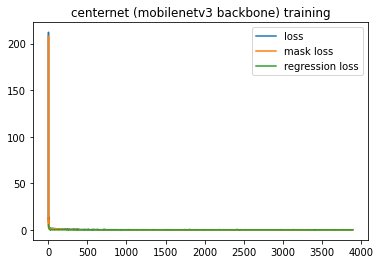

In [66]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses)),mask_losses)
plt.plot(range(len(losses)),regr_losses)
plt.title("centernet (mobilenetv3 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

## Visualize Confidence Scores over training

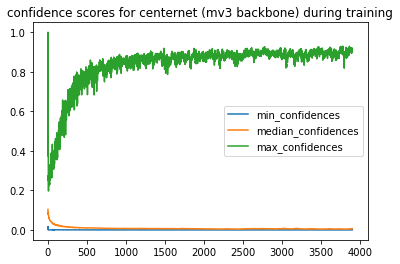

In [67]:
plt.plot(range(len(min_confidences)),min_confidences )
plt.plot(range(len(median_confidences)),median_confidences)
plt.plot(range(len(max_confidences)),max_confidences)
plt.title("confidence scores for centernet (mv3 backbone) during training")
plt.legend(['min_confidences','median_confidences','max_confidences'])
plt.show()

## Visualize Training Loss for Resnet18

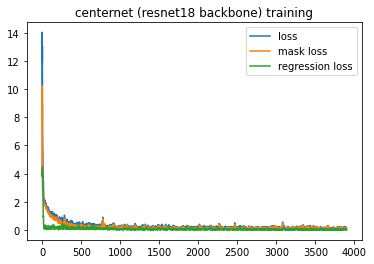

In [68]:
plt.plot(range(len(losses_resnet18)),losses_resnet18 )
plt.plot(range(len(losses_resnet18)),mask_losses_resnet18)
plt.plot(range(len(losses_resnet18)),regr_losses_resnet18)
plt.title("centernet (resnet18 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

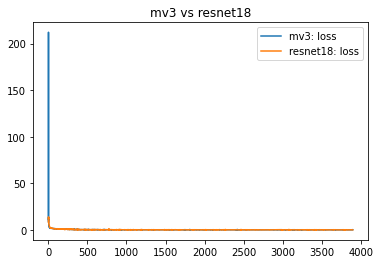

In [69]:
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses_resnet18)),losses_resnet18)
plt.title("mv3 vs resnet18")
plt.legend(['mv3: loss','resnet18: loss'])
plt.show()

# Visualize Predictions

In [70]:
# model_mv3(torch.rand(1,3,512,512))

In [71]:
model_mv3.eval()
model_mv3.cpu()
for img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale,boxes_aug, target in val_loader:
        break

pred_hm, pred_regs = model_mv3(img)# (4,1,128,128), (4,2,128,128)
pred_hm = torch.sigmoid(pred_hm)
# bboxes,scores,classes = pred2box_multiclass(pred_hm[0].cpu().data.numpy(),
#                                                         pred_regs[0].cpu().detach().numpy(),128,1,thresh=0.0)
bboxes,scores,classes = pred2box_multiclass(pred_hm[0].data.numpy(),pred_regs[0].data.numpy(),128,1,thresh=0.25)
bboxes,scores,classes =  filter_and_nms(bboxes,scores,classes,nms_threshold=0.45,n_top_scores=20)
print(bboxes)

[[  0.   1.  18.  17.]
 [ 92.  36. 109.  52.]
 [ 45. 109.  61. 124.]
 [ 38.  35.  55.  50.]
 [ 43.  11.  57.  23.]
 [ 80.   3.  97.  18.]
 [  0.  41.  14.  54.]
 [100.  13. 114.  25.]
 [ 92. 110. 105. 122.]
 [ 21. 102.  28. 110.]
 [ 35.  90.  42.  98.]
 [ 94.  98. 102. 106.]
 [115.   9. 123.  17.]
 [  5.  58.  13.  66.]
 [ 85.  74.  93.  82.]]


In [72]:
hm.shape

torch.Size([1, 2, 128, 128])

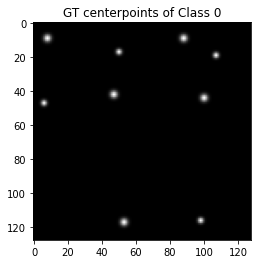

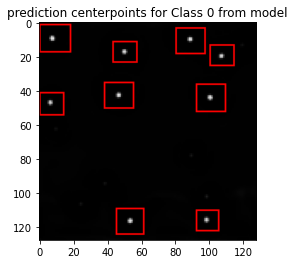

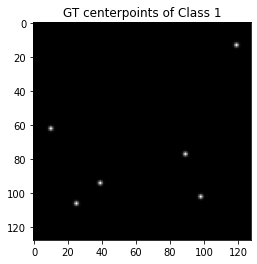

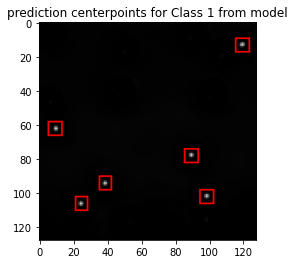

In [73]:
for i in range(hm.shape[1]):
    hm_gt = hm[0].data.numpy()[i]
    hm_pred = pred_hm[0].data.numpy()[i]
    hm_pred = np.dstack([hm_pred*255]*3).astype(np.uint8)
    for b,c in zip(bboxes,classes):
        if c == i:
            x,y,x2,y2 = [int(k) for k in b]
            # print(x,y)
            cv2.rectangle(hm_pred,(x,y),(x2,y2),(255,0,0),1)
        
    plt.imshow(hm_gt,cmap='gray')
    plt.title("GT centerpoints of Class {}".format(i))
    plt.show()
    plt.imshow(hm_pred)
    plt.title("prediction centerpoints for Class {} from model".format(i))
    plt.show()
